# 6팀 초급프로젝트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 기본 세팅
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter
from IPython.display import set_matplotlib_formats
import seaborn as sns
! pip install koreanize-matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.5 MB/s eta 0:00:00


In [ ]:
# 라이브러리 폰트 매니저 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔스퀘어 폰트 설치
!apt-get install -y fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family=font_prop.get_name())

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.6 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 1.분석 주제 정의

- **1-1. 분석 주제**
    - 고령화가 빠르게 진행되고 있어 노인 친화적이지 않은 지역을 지하철역 기준으로 사전에 파악하여 개선
    - 지하철역별 노인하차인원 대비 안전성지표와 접근성 지표 생성
- **1-2. 분석 목표** : 안전성이나 접근성 지표가 낮은 지하철역을 선별하여 개선방안 제언

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


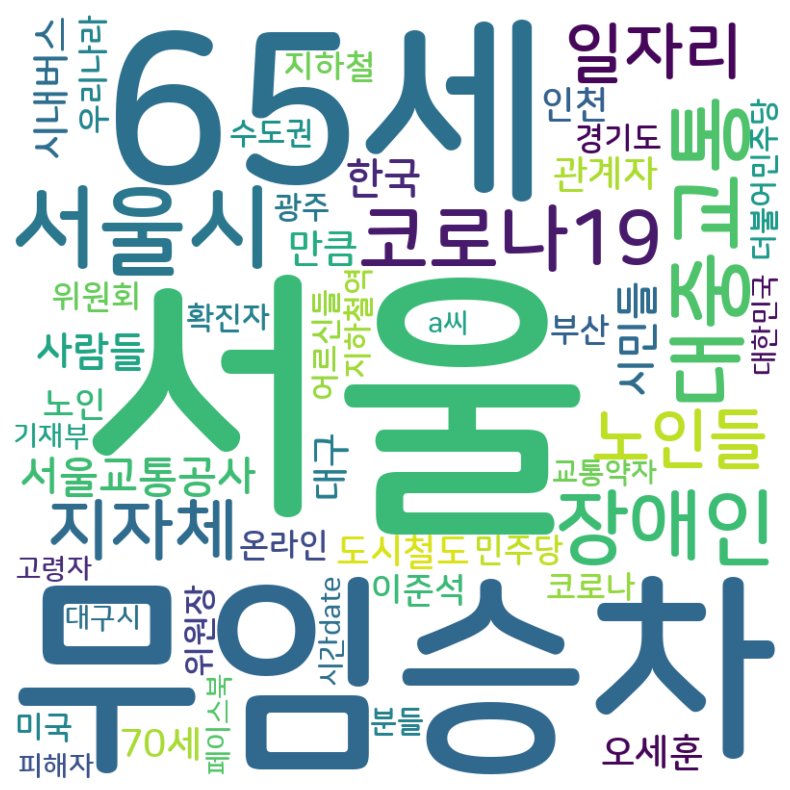

In [ ]:
# 노인 지하철 뉴스 키워드 분석 (2019-08 ~ 2024-08 빅카인즈)
keyword_df = pd.read_excel('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/901_빅카인즈 노인 지하철 뉴스 키워드_5년간.xlsx')

# 뉴스 키워드 리스트
key_words = keyword_df['특성추출(가중치순 상위 50개)']
key_word = list()

for i in range(len(key_words)):
    word = key_words[i].split(',')
    key_word.extend(word)

# 가장 많이 나온 키워드 (상위 50개)
counts = Counter(key_word)
tags = counts.most_common(50)

# Dictionary로 변환
word_freq = dict(tags)

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=800, background_color='white').generate_from_frequencies(word_freq)

# 결과 출력
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 2.데이터 수집 및 전처리



### **2-1. 데이터 설명**

1. 지하철역 관련 : 메인으로 사용할 데이터 (subway_df)
2. 자치구 관련 : 메인데이터 분석후 상황에 따라 자치구 별로 추가 분석 진행 (gu_df)

| 데이터 수집 |  |  |  | 데이터 전처리 및 결합 |  |
| --- | --- | --- | --- | --- | --- |
| 구분 | 번호(데이터프레임) | 데이터 설명 | 데이터출처 | 변수선택 | 파생변수 생성 |
| 지하철역 | subway_df101 | 서울교통공사 지하철 역주소(호선, 역명, 주소) | [공공데이터포털](https://www.data.go.kr/data/15044231/fileData.do?recommendDataYn=Y) | 호선, 역명, 도로명주소, 지번주소 (4개) | 행정구 (1개) |
| 지하철역 | subway_df102 | 지하철역별 위도, 경도 정보 | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/OA-21232/S/1/datasetView.do) | 위도, 경도 (2개) |  |
| 지하철역 | subway_df103 | 지하철역별 엘리베이터, 에스컬레이터, 휠체어리프트, 무빙워크 수 | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/OA-11573/S/1/datasetView.do) | 지하철역별 엘리베이터, 에스컬레이터, 휠체어리프트, 무빙워크 수 (4개) |  |
| 지하철역 | subway_df104 | 2019-2023년 서울교통공사 지하철 사고 현황 | [공공데이터포털](https://www.data.go.kr/data/15112860/fileData.do) |  | 지하철역별 최근 5년간 안전사고 발생 횟수 (1개) |
| 지하철역 | subway_df105 | 지하철역별 승강장관련 정보(연단간격, 높이차, 곡선/직선 여부) | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/OA-22124/S/1/datasetView.do) |  | 지하철역별 연단간격 높음수, 높이차 높음수 (2개) |
| 지하철역 | subway_df106 | 2015-01~2024-07 월별 지하철역별 유임/무임 승차/하차 인원수 | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/OA-12251/S/1/datasetView.do) |  | 2023년 월평균 지하철역별 (유임/무임) & (승차/하차) 인원수 (4개) |
| 지하철역 | subway_df107 | 2023-01-01~2023-09-30 일별 지하철역별 시간대별(06시이전, 1시간간격 18개, 24시이후, 총20개 컬럼) 노인 승차/하차 인원수 | [공공데이터포털](https://www.data.go.kr/data/15101985/fileData.do) |  | 2023년 일평균 지하철역별 (평일/토요일/일요일) & (승차/하차) & 시간대별(20개) 노인 인원수(3 X 2 X 20 = 120개), 역코드, 총 승하차인원수 (총 122개) |
| 지하철역 | subway_df108 | 전국전통시장표준데이터(지하철역별 인접시장 산출 목적) | [공공데이터포털](https://www.data.go.kr/data/15012894/standard.do) |  | 지하철역별 500m이내 전통시장수 (1개) |
| 지하철역 | subway_df109 | 지하철역 주변시설 | 공공데이터포털 api활용 |  | 지하철역별 공원, 행정시설, 의료시설, 복지시설, 종교시설 수 (5개) |
| 자치구 | gu_df201 | 2023년 자치구별 연령별 인구현황 | [행정안전부](https://jumin.mois.go.kr/ageStatMonth.do) |  | 자치구별 고령인구 (총합/남자/여자) & (인구수/고령인구비율) (3*2 = 6개) |
| 자치구 | gu_df202 | 2023년 자치구별 노인여가시설과 노인복지시설 수 | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/54/S/2/datasetView.do) | 자치구별 노인복지관, 경로당, 노인교실, 총합 수 (4개) |  |
| 자치구 | gu_df203 | 자치구별 지하철역 정보 | [공공데이터포털](https://www.data.go.kr/data/15081868/fileData.do) | 자치구별 지하철역 개수 (1개) |  |
| 자치구 | gu_df204 | 서울시 소방서, 안전센터, 구조대 위치정보 | [서울 열린데이터 광장](https://data.seoul.go.kr/dataList/OA-21072/S/1/datasetView.do) |  | 자치구별 소방서 수 (1개) |

### **2-2. 데이터전처리 및 결합**
 - 수집된 데이터를 지하철역별/자치구별 ID선정 후 데이터 결합

1. 지하철역 관련 :
    - 각 데이터를 ‘서울교통공사 역주소(규칙적용).csv’에서 ‘호선’,’역명’ 컬럼 기준 통일
        - 호선 : 숫자로 변경 (1호선 → 1)
        - 역명 : ~’역’ 제거 (서울역 → 서울), 괄호 제거 (교대(법원.검찰청) → 교대)
    - 결합 후 결측치 제거 :
        - 9호선(13개역), 6호선(신내, 연신내), 3호선 충무로역 제거 : 미기입정보로 인해 원활한 분석 불가
2. 자치구 관련 : 서울시 '행정구' 기준으로 통일

#### 2-2-1. 지하철역 관련 데이터 전처리 및 결합

In [ ]:
# subway_df101	서울교통공사 지하철 역주소(호선, 역명, 주소)
subway_df101 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/101_서울교통공사 역주소.csv' , encoding ='euc-kr')

# subway_df 지하철역 관련 결합할 데이터 생성
subway_df = subway_df101[['호선','역명','도로명주소','지번주소']].copy()

# '역명' 열의 값 변경 (괄호제거)
subway_df['역명'] = subway_df['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# 파생변수 '행정구' 생성 : '지번주소'에서 두 번째 단어를 추출하여 '행정구' 열에 채우기
subway_df['행정구'] = subway_df['지번주소'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else None)  # '지번주소'에서 공백을 기준으로 두 번째 단어 추출, 없으면 None 반환

# 결측치, 중복값 확인
print(f"결측치수 :\n{subway_df.isna().sum()}")
print(f"중복값수 : {subway_df.duplicated().sum()}")

결측치수 :
호선       0
역명       0
도로명주소    0
지번주소     0
행정구      0
dtype: int64
중복값수 : 0


In [ ]:
# subway_df102	지하철역별 위도, 경도 정보
subway_df102 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/102_서울시 역사마스터 정보(위도,경도).csv' , encoding ='euc-kr')

# '호선' 열의 값 변경 (1호선 → 1, 9호선(3단계) → 9)
subway_df102['호선'] = subway_df102['호선'].str.replace('호선', '').str.replace(r'\(.*\)', '', regex=True).str.strip()

# '역사명' 열을 '역명'으로 바꾸기
subway_df102.rename(columns={'역사명':'역명'}, inplace=True)

# '역명' 열의 값 변경 (괄호제거)
subway_df102['역명'] = subway_df102['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
subway_df102['역명'] = subway_df102['역명'].str.replace(r'역$', '', regex=True).str.strip()

#'호선'열 숫자가 아닌 값이 있는 행 제거
subway_df102 = subway_df102[subway_df102['호선'].str.match(r'^\d+$')]

# '호선'열 정수로 변환
subway_df102['호선'] = subway_df102['호선'].astype(int)

# '호선'과'역명'을 기준으로 중복된 행 발생시 첫 번째 행만 남겨두기
subway_df102 = subway_df102.drop_duplicates(subset=['호선', '역명'], keep='first')

# 4호선 서울역 '위도', '경도' 값 변경
subway_df102.loc[(subway_df102['호선'] == 4) & (subway_df102['역명'] == '서울'), ['위도', '경도']] = [37.553172, 126.972836]

# '호선'과 '역명'을 기준으로 '위도'열과 '경도'열을 subway_df에 추가
subway_df = subway_df.merge(subway_df102[['호선', '역명', '위도', '경도']],
                            on=['호선', '역명'], how='left')

In [ ]:
# subway_df103	지하철역별 엘리베이터, 에스컬레이터, 휠체어리프트, 무빙워크 수
subway_df103 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/103_역 별 엘리베이터_에스컬레이터_휠체어리프트_무빙워크 설치수.csv' , encoding ='euc-kr')

# '역명' 열의 값 변경 (괄호제거)
subway_df103['역명'] = subway_df103['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
subway_df103['역명'] = subway_df103['역명'].str.replace(r'역$', '', regex=True).str.strip()

# '호선' 열의 값 변경 (1호선 → 1, 9호선(3단계) → 9)
subway_df103['호선'] = subway_df103['호선'].str.replace('호선', '').str.replace(r'\(.*\)', '', regex=True).str.strip()

#'호선'열 숫자가 아닌 값이 있는 행 제거
subway_df103 = subway_df103[subway_df103['호선'].str.match(r'^\d+$')]

# '호선'열 정수로 변환
subway_df103['호선'] = subway_df103['호선'].astype(int)

# '호선'과'역명'을 기준으로 중복된 행 발생시 첫 번째 행만 남겨두기
subway_df103 = subway_df103.drop_duplicates(subset=['호선', '역명'], keep='first')

# '호선'과 '역명'을 기준으로 (엘리베이터, 에스컬레이터, 휠체어리프트, 수평자동보도)열을 subway_df에 추가
subway_df = subway_df.merge(subway_df103[['호선', '역명', '엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)']],
                            on=['호선', '역명'], how='left')

In [ ]:
# subway_df104	2019-2023년 서울교통공사 지하철 사고 현황
subway_df104 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/104_서울교통공사_최근 5년 지하철 사고 현황_20231231.csv' , encoding ='euc-kr', index_col='연번')

# '발생역' 열을 '역명'으로 바꾸기
subway_df104.rename(columns={'발생역':'역명'}, inplace=True)

# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
subway_df104['역명'] = subway_df104['역명'].str.replace(r'역$', '', regex=True).str.strip()

# '호선'열 만들기 :
# 1. '역명'에 괄호안에 숫자가 있으면 해당 숫자를 '호선'열에 값으로 넣기 ex) 잠실(2) → '호선' 2
subway_df104['호선'] = 0
mask104 = subway_df104['역명'].str.contains(r'\(\d+\)', na=False)
extracted_values = subway_df104['역명'].str.extract(r'\((\d+)\)')[0]
subway_df104.loc[mask104, '호선'] = pd.to_numeric(extracted_values, errors='coerce').fillna(0).astype(int)  # NaN 값을 0으로 대체하고 정수형으로 변환

# 2. '역명' 열의 값 변경 (괄호제거)
subway_df104['역명'] = subway_df104['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# 3. '호선'열 정수 변환
subway_df104['호선'] = subway_df104['호선'].astype(int)

# 4. '역명' 값 변경 (둔촌 → 둔촌동), (4호선 이수 → 총신대입구), (효창공원 → 효창공원앞)
subway_df104['역명'] = subway_df104['역명'].replace('둔촌', '둔촌동')
subway_df104.loc[(subway_df104['역명'] == '이수') & (subway_df104['호선'] == 4), '역명'] = '총신대입구'
subway_df104['역명'] = subway_df104['역명'].replace('효창공원', '효창공원앞')


# 5. '호선' 열 값이 0인 경우, subway_df['역명']과 subway_df104['역명']이 일치하면 subway_df['호선'] 값 가져오기
for index, row in subway_df104.iterrows():  # subway_df104 각 행을 반복 수행
    if row['호선'] == 0:  # '호선' 값이 0인 경우
        matched_row = subway_df[subway_df['역명'] == row['역명']]  # '역명'이 일치하는 행 찾기
        if not matched_row.empty:  # 찾은 값이 빈 값이 아니면
            subway_df104.at[index, '호선'] = matched_row['호선'].values[0]  # '호선' 값을 채워넣기

# 파생변수 '5년간 안전사고 발생 횟수' 열을 subway_df 결합데이터에 생성 : subway_df104의 '호선'과'역명'이 일치하는 행의 수 넣기
subway_df['5년간 안전사고 발생 횟수'] = 0
count_df104 = subway_df104.groupby(['호선', '역명']).size().reset_index(name='발생 횟수')  # subway_df104의 '호선'과 '역명' 조합의 발생 횟수 계산
for index, row in count_df104.iterrows():
    subway_df.loc[(subway_df['호선'] == row['호선']) & (subway_df['역명'] == row['역명']), '5년간 안전사고 발생 횟수'] = row['발생 횟수']

# subway_df104.info()
# subway_df104.loc[(subway_df104['역명'] == '서울') & (subway_df104['호선'] == 1)]

In [ ]:
# subway_df105	지하철역별 승강장관련 정보(연단간격, 높이차, 곡선/직선 여부)
subway_df105 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/105_서울교통공사 연단정보와 곡선구간 정보.csv' , encoding ='euc-kr')

# '호선'과 '역명'이 일치하는 경우 subway_df105에서 '연단간격'이 '넓음'인 값의 수를 계산
merged_df105_yd = subway_df.merge(subway_df105[subway_df105['연단간격'] == '넓음'], on=['호선', '역명'], how='left')

# 파생변수 '연단간격 높음 수' 열을 subway_df 결합데이터에 생성 - 지하철역별 '넓음'수 카운트
count_yd = merged_df105_yd[merged_df105_yd['연단간격'].notna()].groupby(['호선', '역명']).size().reset_index(name='연단간격 높음 수')
subway_df = subway_df.merge(count_yd, on=['호선', '역명'], how='left').fillna(0)

# '호선'과 '역명'이 일치하는 경우 subway_df105에서 '높이차'가 '높음'인 값의 수를 계산
merged_df105_height = subway_df.merge(subway_df105[subway_df105['높이차'] == '높음'], on=['호선', '역명'], how='left')

# 파생변수 '높이차 높음 수' 열을 subway_df 결합데이터에 생성 - 지하철역별 '높음'수 카운트
count_height = merged_df105_height[merged_df105_height['높이차'].notna()].groupby(['호선', '역명']).size().reset_index(name='높이차 높음 수')
subway_df = subway_df.merge(count_height, on=['호선', '역명'], how='left').fillna(0)

In [ ]:
# subway_df106	2015-01~2024-07 월별 지하철역별 유임/무임 승차/하차 인원수
subway_df106 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/106_서울시 지하철 호선별 역별 유_무임 승하차 인원 정보.csv' , encoding ='euc-kr')

# 2023년 데이터만 사용하기 : '사용월' 열이 '202301'에서 '202312' 사이의 값인 행만 선택
filtered_subway_df106 = subway_df106.loc[(subway_df106['사용월'] >= 202301) & (subway_df106['사용월'] <= 202312)].copy()

# 열 이름 변경 : 호선명 → 호선, 지하철역 → 역명
filtered_subway_df106.rename(columns={'호선명':'호선', '지하철역':'역명'}, inplace=True)

# '호선' 열의 값 변경 (1호선 → 1, 9호선(3단계) → 9)
# '호선'열 숫자가 아닌 값이 있는 행 제거
# '호선'열 정수로 변환
filtered_subway_df106['호선'] = filtered_subway_df106['호선'].str.replace('호선', '').str.replace(r'\(.*\)', '', regex=True).str.strip()
filtered_subway_df106 = filtered_subway_df106[filtered_subway_df106['호선'].str.match(r'^\d+$')]
filtered_subway_df106.loc[:, '호선'] = filtered_subway_df106['호선'].astype(int)

# '역명' 열의 값 변경 (괄호제거)
# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
filtered_subway_df106.loc[:, '역명'] = filtered_subway_df106['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()
filtered_subway_df106.loc[:, '역명'] = filtered_subway_df106['역명'].str.replace(r'역$', '', regex=True).str.strip()

# 파생변수 생성 : 2023년 지하철역별 유임/무임 & 승차/하차 평균인원 계산
averaged_subway_df106 = filtered_subway_df106.groupby(['호선', '역명']).agg({
    '유임승차인원': lambda x: round(x.mean(), 5),
    '무임승차인원': lambda x: round(x.mean(), 5),
    '유임하차인원': lambda x: round(x.mean(), 5),
    '무임하차인원': lambda x: round(x.mean(), 5)
}).reset_index()

# subway_df에 유임/무임 & 승차/하차 열 추가하기
subway_df = subway_df.merge(averaged_subway_df106, on=['호선', '역명'], how='left',
    suffixes=('', '_평균')  # 동일한 열 이름 충돌 방지
)

# 열 순서 변경
columns_to_move = ['유임승차인원', '유임하차인원', '무임승차인원', '무임하차인원']  # 이동할 열 리스트
remaining_columns = [col for col in subway_df.columns if col not in columns_to_move]  # 나머지 열 리스트 생성
new_order = remaining_columns + columns_to_move  # 새로운 열 순서 생성
subway_df = subway_df[new_order]  # DataFrame 열 순서 변경

In [ ]:
# subway_df107	2023-01-01~2023-09-30 일별 지하철역별 시간대별(06시이전, 1시간간격 18개, 24시이후, 총20개 컬럼) 노인 승차/하차 인원수
subway_df107 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/107_서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20230930.csv', encoding='euc-kr', index_col='연번', low_memory=False)

# 열 이름 변경 : 역번호 → 역코드
subway_df107.rename(columns={'역번호':'역코드'}, inplace=True)

# '역명' 열의 값 변경 (괄호제거)
# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
subway_df107.loc[:, '역명'] = subway_df107['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()
subway_df107.loc[:, '역명'] = subway_df107['역명'].str.replace(r'역$', '', regex=True).str.strip()
subway_df101.loc[:, '역명'] = subway_df101['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()
subway_df101.loc[:, '역명'] = subway_df101['역명'].str.replace(r'역$', '', regex=True).str.strip()

# '호선'열 추가하기 : subway_df101데이터 이용 '역코드'와 '역명'이 일치하면 '호선'값 가져오기
subway_df107 = subway_df107[subway_df107['역코드'] != '소계']   # '역코드' 소계 값 행 제거
subway_df107.loc[:, '역코드'] = subway_df107['역코드'].astype(int)  # '역코드' 정수 변환
merged_df107 = subway_df107.merge(
    subway_df101[['역번호', '역명', '호선']],
    left_on=['역코드', '역명'],
    right_on=['역번호', '역명'],
    how='left'
)

# '호선'을 3번째 열로 이동
columns_df107 = merged_df107.columns.tolist()
columns_df107.insert(2, columns_df107.pop(columns_df107.index('호선')))  # '호선'을 3번째로 이동

# 최종 DataFrame 생성
subway_df107_ver2 = merged_df107[columns_df107]
# subway_df107_ver2[subway_df107_ver2['호선'].isnull()]
subway_df107_ver2.loc[:, '호선'] = subway_df107_ver2['호선'].astype(int)
subway_df107_ver2 = subway_df107_ver2.drop(columns=['역번호'])  # '역번호' 열 제거

# 데이터 변형 : 2023년 일평균 지하철역별 (평일/토요일/일요일) & (승차/하차) & 시간대별(20개) 노인인원수 (3 * 2 * 20 = 120개), 총승하차인원수, 역코드 (총 122개)
def check_date(date):   # 2023-01-01 ~ 2023-09-30 일별 데이터를 (평일/토요일/일요일) 분류
    weekday = pd.to_datetime(date).weekday()  # 0 = 월요일, 6 = 일요일
    if weekday < 5:
        return '평일'
    elif weekday == 5:
        return '토요일'
    else:
        return '일요일'

# '수송일자' 기준으로 요일 구분 추가
subway_df107_ver2['요일구분'] = subway_df107_ver2['수송일자'].apply(check_date)

# 시간대 컬럼 리스트 추출
time_columns = subway_df107_ver2.columns.difference(['수송일자', '역코드', '호선', '역명', '승하차구분', '요일구분'])

# 데이터를 melt하여 긴 형식으로 변환
df107_melted = subway_df107_ver2.melt(
    id_vars=['역코드', '호선', '역명', '승하차구분', '요일구분'],
    value_vars=time_columns,
    var_name='시간대',
    value_name='인원수'
)

# 새로운 컬럼명 생성
df107_melted['index'] = df107_melted['요일구분'] + '-' + df107_melted['승하차구분'] + '-' + df107_melted['시간대']

# 불필요한 컬럼 제거
df107_melted = df107_melted.drop(columns=['승하차구분', '요일구분', '시간대'])

# 데이터 그룹화 및 평균 계산
df107_grouped = df107_melted.groupby(['역코드', '호선', '역명', 'index'])['인원수'].mean().round().reset_index()

# 데이터를 피벗하여 원하는 형태로 변환
df107_pivot = df107_grouped.pivot(index=['역코드', '호선', '역명'], columns='index', values='인원수')
subway_df107_ver3 = df107_pivot.reset_index()

In [ ]:
# subway_df107(추가작업)
# 지하철역별 총승하차인원 열 추가

# 'index', '역코드', '호선', '역명'을 제외한 열 선택
df107_columns_to_sum = subway_df107_ver3.columns.difference(['index', '역코드', '호선', '역명'])

# 행별로 합산하여 '총승하차인원' 열 생성
subway_df107_ver3['총승하차인원'] = subway_df107_ver3[df107_columns_to_sum].sum(axis=1)


In [ ]:
# # subway_df107 파생변수 subway_df에 추가
subway_df = subway_df.merge(
    subway_df107_ver3,
    on=['호선', '역명'],
    how='left',
)

In [ ]:
from math import radians, cos, sin, sqrt, atan2

# subway_df108	전국전통시장표준데이터(지하철역별 인접시장 산출 목적) : subway_df에 지하철역별 500m이내 시장수 파생변수 추가
subway_df108 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/108_전국전통시장표준데이터.csv' , encoding ='euc-kr')

# 1. '도로명주소'에서 '서울특별시'가 포함된 행 필터링
subway_df108_ver2 = subway_df108[subway_df108['소재지도로명주소'].str.contains('서울특별시', na=False)]

# 2. 필요한 열(시장명, 지하철역명, 호선, 위도, 경도) 추출
subway_df108_ver2 = subway_df108_ver2[['시장명', '소재지도로명주소', '위도', '경도']]
subway_df_temp = subway_df[['역명', '호선', '위도', '경도']]

# 3. Haversine 거리 계산 함수 정의
def haversine(lat1, lon1, lat2, lon2):
    # 지구 반경 (단위: km)
    R = 6371.0
    # 위도와 경도를 라디안으로 변환
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # 위도와 경도 차이 계산
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine 공식 적용
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# 4. 결과 저장할 빈 리스트 생성
results = []

# 5. 시장과 지하철역 간의 거리 계산
for _, market_row in subway_df108_ver2.iterrows():
    market_name = market_row['시장명']
    market_lat = market_row['위도']
    market_lon = market_row['경도']

    closest_station = None
    closest_line = None
    closest_distance = float('inf')

    for _, subway_row in subway_df_temp.iterrows():
        subway_name = subway_row['역명']
        subway_line = subway_row['호선']
        subway_lat = subway_row['위도']
        subway_lon = subway_row['경도']

        distance = haversine(market_lat, market_lon, subway_lat, subway_lon)

        if distance < closest_distance:
            closest_distance = distance
            closest_station = subway_name
            closest_line = subway_line

    # 결과 저장 (0.5km 이하인 것만)
    if closest_distance <= 0.5:
        results.append({
            '시장명': market_name,
            '가장 가까운 지하철역': closest_station,
            '호선': closest_line,
            '이동거리(km)': closest_distance
        })

# 6. DataFrame으로 변환
subway_df108_ver3 = pd.DataFrame(results)

# 7. 파생변수 (지하철역별 500m이내 전통시장수) subway_df에 추가
# 열 이름 변경 : 가장 가까운 지하철역 → 역명
subway_df108_ver3.rename(columns={'가장 가까운 지하철역':'역명'}, inplace=True)

subway_df108_ver4 = subway_df108_ver3.copy()
subway_df108_counts = subway_df108_ver3.groupby(['호선', '역명']).size().reset_index(name='count')
subway_df108_ver4 = subway_df108_ver4.merge(subway_df108_counts, on=['호선', '역명'], how='left')
subway_df108_ver4['전통시장수(500m이내)'] = 0
subway_df108_ver4['전통시장수(500m이내)'] = subway_df108_ver4['전통시장수(500m이내)'] + subway_df108_ver4['count']
subway_df108_ver4.drop(columns=['count'], inplace=True)

subway_df108_ver4 = subway_df108_ver4.drop_duplicates(subset=['호선', '역명'])  # 중복제거
subway_df108_ver4 = subway_df108_ver4[subway_df108_ver4['역명'] != '서울']  # 이상값제거
subway_df = subway_df.merge(subway_df108_ver4[['호선', '역명', '전통시장수(500m이내)']],
                               on=['호선', '역명'],
                               how='left')
subway_df['전통시장수(500m이내)'] = subway_df['전통시장수(500m이내)'].fillna(0)  # 결측값 0 처리

In [ ]:
# subway_df109	지하철역 주변시설 : 공공데이터포털 api로 1차 가공
subway_df109 = pd.read_excel('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/109_지하철역 주변시설.xlsx' )

# 지하철역별 공원, 행정시설, 의료시설, 복지시설, 종교시설 수를 분류해서 파생변수 subway_df 데이터 결합하기

# 열 이름 변경 : 역 주변 시설, 역명, 호선
subway_df109.rename(columns={'dirDesc':'역 주변 시설', 'station':'역명','line':'호선'}, inplace=True)

# '역명' 열의 값 변경 (괄호제거)
# '역명'에서 '역'으로 끝나는 경우 삭제 (서울역 → 서울)
subway_df109.loc[:, '역명'] = subway_df109['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()
subway_df109.loc[:, '역명'] = subway_df109['역명'].str.replace(r'역$', '', regex=True).str.strip()

# '호선' 열의 값 변경 (1호선 → 1, 9호선(3단계) → 9)
# '호선'열 숫자가 아닌 값이 있는 행 제거
# '호선'열 정수로 변환
subway_df109['호선'] = subway_df109['호선'].str.replace('호선', '').str.replace(r'\(.*\)', '', regex=True).str.strip()
subway_df109 = subway_df109[subway_df109['호선'].str.match(r'^\d+$')]
subway_df109['호선'] = subway_df109['호선'].astype(int)


In [ ]:
# 중복 확인
subway_df109.duplicated(['역 주변 시설','역명']).sum()

# 불필요 컬럼 제거
subway_df109.drop_duplicates(['역 주변 시설','역명'], inplace=True)
subway_df109.drop('Unnamed: 0', axis=1)

# 하천 이름을 얻기 위한 데이터 불러오기
liver = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/서울시 하천개황 정보.csv', encoding = 'cp949')

# 하천명단 획득
livers = list((liver['지류명_1차']).unique()) + list((liver['하천명']).unique())
livers.remove(np.nan)

# 공원 코딩_1
for index, row in subway_df109.iterrows():
  if '공원' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '창덕궁' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '광화문방면' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '종묘' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '광진광장' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '청계광장' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '한얼광장' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '서울광장' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '중앙광장' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '호수' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  elif '인사동' in row['역 주변 시설']:
    subway_df109.at[index, '공원'] = 1
  else:
    subway_df109.at[index, '공원'] = 0

# 공원 코딩_2_하천_추가
subway_df109['공원'] = subway_df109.apply(lambda row: 1 if row['공원'] == 0 and any(h in row['역 주변 시설'] for h in livers) else row['공원'], axis=1)

# 하천 이름이 들어간 잘못된 시설들 코딩 0으로 변경. 그 외는 데이터 유지
NO = ['아파트','포스빌','본부','재생센터','한강로','통제소','학교','웨딩홀']
for i in NO:
  subway_df109.loc[subway_df109['역 주변 시설'].str.contains(i), '공원'] = 0

# 검증
# subway_df109[subway_df109['공원'] == 1]['역 주변 시설'].unique()

# 행정시설 추가
for index, row in subway_df109.iterrows():
  if '주민센터' in row['역 주변 시설']:
    subway_df109.at[index, '행정시설'] = 1
  elif '국민건강' in row['역 주변 시설']:
    subway_df109.at[index, '행정시설'] = 1
  elif '동사무소' in row['역 주변 시설']:
    subway_df109.at[index, '행정시설'] = 1
  elif '자치센터' in row['역 주변 시설']:
    subway_df109.at[index, '행정시설'] = 1
  elif '주민센타' in row['역 주변 시설']:
    subway_df109.at[index, '행정시설'] = 1
  else:
    subway_df109.at[index, '행정시설'] = 0

# 의료시설 추가
for index, row in subway_df109.iterrows():
  if '병원' in row['역 주변 시설']:
    subway_df109.at[index, '의료시설'] = 1
  elif '약국' in row['역 주변 시설']:
    subway_df109.at[index, '의료시설'] = 1
  elif '한의원' in row['역 주변 시설']:
    subway_df109.at[index, '의료시설'] = 1
  elif '보건소' in row['역 주변 시설']:
    subway_df109.at[index, '의료시설'] = 1
  else:
    subway_df109.at[index, '의료시설'] = 0

# 시장 추가
subway_df109.loc[subway_df109['역 주변 시설'] == '새운상가', '역 주변 시설'] = '세운상가'
for index, row in subway_df109.iterrows():
  if '시장' in row['역 주변 시설']:
    subway_df109.at[index, '시장'] = 1
  elif '낙원상가' in row['역 주변 시설']:
    subway_df109.at[index, '시장'] = 1
  elif '대림시장' in row['역 주변 시설']:
    subway_df109.at[index, '시장'] = 1
  elif '세운상가' in row['역 주변 시설']:
    subway_df109.at[index, '시장'] = 1
  else:
    subway_df109.at[index, '시장'] = 0

# 복지 시설 추가
for index, row in  subway_df109.iterrows():
  if '노인' in row['역 주변 시설']:
     subway_df109.at[index, '복지시설'] = 1
  elif '종합사회' in row['역 주변 시설']:
     subway_df109.at[index, '복지시설'] = 1
  elif '민회관' in row['역 주변 시설']:
     subway_df109.at[index, '복지시설'] = 1
  elif '양로원' in row['역 주변 시설']:
     subway_df109.at[index, '복지시설'] = 1
  elif '치매' in row['역 주변 시설']:
     subway_df109.at[index, '복지시설'] = 1
  else:
     subway_df109.at[index, '복지시설'] = 0

# 사찰 데이터 불러오기
temple = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/서울시 전통사찰 인허가 정보.csv',encoding = 'cp949')
temple['전통사찰명'].unique()

# 종교 시설 추가
subway_df109.rename(columns = {'주민센터':'종교시설'},inplace=True)
for index, row in subway_df109.iterrows():
  if '교회' in row['역 주변 시설']:
    subway_df109.at[index, '종교시설'] = 1
  elif row['역 주변 시설'] in temple['전통사찰명'].unique():
    subway_df109.at[index, '종교시설'] = 1
  elif '성당' in row['역 주변 시설']:
    subway_df109.at[index, '종교시설'] = 1
  elif '봉은사' in row['역 주변 시설'] and '봉은사로' not in ['역 주변 시설']:
    subway_df109.at[index, '종교시설'] = 1
  elif '화계사' in row['역 주변 시설']:
    subway_df109.at[index, '종교시설'] = 1
  else:
    subway_df109.at[index, '종교시설'] = 0

subway_df109.loc[subway_df109['역 주변 시설'].str.contains('은행'), '종교시설'] = 0

# 총합 컬럼 형성
subway_df109['총합'] = np.nan
subway_df109['총합'] = subway_df109['공원'] + subway_df109['의료시설'] + subway_df109['복지시설'] + subway_df109['시장'] + subway_df109['행정시설'] + subway_df109['종교시설']

# 지하철역별 시설수로 변환
subway_df109_ver2 = subway_df109.groupby(['호선','역명'])[['공원','행정시설','의료시설','복지시설','종교시설']].sum().reset_index()

# 파생변수 subway_df 데이터에 추가하기
subway_df = subway_df.merge(subway_df109_ver2[['호선', '역명', '공원','행정시설','의료시설','복지시설','종교시설']],
                               on=['호선', '역명'],
                               how='left').fillna(0)

In [ ]:
# 결합데이터 결측치 제거
# 9호선(13개역), 6호선(신내, 연신내), 3호선 충무로역 제거 : 미기입정보로 인해 원활한 분석 불가
# '호선'이 9인 행 삭제
subway_df = subway_df[subway_df['호선'] != 9]
# '호선'과 '역명' 조건에 맞는 행 삭제
subway_df = subway_df[~((subway_df['호선'] == 6) & (subway_df['역명'] == '연신내'))]
subway_df = subway_df[~((subway_df['호선'] == 6) & (subway_df['역명'] == '신내'))]
subway_df = subway_df[~((subway_df['호선'] == 3) & (subway_df['역명'] == '충무로'))]

In [ ]:
# 데이터 전처리 및 결합 완료된 데이터 생성
subway_df.to_csv('지하철역별_데이터결합본.csv', index=False, encoding='utf-8-sig')

#### 2-2-2. 자치구 관련 데이터 전처리 및 결합

In [ ]:
# gu_df201	2023년 자치구별 연령별 인구현황
gu_df201 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/201_202312_자치구별_연령별인구현황_연간.csv' , encoding ='euc-kr')

# 첫번째 서울특별시 전체 인원 행 제거
gu_df201 = gu_df201.drop(index=0).reset_index(drop=True)

# '행정구역' 열에서 3번째 단어만 추출하여 업데이트 : '서울특별시 서울특별시 종로구 어쩌구' → '종로구'
gu_df201['행정구역'] = gu_df201['행정구역'].str.split().str[2]

# 파생변수 생성 : 연령별 성별 인구수데이터를 (총합/남자/여자) & (인구수/고령인구비율)로 분류(3x2 = 6개)
# 고령인구_총합 계산 (65세 이상 인구 합계)
gu_df201['고령인구_총합'] = (gu_df201['2023년_계_65~69세'] +
                               gu_df201['2023년_계_70~74세'] +
                               gu_df201['2023년_계_75~79세'] +
                               gu_df201['2023년_계_80~84세'] +
                               gu_df201['2023년_계_85~89세'] +
                               gu_df201['2023년_계_90~94세'] +
                               gu_df201['2023년_계_95~99세'] +
                               gu_df201['2023년_계_100세 이상'])

# 고령인구_남자 및 고령인구_여자 계산
gu_df201['고령인구_남자'] = (gu_df201['2023년_남_65~69세'] +
                              gu_df201['2023년_남_70~74세'] +
                              gu_df201['2023년_남_75~79세'] +
                              gu_df201['2023년_남_80~84세'] +
                              gu_df201['2023년_남_85~89세'] +
                              gu_df201['2023년_남_90~94세'] +
                              gu_df201['2023년_남_95~99세'] +
                              gu_df201['2023년_남_100세 이상'])

gu_df201['고령인구_여자'] = (gu_df201['2023년_여_65~69세'] +
                               gu_df201['2023년_여_70~74세'] +
                               gu_df201['2023년_여_75~79세'] +
                               gu_df201['2023년_여_80~84세'] +
                               gu_df201['2023년_여_85~89세'] +
                               gu_df201['2023년_여_90~94세'] +
                               gu_df201['2023년_여_95~99세'] +
                               gu_df201['2023년_여_100세 이상'])

# 고령인구비율_전체, 고령인구비율_남자, 고령인구비율_여자 계산
gu_df201['고령인구비율_전체'] = round(gu_df201['고령인구_총합'] / gu_df201['2023년_계_총인구수'] * 100,1)
gu_df201['고령인구비율_남자'] = round(gu_df201['고령인구_남자'] / gu_df201['2023년_남_총인구수'] * 100,1)
gu_df201['고령인구비율_여자'] = round(gu_df201['고령인구_여자'] / gu_df201['2023년_여_총인구수'] * 100,1)

# 열 이름 변경 : 행정구역 → 행정구
gu_df201.rename(columns={'행정구역':'행정구'}, inplace=True)

# 자치구별 결합데이터 생성
gu_df = gu_df201[['행정구', '고령인구_총합', '고령인구_남자', '고령인구_여자',
                   '고령인구비율_전체', '고령인구비율_남자', '고령인구비율_여자']].copy()

In [ ]:
# gu_df202	2023년 자치구별 노인여가시설과 노인복지시설 수
gu_df202 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/202_노인여가+복지시설(구별)_20240828112342.csv' , encoding ='utf-8-sig', header=1)
gu_df202 = gu_df202.drop(index=[0,1]).reset_index(drop=True)

# 열 이름 변경 : 자치구(2) → 행정구, 시설이름들
gu_df202.rename(columns={'자치구(2)':'행정구','노인복지관':'노인복지관 시설수', '경로당 (개소)':'경로당 수','노인교실 (개소)':'노인교실 수'}, inplace=True)

# 사용할 시설 정수 변환
gu_df202_columns_to_convert = ['노인복지관 시설수', '경로당 수', '노인교실 수']

for column in gu_df202_columns_to_convert:
    gu_df202[column] = pd.to_numeric(gu_df202[column], errors='coerce')

gu_df202[gu_df202_columns_to_convert] = gu_df202[gu_df202_columns_to_convert].fillna(0).astype(int)

# # 파생변수 추가 : 노인여가복지시설 총합
gu_df202['노인여가복지시설 총합'] = (gu_df202['노인복지관 시설수'] + gu_df202['경로당 수'] + gu_df202['노인교실 수'])

# 자치구별 노인복지관, 경로당, 노인교실, 총합 수 (4개) 결합데이터 gu_df에 추가하기
gu_df = gu_df.merge(gu_df202[['행정구','노인복지관 시설수','경로당 수','노인교실 수','노인여가복지시설 총합']],
                               on=['행정구'], how='left').fillna(0)

In [ ]:
# gu_df203	자치구별 지하철역 정보
gu_df203 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/203_서울교통공사_자치구별지하철역정보_20240628.CSV.csv' , encoding ='euc-kr')

# 열 이름 변경 : 역개수 → 지하철역 개수, 자치구 → 행정구
gu_df203.rename(columns={'역개수':'지하철역 개수','자치구':'행정구'}, inplace=True)

# 자치구별 지하철역 개수를 결합데이터 gu_df에 추가하기
gu_df = gu_df.merge(gu_df203[['행정구','지하철역 개수']],
                               on=['행정구'], how='left').fillna(0)

In [ ]:
# 기본 세팅
!pip install geopy
!pip install pyproj requests pandas
from pyproj import Transformer
import requests

In [ ]:
# gu_df204	서울시 소방서, 안전센터, 구조대 위치정보
gu_df204 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Raw_Data/204_서울시 소방서,안전센터,구조대 위치정보.csv' , encoding ='euc-kr', index_col='연번')

# 좌표계 WGS84로 변환하고 컬럼 추가해서 값 채우기
transformer = Transformer.from_crs("EPSG:5186", "EPSG:4326", always_xy=True)
gu_df204['경도'], gu_df204['위도'] = transformer.transform(gu_df204['X좌표'].values, gu_df204['Y좌표'].values)

# API
KAKAO_API_KEY = '3defa7fa75e384a28c915bbde88a0f25'
KAKAO_API_URL = "https://dapi.kakao.com/v2/local/geo/coord2address.json"

# 도로명 주소 가져오기
def get_road_address(longitude, latitude):
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {"x": longitude, "y": latitude, "input_coord": "WGS84"}

    try:
        response = requests.get(KAKAO_API_URL, headers=headers, params=params)
        response.raise_for_status()
        result = response.json()

        if result['documents']:
            road_address = result['documents'][0].get('road_address')
            if road_address:
                return road_address['address_name']
            else:
                return result['documents'][0].get('address', {}).get('address_name', "도로명 주소 없음")
        else:
            return "결과 없음"
    except requests.exceptions.RequestException as e:
        return "API 요청 오류"

# 도로명주소 컬럼 추가하고 값 채우기
gu_df204['도로명주소'] = gu_df204.apply(lambda row: get_road_address(row['경도'], row['위도']), axis=1)

# 행정구 컬럼 만들기
def extract_district(address):
    try:
        if address and " " in address: # address가 None이 아니고 공백이 있는지 확인
            parts = address.split(" ") # 공백을 기준으로 주소를 나누고 리스트에 저장함
            if len(parts) > 1:  # 리스트가 1보다 크면
                return parts[1]  # 두 번째 요소 parts[1]을 반환
                 # (두번째 요소인 이유 : 시-구-동에서 구가 두 번째)
        return "구 없음"  # 조건 충족 안함
    except Exception as e:
        return "오류 발생"

# '행정구' 컬럼 추가
gu_df204['행정구'] = gu_df204['도로명주소'].apply(extract_district)

In [ ]:
# 파생변수 자치구별 소방서 수를 결합데이터 gu_df에 추가하기
# '행정구'별로 gu_df204에서 소방서 수를 계산
fire_station_counts = gu_df204['행정구'].value_counts()

# gu_df에 '소방서 수' 열 추가 및 기본값 0으로 초기화
gu_df['소방서 수'] = 0

# 일치하는 '행정구'에 대해 소방서 수를 할당
for admin_district in fire_station_counts.index:
    if admin_district in gu_df['행정구'].values:
        gu_df.loc[gu_df['행정구'] == admin_district, '소방서 수'] = fire_station_counts[admin_district]

In [ ]:
# 데이터 전처리 및 결합 완료된 데이터 생성
gu_df = gu_df.sort_values(by='행정구')
gu_df.to_csv('자치구별_데이터결합본.csv', index=False, encoding='utf-8-sig')

## 3.EDA
    



### 3-1.데이터설명

| 구분 | 변수명 | 설명 | 예시 |
| --- | --- | --- | --- |
| 지하철역 | 호선 | 지하철역 호선 | 1 |
| 지하철역 | 역명 | 지하철 호선별 역명 | 잠실, 시청, 동묘앞 |
| 지하철역 | 도로명주소 | 지하철역 도로명주소 | 서울특별시 종로구 종로 359(숭인동) |
| 지하철역 | 지번주소 | 지하철역 지번주소 | 서울특별시 종로구 숭인동 117 동묘앞역(1호선) |
| 지하철역 | 행정구 | 지하철역 행정구 | 종로구 |
| 지하철역 | 위도 | 지하철역 위도 | 37.573197 |
| 지하철역 | 경도 | 지하철역 경도 | 127.01648 |
| 지하철역 | 엘리베이터(E/V) | 지하철역 엘리베이터 수 | 2 |
| 지하철역 | 에스컬레이터(E/S) | 지하철역 에스컬레이터 수 | 3 |
| 지하철역 | 휠체어리프트(W/L) | 지하철역 휠체어리프트 수 | 4 |
| 지하철역 | 수평자동보도(M/W) | 지하철역 수평자동보도(무빙워크) 수 | 5 |
| 지하철역 | 5년간 안전사고 발생 횟수 | 지하철역별 최근 5년간(2019-2023) 안전사고 발생횟수 | 3 |
| 지하철역 | 연단간격 높음 수 | 지하철역별 승강장과 연단간격(열차문과 바로앞 땅 사이의 거리)이 넓은 승강장 수 | 6 |
| 지하철역 | 높이차 높음 수 | 지하철역별 승강장과 높이차(열차문과 바로앞 땅 사이의 높이차)가 높은 승강장 수 | 5 |
| 지하철역 | 유임승차인원 | 2023년 월평균 지하철역별 유임승차 인원수 | 140257.25 |
| 지하철역 | 유임하차인원 | 2023년 월평균 지하철역별 유임하차 인원수 | 147059.9167 |
| 지하철역 | 무임승차인원 | 2023년 월평균 지하철역별 무임승차 인원수 | 153127.6667 |
| 지하철역 | 무임하차인원 | 2023년 월평균 지하철역별 무임하차 인원수 | 155085.25 |
| 지하철역 | 역코드 | 지하철 호선별 역명 코드 | 159 |
| 지하철역 | 일요일-승차-06-07시간대 | 2023년 일평균 지하철역별 일요일 06시~07시 승차 노인 인원수 | 16 |
| 지하철역 | … (총 120개 열) | 2023년 일평균 지하철역별 (평일/토요일/일요일) & (승차/하차) & 시간대별(06시이전, 1시간간격 18개, 24시이후) 노인 인원수 | 36 |
| 지하철역 | 평일-하차-24시간대이후 | 2023년 일평균 지하철역별 평일 24시이후 하차 노인 인원수 | 26 |
| 지하철역 | 총승하차인원 | 2023년 일평균 지하철역별 노인 승하차 인원수 | 30662 |
| 지하철역 | 전통시장수(500m이내) | 지하철역별 500m이내 전통시장수 | 2 |
| 지하철역 | 공원 | 지하철역별 공원 수 | 1 |
| 지하철역 | 행정시설 | 지하철역별 행정시설 수 | 0 |
| 지하철역 | 의료시설 | 지하철역별 의료시설 수 | 3 |
| 지하철역 | 복지시설 | 지하철역별 복지시설 수 | 1 |
| 지하철역 | 종교시설 | 지하철역별 종교시설 수 | 0 |
| 자치구 | 고령인구_총합 | 2023년 자치구별 고령인구 수 | 86434 |
| 자치구 | 고령인구_남자 | 2023년 자치구별 고령인구 남자 수 | 38798 |
| 자치구 | 고령인구_여자 | 2023년 자치구별 고령인구 여자 수 | 47636 |
| 자치구 | 고령인구비율_전체 | 2023년 자치구별 고령인구비율 | 15.9 |
| 자치구 | 고령인구비율_남자 | 2023년 자치구별 남자 고령인구비율 | 14.9 |
| 자치구 | 고령인구비율_여자 | 2023년 자치구별 여자 고령인구비율 | 16.8 |
| 자치구 | 노인복지관 시설수 | 2023년 자치구별 노인복지관 시설수 | 6 |
| 자치구 | 경로당 수 | 2023년 자치구별 경로당 수 | 176 |
| 자치구 | 노인교실 수 | 2023년 자치구별 노인교실 수 | 21 |
| 자치구 | 노인여가복지시설 총합 | 2023년 자치구별 노인여가복지시설 총합 | 203 |
| 자치구 | 지하철역 개수 | 자치구별 지하철역 개수 | 21 |
| 자치구 | 소방서 수 | 자치구별 소방서 수 | 8 |



### 3-2.EDA
  - 지하철역 관련

In [ ]:
# 지하철역 관련 결합데이터 불러오기
subway_eda_df = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/지하철역별_데이터결합본.csv' , encoding ='utf-8-sig')
subway_eda_df

,호선,역명,도로명주소,지번주소,행정구,위도,경도,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),...,평일-하차-22-23시간대,평일-하차-23-24시간대,평일-하차-24시간대이후,총승하차인원,전통시장수(500m이내),공원,행정시설,의료시설,복지시설,종교시설
0,1,서울,서울특별시 중구 세종대로 지하2(남대문로 5가),서울특별시 중구 남대문로5가 73-6 서울역(1호선),중구,37.556228,126.972135,4.0,5.0,1.0,...,32.0,17.0,5.0,27916.0,0.0,3.0,0.0,1.0,0.0,0.0
1,1,시청,서울특별시 중구 세종대로 지하101(정동),서울특별시 중구 정동 5-5 시청역(1호선),중구,37.565715,126.977088,3.0,3.0,0.0,...,6.0,3.0,1.0,13643.0,0.0,2.0,1.0,2.0,0.0,0.0
2,1,종각,서울특별시 종로구 종로 지하55(종로1가),서울특별시 종로구 종로1가 54 종각역(1호선),종로구,37.570161,126.982923,4.0,2.0,0.0,...,10.0,4.0,1.0,18946.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,종로3가,서울특별시 종로구 종로 지하129(종로3가),서울특별시 종로구 종로3가 10-5 종로3가역(1호선),종로구,37.570406,126.991847,3.0,4.0,0.0,...,15.0,7.0,4.0,45814.0,0.0,8.0,2.0,0.0,1.0,0.0
4,1,종로5가,서울특별시 종로구 종로 지하216(종로5가),서울특별시 종로구 종로5가 82-1 종로5가역(1호선),종로구,37.570926,127.001849,3.0,0.0,0.0,...,14.0,6.0,1.0,37153.0,2.0,3.0,2.0,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,8,남한산성입구,경기도 성남시 수정구 산성대로 지하445(단대동),경기도 성남시 수정구 단대동 96 남한산성입구역(8호선),성남시,37.451535,127.159816,2.0,4.0,0.0,...,43.0,16.0,6.0,11484.0,0.0,1.0,2.0,0.0,0.0,0.0
268,8,단대오거리,경기도 성남시 수정구 산성대로 지하365(신흥동),경기도 성남시 수정구 신흥동 2467 단대오거리역(8호선),성남시,37.445210,127.156866,3.0,6.0,0.0,...,39.0,15.0,5.0,11017.0,0.0,1.0,3.0,0.0,0.0,0.0
269,8,신흥,경기도 성남시 수정구 산성대로 지하280(신흥동),경기도 성남시 수정구 신흥동 2467 신흥역(8호선),성남시,37.440918,127.147564,2.0,0.0,0.0,...,17.0,6.0,1.0,6603.0,0.0,0.0,3.0,0.0,0.0,0.0
270,8,수진,경기도 성남시 수정구 산성대로 지하200(수진동),경기도 성남시 수정구 수진동 2205-1 수진역(8호선),성남시,37.437428,127.140722,3.0,0.0,0.0,...,15.0,6.0,1.0,6702.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# 기본정보 확인
pd.set_option('display.max_columns', None)
subway_eda_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 146 columns):
 #    Column           Dtype  
---   ------           -----  
 0    호선               int64  
 1    역명               object 
 2    도로명주소            object 
 3    지번주소             object 
 4    행정구              object 
 5    위도               float64
 6    경도               float64
 7    엘리베이터(E/V)       float64
 8    에스컬레이터(E/S)      float64
 9    휠체어리프트(W/L)      float64
 10   수평자동보도(M/W)      float64
 11   5년간 안전사고 발생 횟수   int64  
 12   연단간격 높음 수        float64
 13   높이차 높음 수         float64
 14   유임승차인원           float64
 15   유임하차인원           float64
 16   무임승차인원           float64
 17   무임하차인원           float64
 18   역코드              float64
 19   일요일-승차-06-07시간대  float64
 20   일요일-승차-06시간대이전   float64
 21   일요일-승차-07-08시간대  float64
 22   일요일-승차-08-09시간대  float64
 23   일요일-승차-09-10시간대  float64
 24   일요일-승차-10-11시간대  float64
 25   일요일-승차-11-12시간대  float64
 26   일요일-승차-12-13시간대  flo

In [ ]:
subway_eda_df.shape

(272, 146)

In [ ]:
subway_eda_df.columns

Index(['호선', '역명', '도로명주소', '지번주소', '행정구', '위도', '경도', '엘리베이터(E/V)',
       '에스컬레이터(E/S)', '휠체어리프트(W/L)',
       ...
       '평일-하차-22-23시간대', '평일-하차-23-24시간대', '평일-하차-24시간대이후', '총승하차인원',
       '전통시장수(500m이내)', '공원', '행정시설', '의료시설', '복지시설', '종교시설'],
      dtype='object', length=146)

In [ ]:
subway_eda_df.describe(include='all')

,호선,역명,도로명주소,지번주소,행정구,위도,경도,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W),5년간 안전사고 발생 횟수,연단간격 높음 수,높이차 높음 수,유임승차인원,유임하차인원,무임승차인원,무임하차인원,역코드,일요일-승차-06-07시간대,일요일-승차-06시간대이전,일요일-승차-07-08시간대,일요일-승차-08-09시간대,일요일-승차-09-10시간대,일요일-승차-10-11시간대,일요일-승차-11-12시간대,일요일-승차-12-13시간대,일요일-승차-13-14시간대,일요일-승차-14-15시간대,일요일-승차-15-16시간대,일요일-승차-16-17시간대,일요일-승차-17-18시간대,일요일-승차-18-19시간대,일요일-승차-19-20시간대,일요일-승차-20-21시간대,일요일-승차-21-22시간대,일요일-승차-22-23시간대,일요일-승차-23-24시간대,일요일-승차-24시간대이후,일요일-하차-06-07시간대,일요일-하차-06시간대이전,일요일-하차-07-08시간대,일요일-하차-08-09시간대,일요일-하차-09-10시간대,일요일-하차-10-11시간대,일요일-하차-11-12시간대,일요일-하차-12-13시간대,일요일-하차-13-14시간대,일요일-하차-14-15시간대,일요일-하차-15-16시간대,일요일-하차-16-17시간대,일요일-하차-17-18시간대,일요일-하차-18-19시간대,일요일-하차-19-20시간대,일요일-하차-20-21시간대,일요일-하차-21-22시간대,일요일-하차-22-23시간대,일요일-하차-23-24시간대,일요일-하차-24시간대이후,토요일-승차-06-07시간대,토요일-승차-06시간대이전,토요일-승차-07-08시간대,토요일-승차-08-09시간대,토요일-승차-09-10시간대,토요일-승차-10-11시간대,토요일-승차-11-12시간대,토요일-승차-12-13시간대,토요일-승차-13-14시간대,토요일-승차-14-15시간대,토요일-승차-15-16시간대,토요일-승차-16-17시간대,토요일-승차-17-18시간대,토요일-승차-18-19시간대,토요일-승차-19-20시간대,토요일-승차-20-21시간대,토요일-승차-21-22시간대,토요일-승차-22-23시간대,토요일-승차-23-24시간대,토요일-승차-24시간대이후,토요일-하차-06-07시간대,토요일-하차-06시간대이전,토요일-하차-07-08시간대,토요일-하차-08-09시간대,토요일-하차-09-10시간대,토요일-하차-10-11시간대,토요일-하차-11-12시간대,토요일-하차-12-13시간대,토요일-하차-13-14시간대,토요일-하차-14-15시간대,토요일-하차-15-16시간대,토요일-하차-16-17시간대,토요일-하차-17-18시간대,토요일-하차-18-19시간대,토요일-하차-19-20시간대,토요일-하차-20-21시간대,토요일-하차-21-22시간대,토요일-하차-22-23시간대,토요일-하차-23-24시간대,토요일-하차-24시간대이후,평일-승차-06-07시간대,평일-승차-06시간대이전,평일-승차-07-08시간대,평일-승차-08-09시간대,평일-승차-09-10시간대,평일-승차-10-11시간대,평일-승차-11-12시간대,평일-승차-12-13시간대,평일-승차-13-14시간대,평일-승차-14-15시간대,평일-승차-15-16시간대,평일-승차-16-17시간대,평일-승차-17-18시간대,평일-승차-18-19시간대,평일-승차-19-20시간대,평일-승차-20-21시간대,평일-승차-21-22시간대,평일-승차-22-23시간대,평일-승차-23-24시간대,평일-승차-24시간대이후,평일-하차-06-07시간대,평일-하차-06시간대이전,평일-하차-07-08시간대,평일-하차-08-09시간대,평일-하차-09-10시간대,평일-하차-10-11시간대,평일-하차-11-12시간대,평일-하차-12-13시간대,평일-하차-13-14시간대,평일-하차-14-15시간대,평일-하차-15-16시간대,평일-하차-16-17시간대,평일-하차-17-18시간대,평일-하차-18-19시간대,평일-하차-19-20시간대,평일-하차-20-21시간대,평일-하차-21-22시간대,평일-하차-22-23시간대,평일-하차-23-24시간대,평일-하차-24시간대이후,총승하차인원,전통시장수(500m이내),공원,행정시설,의료시설,복지시설,종교시설
count,272.000000,272,272,272,272,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,2.720000e+02,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
unique,NaN,239,262,272,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

- 상관관계 분석

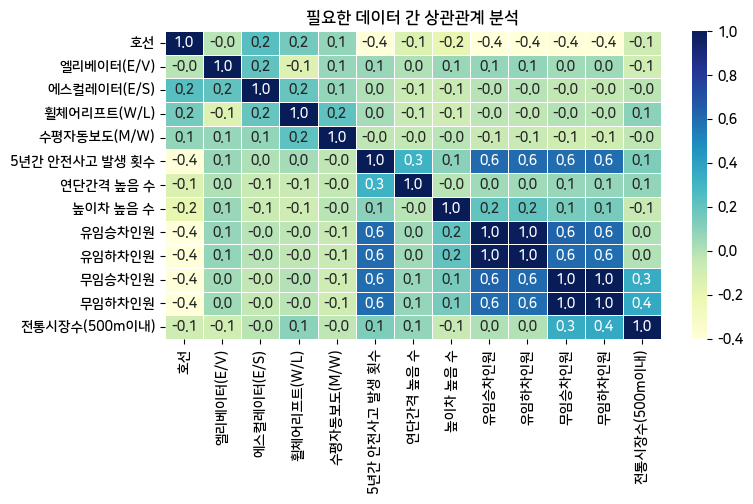

In [ ]:
df_safety = subway_eda_df.copy()
columns_wanna = ['호선', '엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)',
                       '수평자동보도(M/W)', '5년간 안전사고 발생 횟수', '연단간격 높음 수', '높이차 높음 수',
                       '유임승차인원', '유임하차인원', '무임승차인원', '무임하차인원', '전통시장수(500m이내)']

selected_df = df_safety[columns_wanna]

# 상관관계 계산
corr_selected = selected_df.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 4))
sns.heatmap(corr_selected, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=.5)
plt.title('필요한 데이터 간 상관관계 분석')
plt.show()

- 호선별 시설파악(엘리베이터, 에스컬레이터, 휠체어리프트)

<Figure size 1000x700 with 0 Axes>

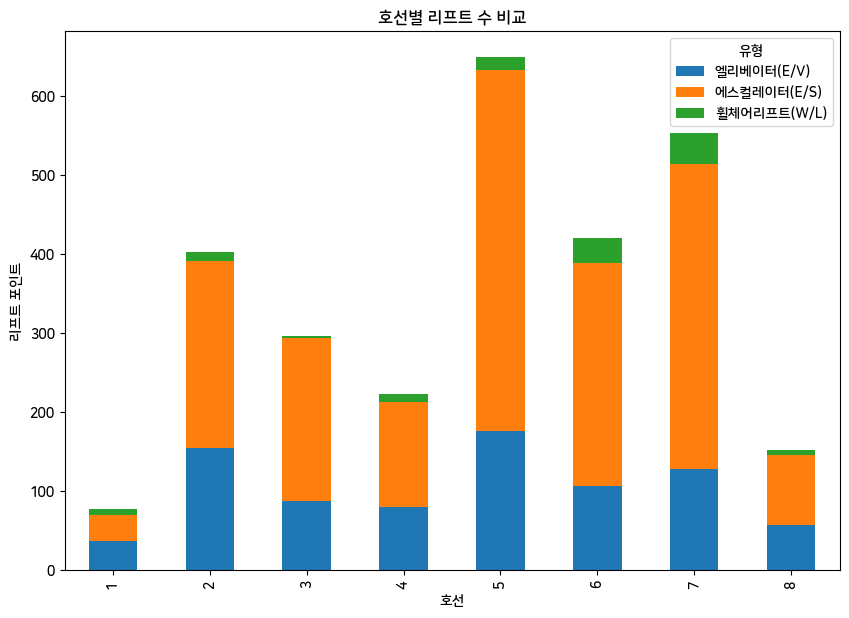

In [ ]:
# 이번엔 호선별로 리프트 포인트(리프트 개수를 단순히 더한 점수)
lift = df_safety.groupby('호선')[['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)']].sum()

# 그래프 그리기
plt.figure(figsize=(10, 7))
lift.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.xlabel('호선')
plt.ylabel('리프트 포인트')
plt.title('호선별 리프트 수 비교')
plt.legend(title='유형')
plt.show()

<Figure size 1200x800 with 0 Axes>

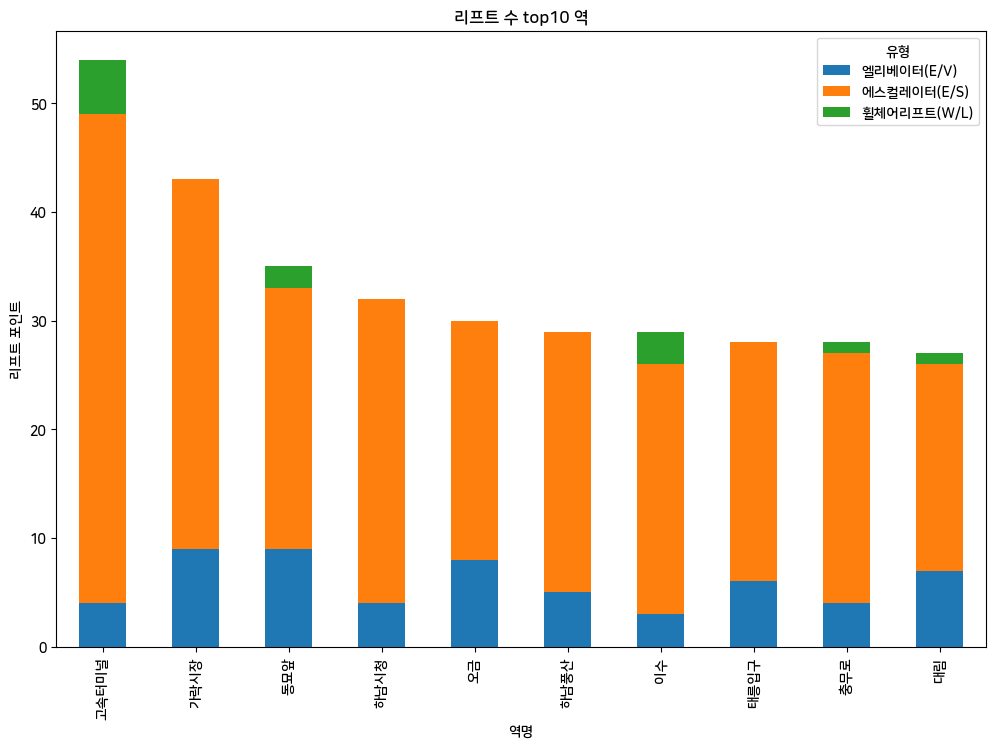

In [ ]:
# 역명으로 리프트들 묶기
lift_station = df_safety.groupby('역명')[['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)']].sum()

# 탑텐
top_10_stations = lift_station.sum(axis=1).sort_values(ascending=False).head(10).index
top_10_data = lift_station.loc[top_10_stations]

# 그래프 그리기
plt.figure(figsize=(12, 8))
top_10_data.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.xlabel('역명')
plt.ylabel('리프트 포인트')
plt.title('리프트 수 top10 역')
plt.legend(title='유형')
plt.show()

<Figure size 1200x800 with 0 Axes>

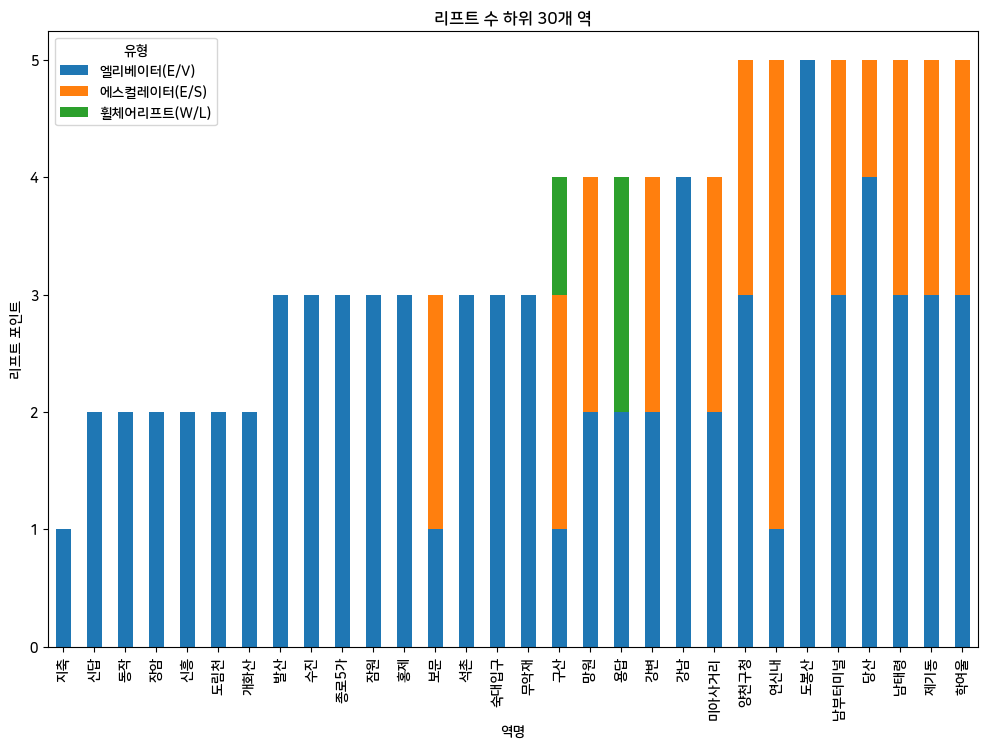

In [ ]:
# 리프트 수 하위 30개 역
bottom_30_stations = lift_station.sum(axis=1).sort_values(ascending=True).head(30).index
bottom_30_data = lift_station.loc[bottom_30_stations]

# 그래프 그리기
plt.figure(figsize=(12, 8))
bottom_30_data.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.xlabel('역명')
plt.ylabel('리프트 포인트')
plt.title('리프트 수 하위 30개 역')
plt.legend(title='유형')
plt.show()

<Figure size 1400x800 with 0 Axes>

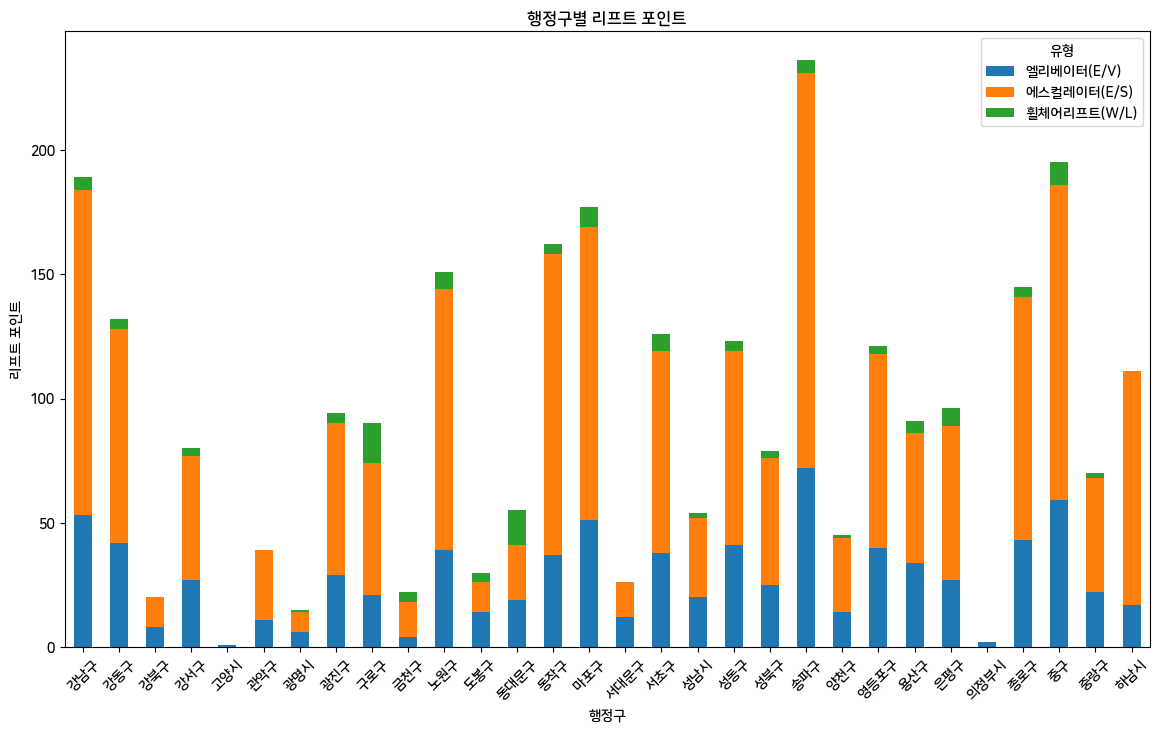

In [ ]:
# 행정구별 리프트 포인트
HJG = df_safety.groupby('행정구')[['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)']].sum()

# 누적 막대 그래프 그리기
plt.figure(figsize=(14, 8))
HJG.plot(kind='bar', stacked=True, figsize=(14, 8))

# 그래프 설정
plt.xlabel('행정구')
plt.ylabel('리프트 포인트')
plt.title('행정구별 리프트 포인트')
plt.legend(title='유형')
plt.xticks(rotation=45)
plt.show()

- 무임하차인원 관련 EDA

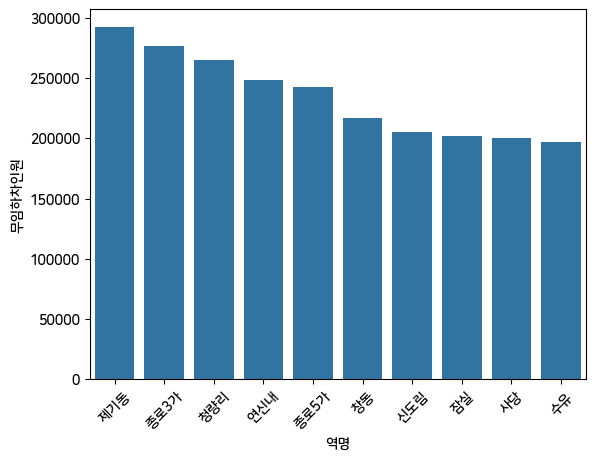

In [ ]:
# 서울에 있는 지하철역만 EDA하기
subway_eda_df_j = subway_eda_df.copy()
subway_eda_df_j = subway_eda_df_j.loc[subway_eda_df_j['도로명주소'].str.contains('서울특별시')]

# 접근성 분석 편의를 위해 시간대 열 제거
subway_eda_df_j = subway_eda_df_j.drop(subway_eda_df_j.filter(like='시간대').columns, axis=1)

# 평균 기준 하차가 많은 인원으로 인기가 많은 역 파악
subway_eda_df_j_top10 = subway_eda_df_j.sort_values(by='무임하차인원', ascending=False).head(10)
sns.barplot(data = subway_eda_df_j_top10, x='역명', y='무임하차인원')
plt.xticks(rotation=45)
plt.show()


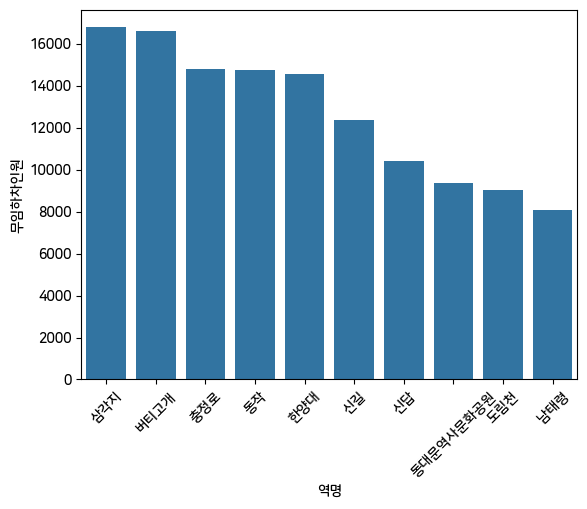

In [ ]:
# 평균 기준 하차가 적은 인원으로 인기가 없는 역을 알아보자.
subway_eda_df_j_top10= subway_eda_df_j.sort_values(by='무임하차인원', ascending=False).tail(10)
sns.barplot(data = subway_eda_df_j_top10, x='역명', y='무임하차인원')
plt.xticks(rotation=45)
plt.show()

<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-38-14532c653501>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


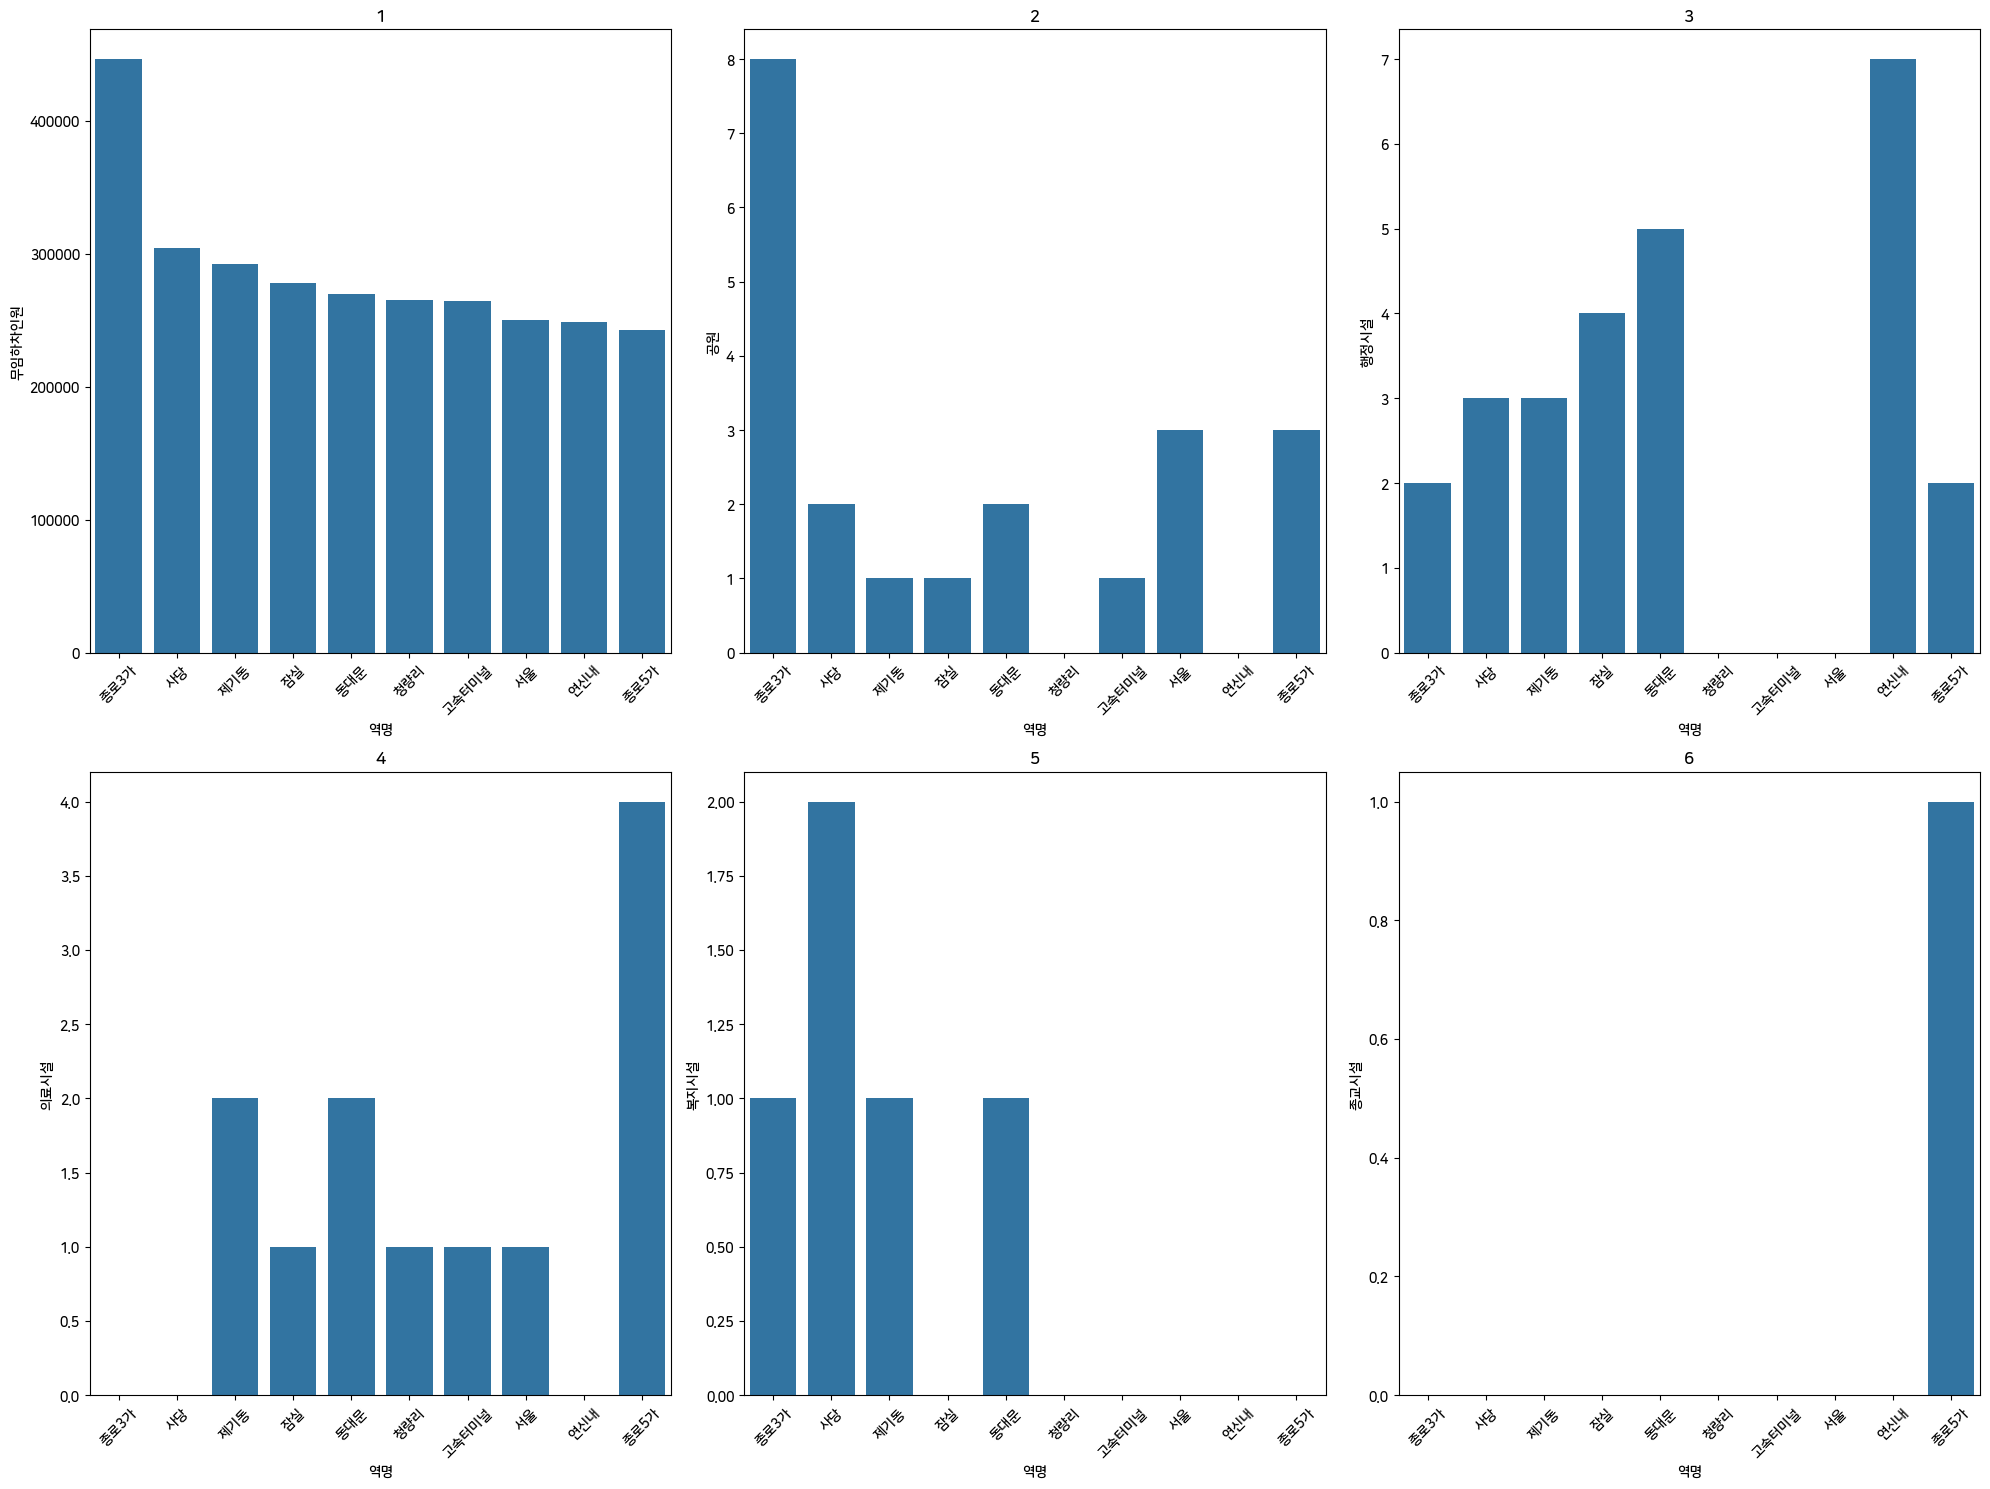

In [ ]:
# 역별로 무임하차인원과 관련되어 있을 것 같은 시설들 수가 기록된 데이터프레임 만들기 (무임하차인원 합 버전)
subway_eda_df_j_station =  subway_eda_df_j.groupby('역명')[['무임하차인원','공원','행정시설','의료시설','복지시설','종교시설']].sum().reset_index().sort_values(by='무임하차인원', ascending=False)

fig, axes = plt.subplots(2,3, figsize=(20,15))
for i, ax in enumerate(axes.flat):
  sns.barplot(data = subway_eda_df_j_station.head(10), x='역명', y=subway_eda_df_j_station.head(10)[subway_eda_df_j_station.head(10).columns[i+1]], ax=ax)
  ax.set_title(f'{i+1}')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.tight_layout()

plt.show()

<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-39-e014be7bcc2e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


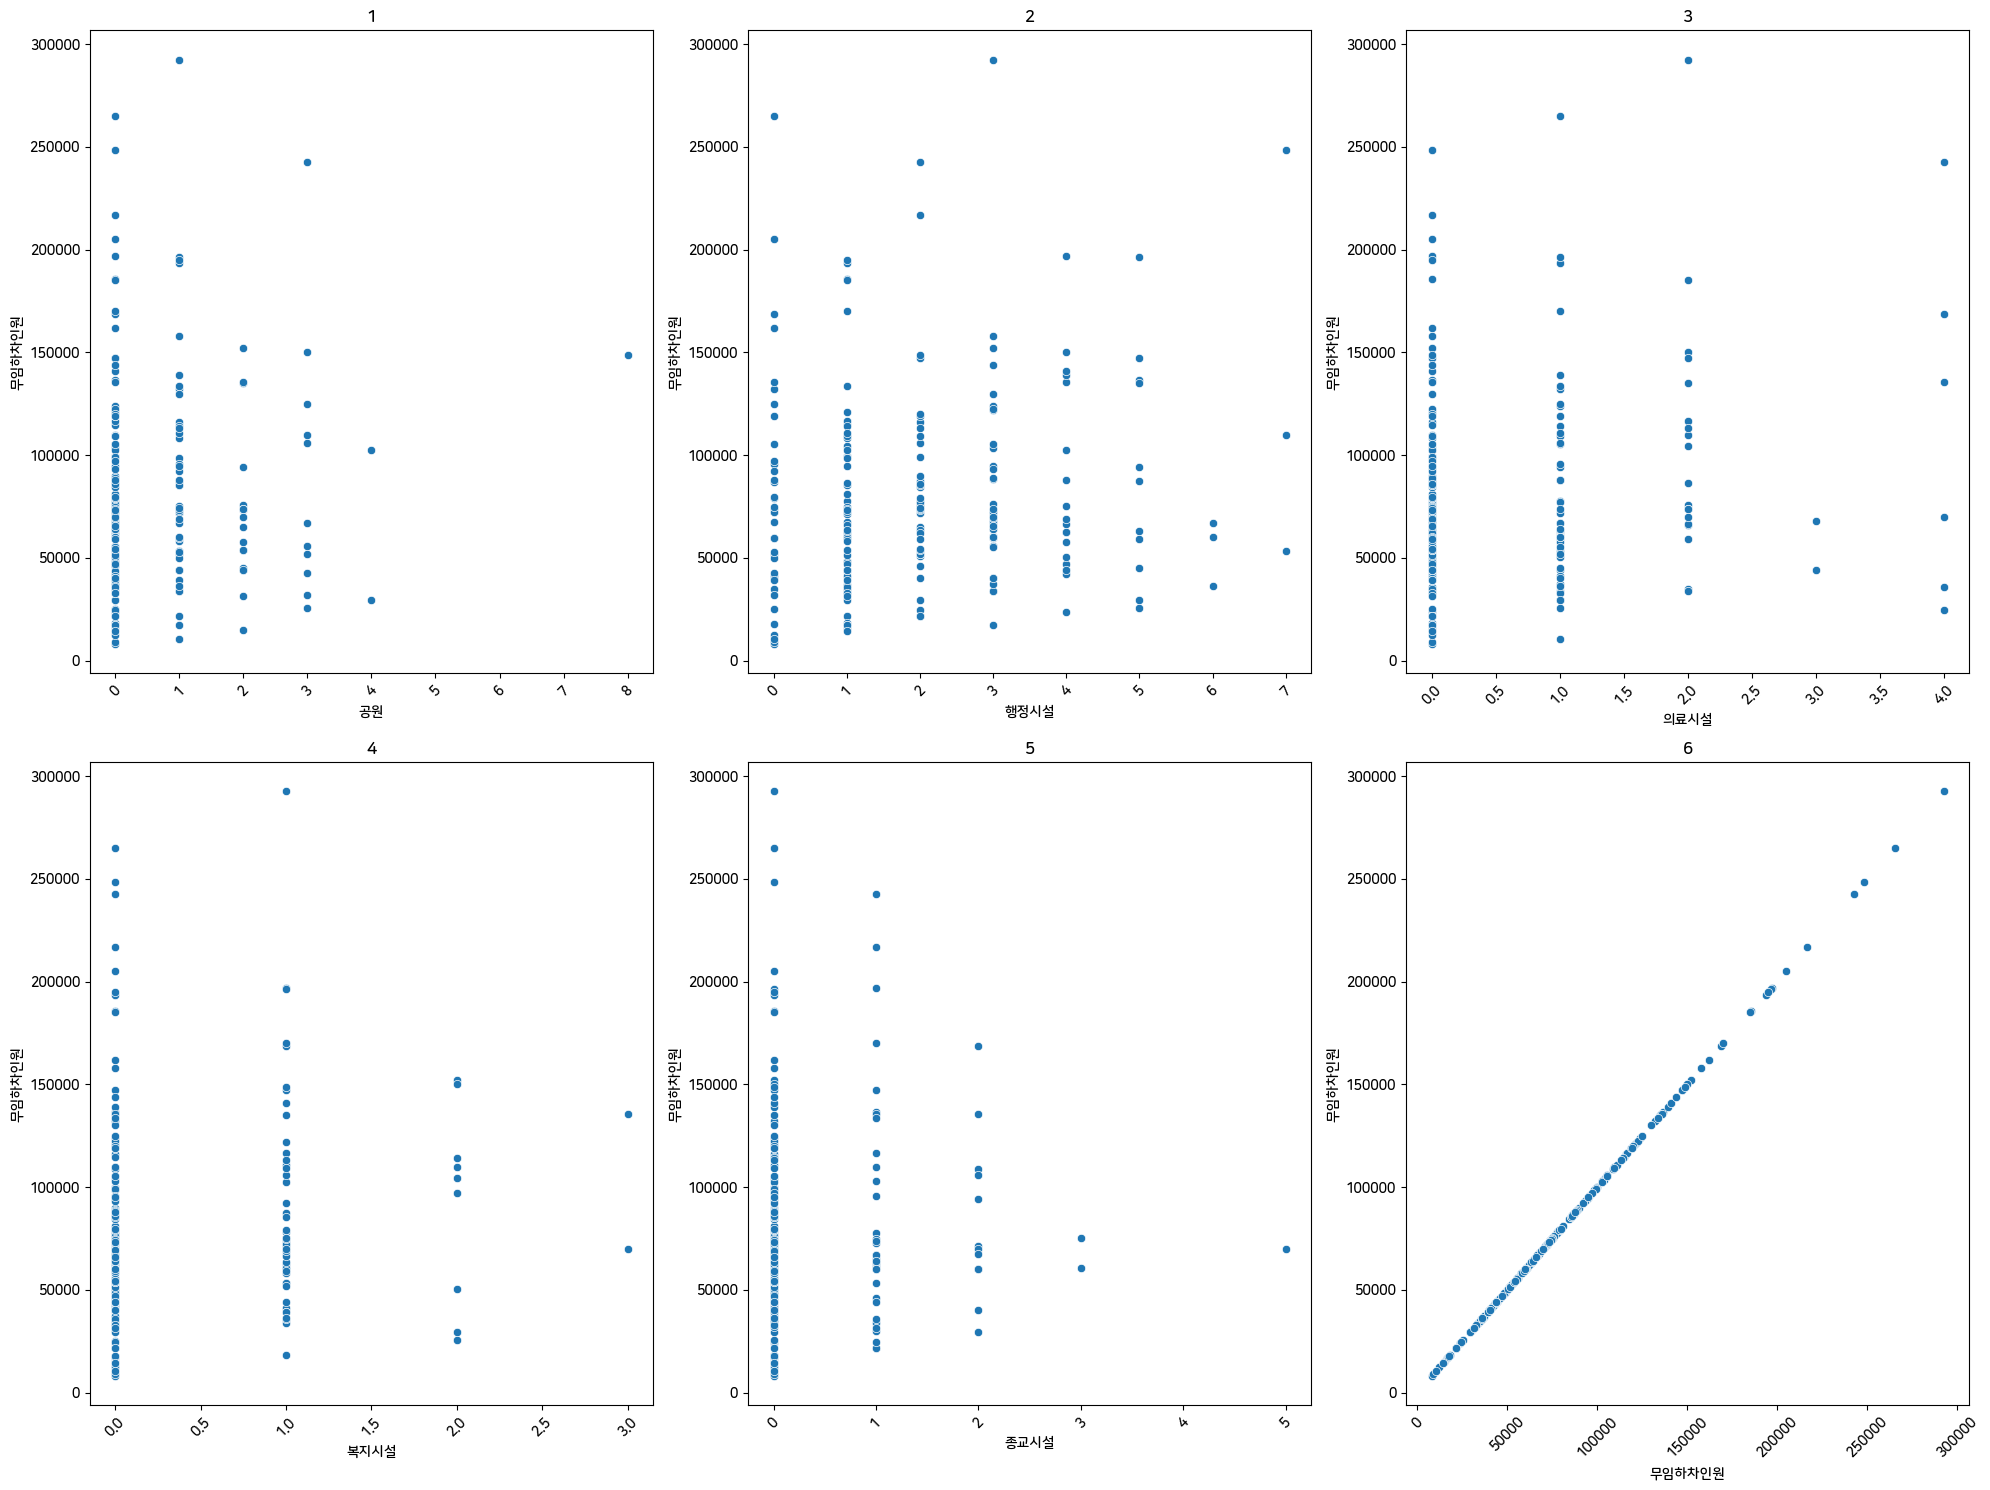

In [ ]:
# 역별로 무임하차인원과 관련되어 있을 것 같은 시설들 수가 기록된 데이터프레임 만들기 (무임하차인원 평균 버전)
subway_eda_df_j_station2 = subway_eda_df_j.groupby('역명')[['공원','행정시설','의료시설','복지시설','종교시설']].sum().reset_index()
subway_eda_df_j_station2['무임하차인원'] = subway_eda_df_j.groupby('역명')['무임하차인원'].mean().values

fig, axes = plt.subplots(2,3, figsize=(20,15))
for i, ax in enumerate(axes.flat):
  sns.scatterplot(data = subway_eda_df_j_station2, x=subway_eda_df_j_station2[subway_eda_df_j_station2.columns[i+1]], y=subway_eda_df_j_station2['무임하차인원'], ax=ax)
  ax.set_title(f'{i+1}')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.tight_layout()

plt.show()

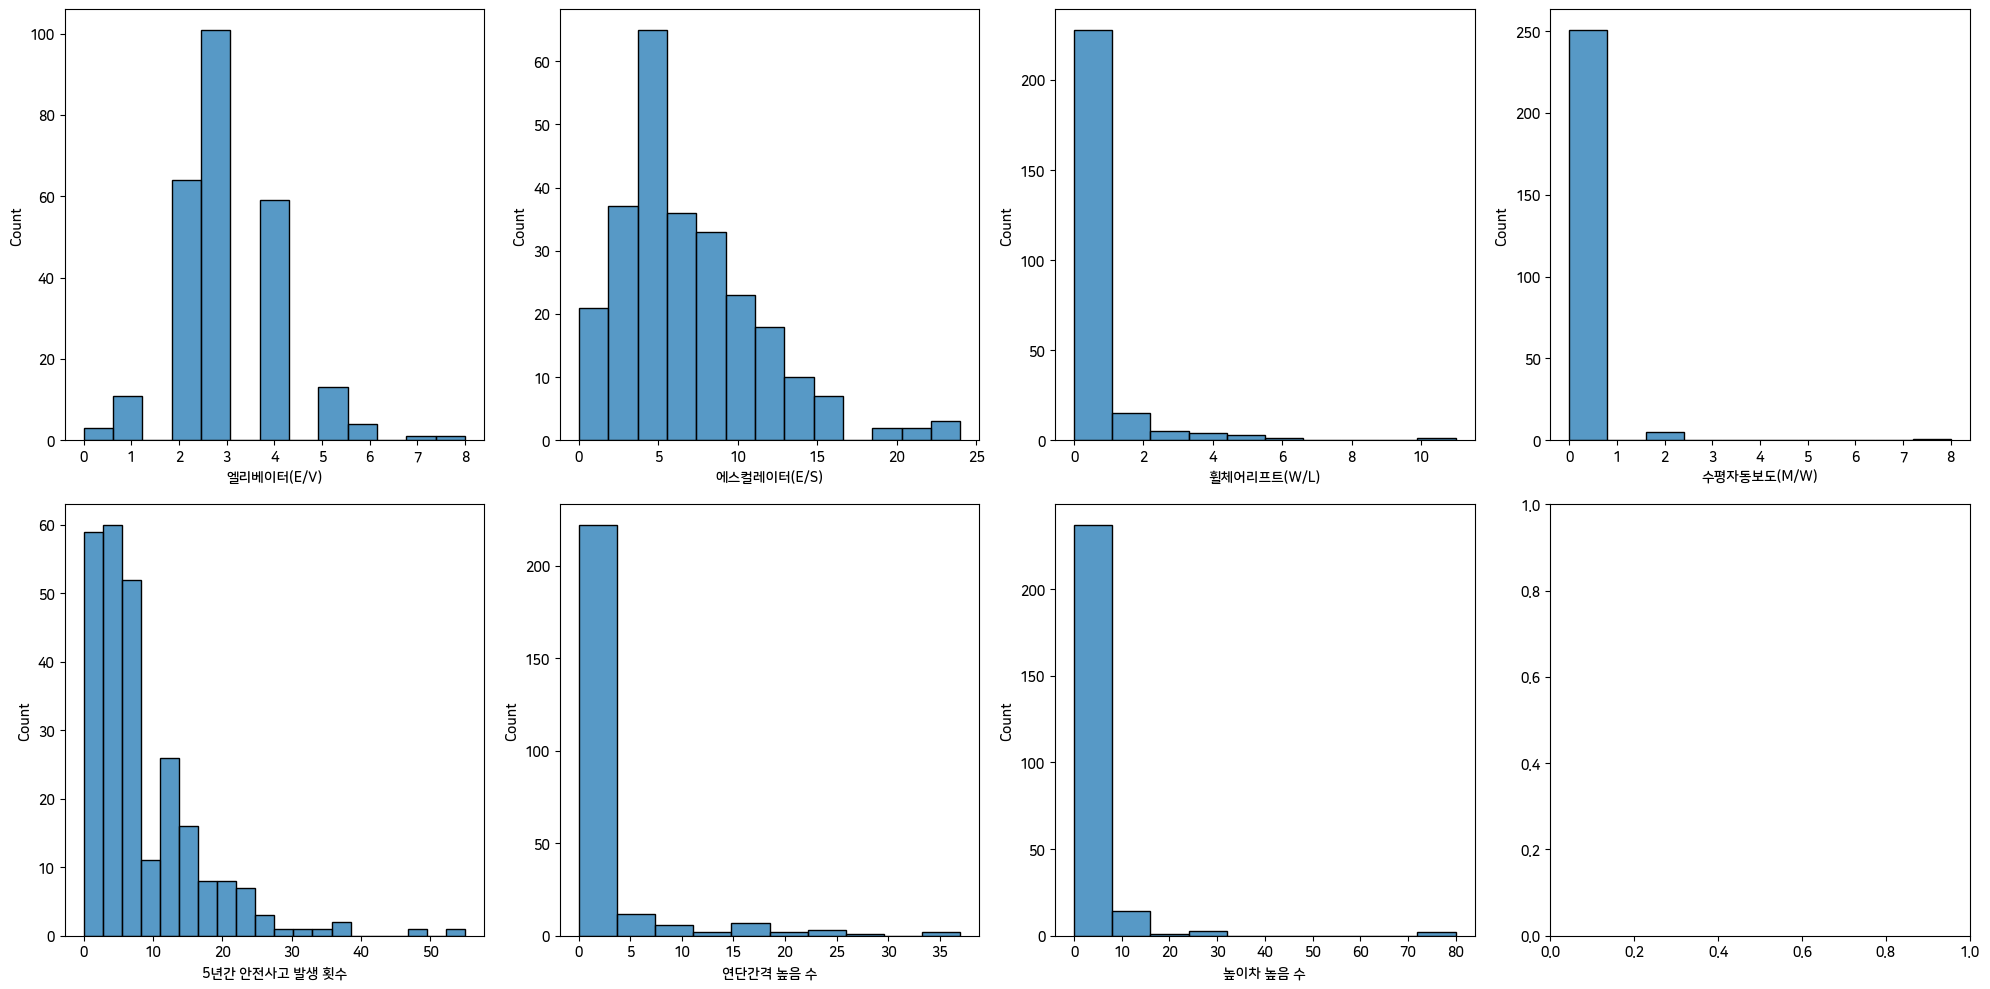

In [ ]:
# 안전 관련 데이터 불러오기
station_safe = subway_eda_df_j.iloc[:,:18]
station_safe.drop(['도로명주소','지번주소','행정구','위도','경도'], axis = 1, inplace=True)
safe = station_safe.groupby('역명')[['5년간 안전사고 발생 횟수','엘리베이터(E/V)','에스컬레이터(E/S)','연단간격 높음 수','높이차 높음 수']].sum().reset_index()
safe['무임하차인원'] = station_safe.groupby('역명')['무임하차인원'].mean().values

fig, axes = plt.subplots(2,4, figsize = (20,10))
sns.histplot(data = station_safe, x = '엘리베이터(E/V)', ax = axes[0,0])
sns.histplot(data = station_safe, x = '에스컬레이터(E/S)', ax = axes[0,1])
sns.histplot(data = station_safe, x = '휠체어리프트(W/L)', ax = axes[0,2])
sns.histplot(data = station_safe, x = '수평자동보도(M/W)', ax = axes[0,3])
sns.histplot(data = station_safe, x = '5년간 안전사고 발생 횟수', ax = axes[1,0])
sns.histplot(data = station_safe, x = '연단간격 높음 수', ax = axes[1,1])
sns.histplot(data = station_safe, x = '높이차 높음 수', ax = axes[1,2])
plt.tight_layout()


plt.show()

- 승하차인원에 대한 지표 만들기 : 지하철역 승하차인원과 상관관계 분석

In [ ]:
subway_eda_df_s = subway_eda_df.copy()

correlation = subway_eda_df_s[['호선', '엘리베이터(E/V)','에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)',
                  '5년간 안전사고 발생 횟수','연단간격 높음 수', '높이차 높음 수',
                  '유임승차인원', '유임하차인원', '무임승차인원', '무임하차인원',
                  '전통시장수(500m이내)','총승하차인원','공원', '복지시설', '의료시설','행정시설']].corr()

# 승하차인원과 상관계수 출력
correlation['총승하차인원'].sort_values(ascending=False).head(50)

,총승하차인원
총승하차인원,1.000000
무임하차인원,0.989789
무임승차인원,0.986114
5년간 안전사고 발생 횟수,0.569340
유임승차인원,0.550572
유임하차인원,0.529638
전통시장수(500m이내),0.380592
공원,0.235101
의료시설,0.212103
행정시설,0.209779


In [ ]:
# 엑셀로작업한 추가분석용 변수추가
#    - 지하철역별 (법정동, 환승가능여부(가능=1, 불가=0), 평균환승거리_m, 평균환승소요시간(초), 노인복지시설, 경로당, 승차노인비, 하차노인비)
subway_eda_df2 = pd.read_csv('/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/지하철역별_데이터결합본_ver2.csv' , encoding ='utf-8-sig')
subway_eda_df2

,호선,역명,도로명주소,지번주소,행정구,위도,경도,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W),5년간 안전사고 발생 횟수,연단간격 높음 수,높이차 높음 수,유임승차인원,유임하차인원,무임승차인원,무임하차인원,역코드,일요일-승차-06-07시간대,일요일-승차-06시간대이전,일요일-승차-07-08시간대,일요일-승차-08-09시간대,일요일-승차-09-10시간대,일요일-승차-10-11시간대,일요일-승차-11-12시간대,일요일-승차-12-13시간대,일요일-승차-13-14시간대,일요일-승차-14-15시간대,일요일-승차-15-16시간대,일요일-승차-16-17시간대,일요일-승차-17-18시간대,일요일-승차-18-19시간대,일요일-승차-19-20시간대,일요일-승차-20-21시간대,일요일-승차-21-22시간대,일요일-승차-22-23시간대,일요일-승차-23-24시간대,일요일-승차-24시간대이후,일요일-하차-06-07시간대,일요일-하차-06시간대이전,일요일-하차-07-08시간대,일요일-하차-08-09시간대,일요일-하차-09-10시간대,일요일-하차-10-11시간대,일요일-하차-11-12시간대,일요일-하차-12-13시간대,일요일-하차-13-14시간대,일요일-하차-14-15시간대,일요일-하차-15-16시간대,일요일-하차-16-17시간대,일요일-하차-17-18시간대,일요일-하차-18-19시간대,일요일-하차-19-20시간대,일요일-하차-20-21시간대,일요일-하차-21-22시간대,일요일-하차-22-23시간대,일요일-하차-23-24시간대,일요일-하차-24시간대이후,토요일-승차-06-07시간대,토요일-승차-06시간대이전,토요일-승차-07-08시간대,토요일-승차-08-09시간대,토요일-승차-09-10시간대,토요일-승차-10-11시간대,토요일-승차-11-12시간대,토요일-승차-12-13시간대,토요일-승차-13-14시간대,토요일-승차-14-15시간대,토요일-승차-15-16시간대,토요일-승차-16-17시간대,토요일-승차-17-18시간대,토요일-승차-18-19시간대,토요일-승차-19-20시간대,토요일-승차-20-21시간대,토요일-승차-21-22시간대,토요일-승차-22-23시간대,토요일-승차-23-24시간대,토요일-승차-24시간대이후,토요일-하차-06-07시간대,토요일-하차-06시간대이전,토요일-하차-07-08시간대,토요일-하차-08-09시간대,토요일-하차-09-10시간대,토요일-하차-10-11시간대,토요일-하차-11-12시간대,토요일-하차-12-13시간대,토요일-하차-13-14시간대,토요일-하차-14-15시간대,토요일-하차-15-16시간대,토요일-하차-16-17시간대,토요일-하차-17-18시간대,토요일-하차-18-19시간대,토요일-하차-19-20시간대,토요일-하차-20-21시간대,토요일-하차-21-22시간대,토요일-하차-22-23시간대,토요일-하차-23-24시간대,토요일-하차-24시간대이후,평일-승차-06-07시간대,평일-승차-06시간대이전,평일-승차-07-08시간대,평일-승차-08-09시간대,평일-승차-09-10시간대,평일-승차-10-11시간대,평일-승차-11-12시간대,평일-승차-12-13시간대,평일-승차-13-14시간대,평일-승차-14-15시간대,평일-승차-15-16시간대,평일-승차-16-17시간대,평일-승차-17-18시간대,평일-승차-18-19시간대,평일-승차-19-20시간대,평일-승차-20-21시간대,평일-승차-21-22시간대,평일-승차-22-23시간대,평일-승차-23-24시간대,평일-승차-24시간대이후,평일-하차-06-07시간대,평일-하차-06시간대이전,평일-하차-07-08시간대,평일-하차-08-09시간대,평일-하차-09-10시간대,평일-하차-10-11시간대,평일-하차-11-12시간대,평일-하차-12-13시간대,평일-하차-13-14시간대,평일-하차-14-15시간대,평일-하차-15-16시간대,평일-하차-16-17시간대,평일-하차-17-18시간대,평일-하차-18-19시간대,평일-하차-19-20시간대,평일-하차-20-21시간대,평일-하차-21-22시간대,평일-하차-22-23시간대,평일-하차-23-24시간대,평일-하차-24시간대이후,총승하차인원,전통시장수(500m이내),공원,행정시설,의료시설,복지시설,종교시설,법정동,환승가능여부,평균환승거리_m,평균환승소요시간(초),노인복지시설,경로당,승차노인비,하차노인비
0,1,서울,서울특별시 중구 세종대로 지하2(남대문로 5가),서울특별시 중구 남대문로5가 73-6 서울역(1호선),중구,37.556228,126.972135,4,5,1,0,32,18,3,1.352300e+06,1.293385e+06,206374.25000,196831.16670,150,52,62,60,99,160,221,246,267,264,261,272,268,263,218,200,142,122,70,19,2,159,42,124,144,208,243,218,236,259,274,281,257,211,164,129,80,48,23,16,2,72,86,143,141,226,309,429,410,388,436,468,505,426,299,262,193,156,89,25,2,368,66,251,236,343,425,499,459,409,381,379,357,309,202,151,106,71,36,22,2,88,105,184,206,268,344,464,476,501,514,617,582,513,337,236,177,147,77,26,5,311,92,291,340,452,468,501,465,448,428,453,400,295,211,152,98,67,32,17,5,27916,0,3,0,1,0,0,남대문로5가,1,223,186,2,3,13.24,13.21
1,1,시청,서울특별시 중구 세종대로 지하101(정동),서울특별시 중구 정동 5-5 시청역(1호선),중구,37.565715,126.977088,3,3,0,0,14,0,4,6.468570e+05,6.525868e+05,95633.91667,94057.08333,151,22,26,16,18,29,39,70,106,130,155,184,158,142,85,62,50,29,18,4,0,59,23,55,63,119,145,162,136,131,126,94,66,48,29,19,17,11,4,3,1,26,23,27,29,44,62,90,117,173,280,363,372,334,284,246,154,83,38,9,0,127,28,67,77,131,193,324,315,331,325,307,298,200,82,33,22,14,8,4,1,33,36,32,34,62,93,146,163,223,339,412,332,263,165,122,114,94,38,8,1,101,65,134,199,253,275,317,286,248,210,167,130,108,68,30,22,15,6,3,1,13643,0,2,1,2,0,0,정동,1,101,84,0,1,12.88,12.60
2,1,종각,서울특별시 종로구 종로 지하55(종로1가),서울특별시 종로구 종로1가 54 종각역(1호선),종로구,37.570161,126.982923,4,2,0,0,9,0,0,9.480284e+05,9.315643e+05,145220.50000,135780.91670,152,33,26,26,28,46,64,96,169,191,210,255,243,179,142,112,88,58,31,6,0,77,24,72,90,145,222,243,214,177,153,121,98,72,45,32,20,12,7,3,0,34,29,37,58,70,120,167,242,293,357,414,389,357,229,232,195,148,69,17,1,127,32,111,149,275,300,465,389,291,270,234,222,157,76,48,31,20,10,4,0,37,33,42,52,93,170,246,303,387,545,661,524,350,255,206,185,161,82,20,1,158,79,171,310,463,480,493,420,354,304,240,204,189,103,55,36,20,10,4,1,18946,0,0,0,0,0,1,종로1가,0,0,0,0,0,13.28,12.72
3,1,종로3가,서울특별시 종로구 종로 지하129(종로3가),서울

- 지표수립 초안

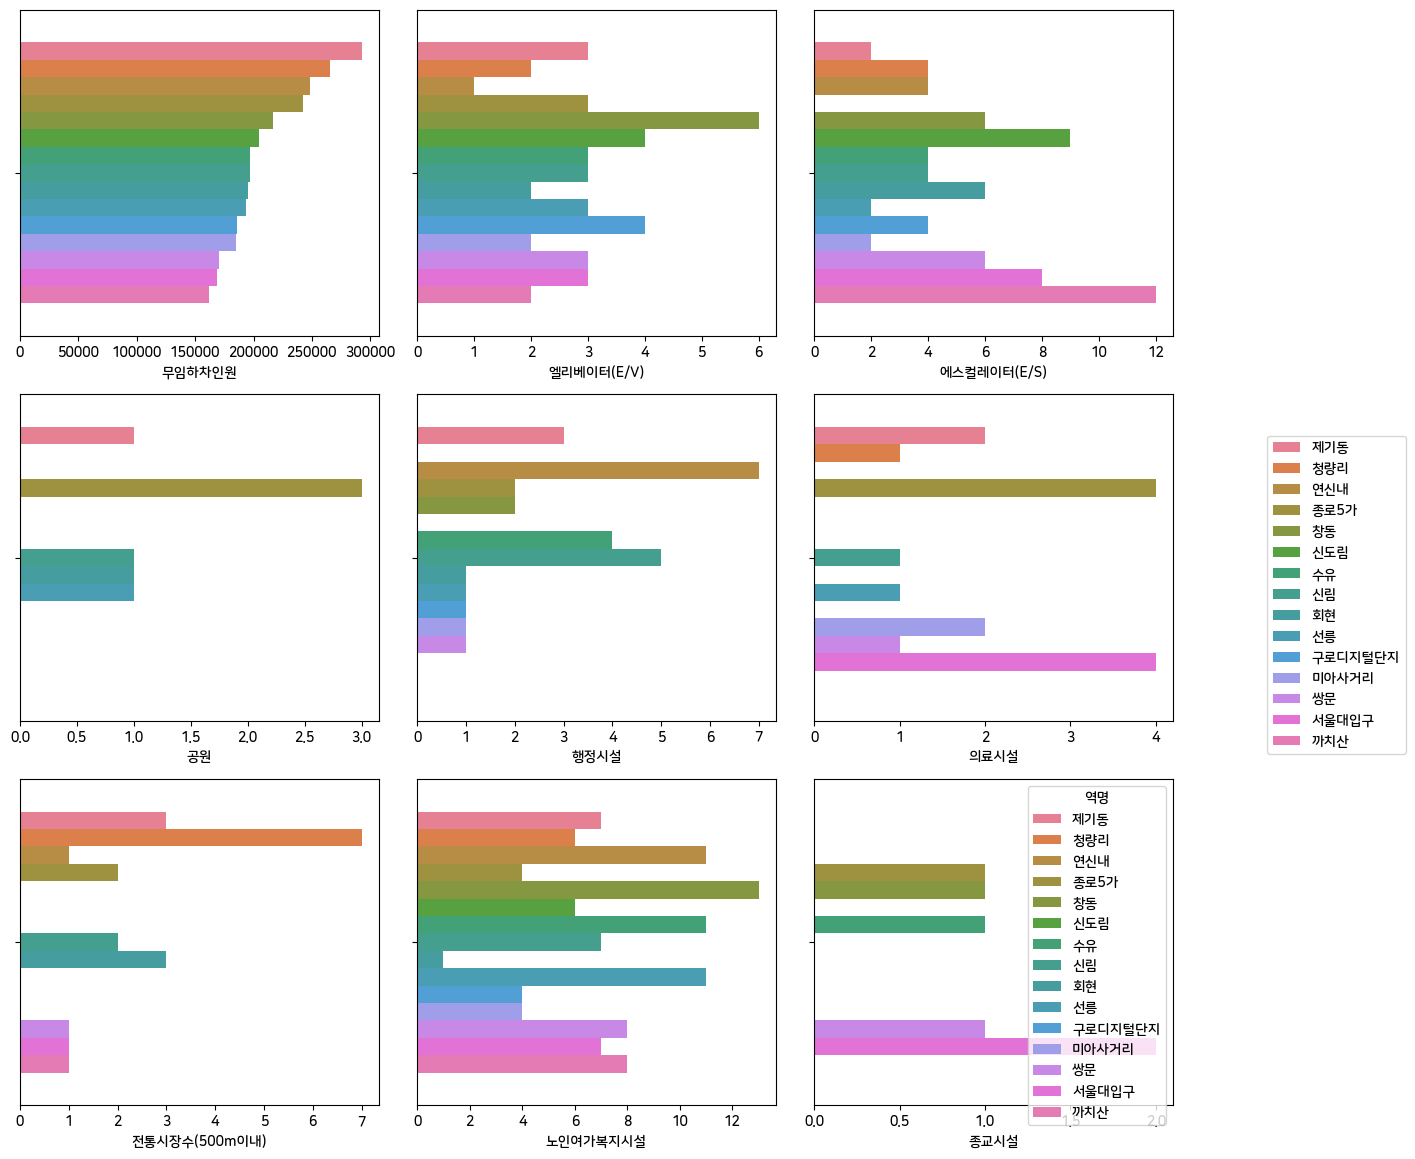

In [ ]:
raw = subway_eda_df2.copy()
raw['노인여가복지시설'] = raw['노인복지시설'] + raw['경로당']

# 무임하차인원이 많은 역, 적은 역 선정하기
top15 = ['제기동','청량리','연신내','종로5가', '창동', '신도림','수유','신림','회현','선릉','구로디지털단지','미아사거리','쌍문','서울대입구','까치산']
bottom15 = ['남태령','장암','도림천','신답','신길','한양대','동작','버티고개','용답','학여울','한강진','녹사평','창신','상수','도곡']

# 무임하차인원이 많은 역 특징 살펴보기
sum_columns = raw.select_dtypes(include='number').columns.drop('무임하차인원')  # sum을 적용할 열

# agg 함수에서 딕셔너리 생성
agg_dict = {col: 'sum' for col in sum_columns}
agg_dict['무임하차인원'] = 'mean'  # 'value1'에는 mean을 적용

# 그룹화하면서 집계 함수 적용
grouped = raw.groupby('역명').agg(agg_dict).reset_index()

top_15 = grouped.sort_values(by = '무임하차인원', ascending = False).head(15)
top_15 = top_15[['역명','무임하차인원','엘리베이터(E/V)','에스컬레이터(E/S)','공원','행정시설', '의료시설','전통시장수(500m이내)','노인여가복지시설','종교시설']]
# grouped['무임하차인원'] = raw.groupby('역명')['무임하차인원'].mean().reset_index()['무임하차인원']
# top_15 = grouped.loc[grouped['역명'].isin(top15), ['역명','무임하차인원','엘리베이터(E/V)','에스컬레이터(E/S)','공원','행정시설', '의료시설','전통시장수(500m이내)','노인여가복지시설','종교시설']]

# 무임승차인원이 많은 역 시각화
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

sns.barplot(data = top_15, x = '무임하차인원', hue = '역명', ax = axes[0,0], legend=False)
sns.barplot(data = top_15, x = '엘리베이터(E/V)', hue = '역명', ax = axes[0,1], legend=False)
sns.barplot(data = top_15, x = '에스컬레이터(E/S)', hue = '역명', ax = axes[0,2], legend=False)
sns.barplot(data = top_15, x = '공원', hue = '역명', ax = axes[1,0], legend=False)
sns.barplot(data = top_15, x = '행정시설', hue = '역명', ax = axes[1,1], legend=False)
sns.barplot(data = top_15, x = '의료시설', hue = '역명', ax = axes[1,2],legend=False)
sns.barplot(data = top_15, x = '전통시장수(500m이내)', hue = '역명', ax = axes[2,0],legend=False)
sns.barplot(data = top_15, x = '노인여가복지시설', hue = '역명', ax = axes[2,1],legend=False)
sns.barplot(data = top_15, x = '종교시설', hue = '역명', ax = axes[2,2])

handles, labels = axes[2,2].get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
# 무임하차인원이 적은 역 특징 살펴보기
bottom_15 = grouped.sort_values(by = '무임하차인원', ascending = True).head(15)
bottom_15 = bottom_15[['역명','무임하차인원','엘리베이터(E/V)','에스컬레이터(E/S)','공원','행정시설', '의료시설','전통시장수(500m이내)','노인여가복지시설','종교시설']]
bottom_15

,역명,무임하차인원,엘리베이터(E/V),에스컬레이터(E/S),공원,행정시설,의료시설,전통시장수(500m이내),노인여가복지시설,종교시설
40,남태령,8092.250000,3,2,0,0,0,0,1,0
196,장암,9041.416670,2,0,0,0,0,0,0,0
56,도림천,9044.833330,2,0,0,0,0,0,5,0
136,신답,10418.000000,2,0,1,0,1,0,6,0
135,신길,12352.583330,6,9,0,0,0,0,7,0
229,한양대,14573.333330,2,2,0,1,0,0,0,0
65,동작,14752.833330,2,0,2,1,0,0,0,0
96,버티고개,16592.083330,5,4,0,1,0,0,4,0
176,용답,17286.583330,2,0,1,3,0,0,9,0
226,학여울,17409.416670,3,2,0,1,0,0,2,0


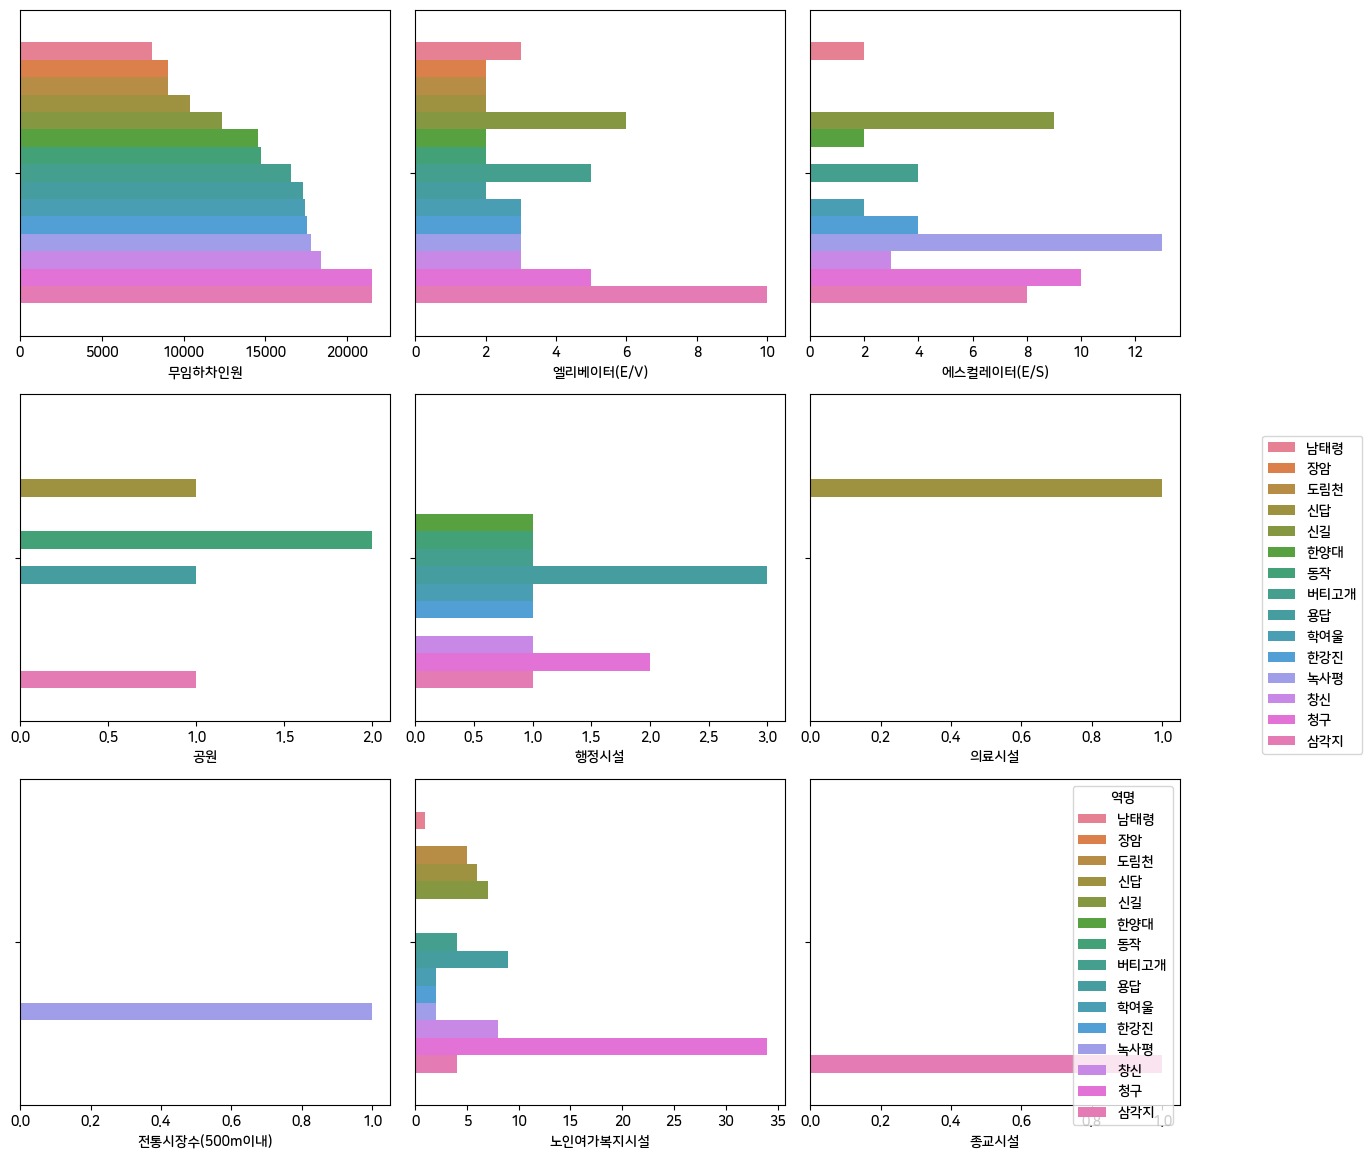

In [ ]:
# 무임승차인원이 적은 역 시각화
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

sns.barplot(data = bottom_15, x = '무임하차인원', hue = '역명', ax = axes[0,0],legend=False)
sns.barplot(data = bottom_15, x = '엘리베이터(E/V)', hue = '역명', ax = axes[0,1], legend=False)
sns.barplot(data = bottom_15, x = '에스컬레이터(E/S)', hue = '역명', ax = axes[0,2], legend=False)
sns.barplot(data = bottom_15, x = '공원', hue = '역명', ax = axes[1,0], legend=False)
sns.barplot(data = bottom_15, x = '행정시설', hue = '역명', ax = axes[1,1], legend=False)
sns.barplot(data = bottom_15, x = '의료시설', hue = '역명', ax = axes[1,2],legend=False)
sns.barplot(data = bottom_15, x = '전통시장수(500m이내)', hue = '역명', ax = axes[2,0],legend=False)
sns.barplot(data = bottom_15, x = '노인여가복지시설', hue = '역명', ax = axes[2,1],legend=False)
sns.barplot(data = bottom_15, x = '종교시설', hue = '역명', ax = axes[2,2])

handles, labels = axes[2,2].get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
# 안전과 관련된 지표 살펴보기 - 안전사고 많은 역
grouped = raw.groupby('역명')[raw.select_dtypes(include='number').columns].sum().reset_index()
accidents_top_15 = grouped.sort_values(by = '5년간 안전사고 발생 횟수', ascending = False).head(15)
accidents_top_15 = accidents_top_15[['역명','5년간 안전사고 발생 횟수','무임하차인원','엘리베이터(E/V)','에스컬레이터(E/S)','휠체어리프트(W/L)','수평자동보도(M/W)','연단간격 높음 수','높이차 높음 수','평균환승거리_m']]
accidents_top_15

,역명,5년간 안전사고 발생 횟수,무임하차인원,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W),연단간격 높음 수,높이차 높음 수,평균환승거리_m
62,동대문역사문화공원,94,126848.08334,7,13,2,0,23,0,387
104,사당,71,304306.33330,5,19,1,0,0,8,148
140,신도림,47,205100.75000,4,9,0,0,3,0,81
117,서울,45,250146.66670,6,9,2,0,25,3,446
16,고속터미널,43,264096.50000,4,45,5,0,11,4,404
201,종로3가,38,446392.58337,6,20,1,2,1,13,546
24,구로디지털단지,38,185633.00000,4,4,0,0,0,0,0
23,교대,35,219652.16663,5,4,1,0,0,10,150
133,시청,31,148068.75000,5,7,0,0,7,4,202
61,동대문,31,269835.08330,5,11,0,0,28,3,388


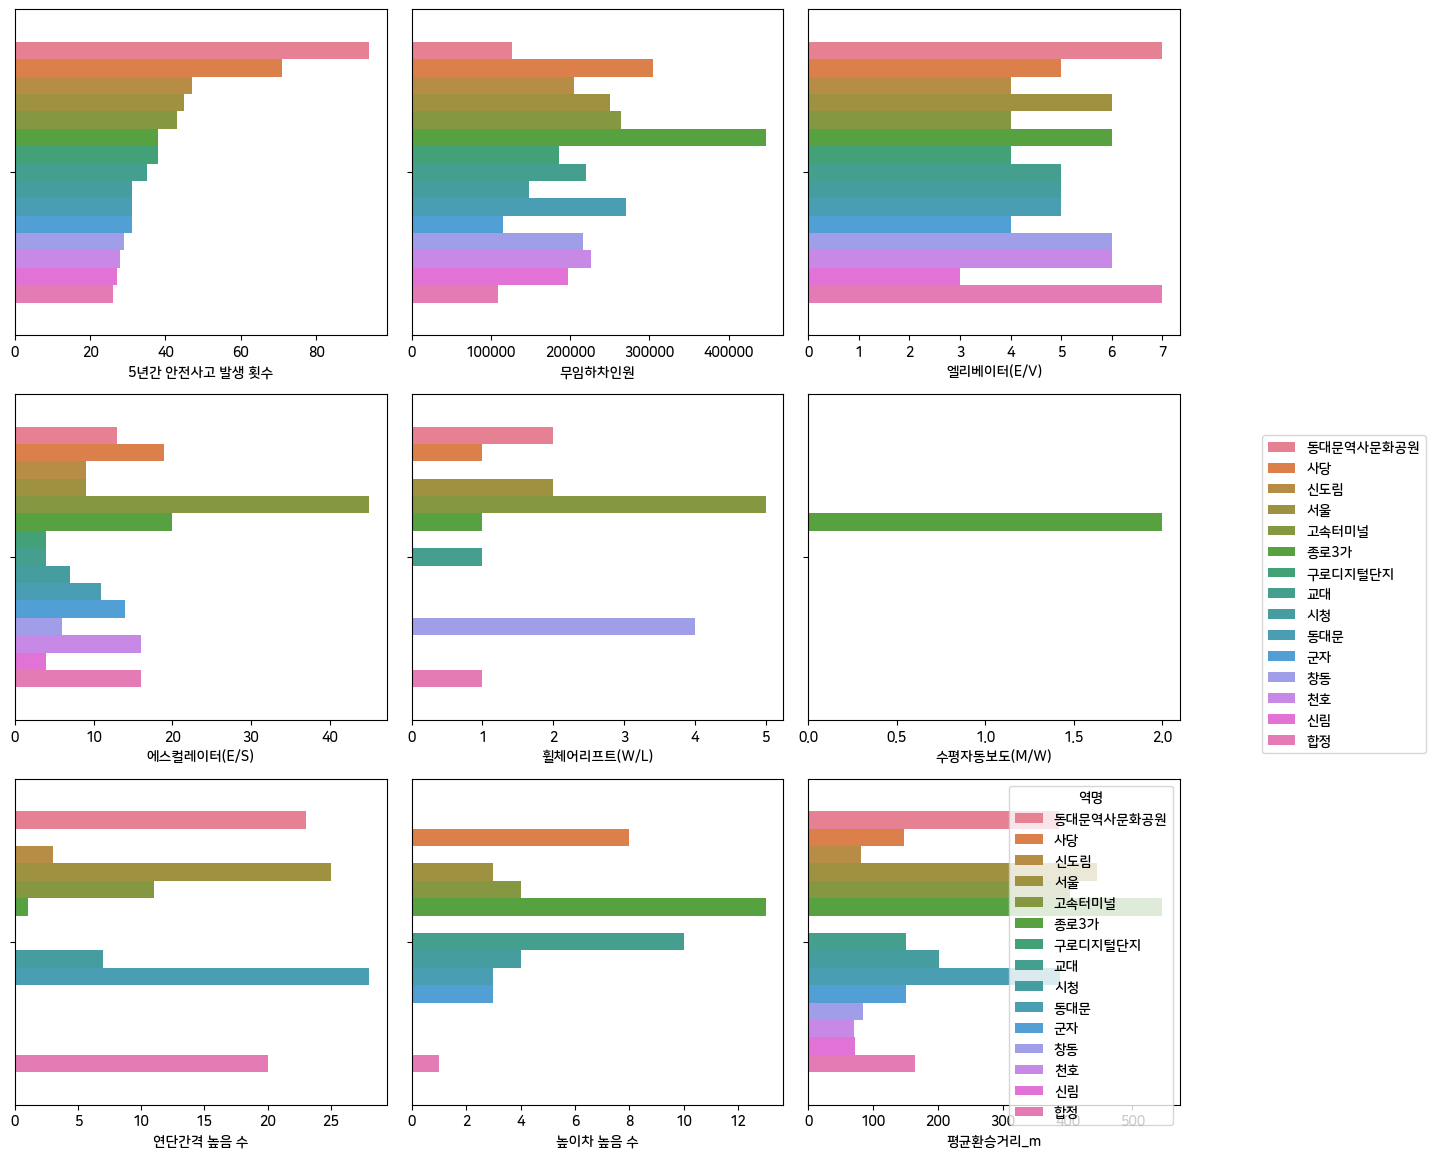

In [ ]:
# 안전사고 많은 역 시각화
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
sns.barplot(data = accidents_top_15, x = '5년간 안전사고 발생 횟수', hue = '역명', ax = axes[0,0],legend=False)
sns.barplot(data = accidents_top_15, x = '무임하차인원', hue = '역명', ax = axes[0,1], legend=False)
sns.barplot(data = accidents_top_15, x = '엘리베이터(E/V)', hue = '역명', ax = axes[0,2], legend=False)
sns.barplot(data = accidents_top_15, x = '에스컬레이터(E/S)', hue = '역명', ax = axes[1,0], legend=False)
sns.barplot(data = accidents_top_15, x = '휠체어리프트(W/L)', hue = '역명', ax = axes[1,1], legend=False)
sns.barplot(data = accidents_top_15, x = '수평자동보도(M/W)', hue = '역명', ax = axes[1,2], legend=False)
sns.barplot(data = accidents_top_15, x = '연단간격 높음 수', hue = '역명', ax = axes[2,0],legend=False)
sns.barplot(data = accidents_top_15, x = '높이차 높음 수', hue = '역명', ax = axes[2,1],legend=False)
sns.barplot(data = accidents_top_15, x = '평균환승거리_m', hue = '역명', ax = axes[2,2])

handles, labels = axes[2,2].get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
# 안전과 관련된 지표 살펴보기 - 안전사고 적은 역
accidents_bottom_15 = grouped.sort_values(by = '5년간 안전사고 발생 횟수', ascending = True).head(15)
accidents_bottom_15 = accidents_bottom_15[['역명','5년간 안전사고 발생 횟수','무임하차인원','엘리베이터(E/V)','에스컬레이터(E/S)','휠체어리프트(W/L)','수평자동보도(M/W)','연단간격 높음 수','높이차 높음 수','평균환승거리_m']]
accidents_bottom_15

,역명,5년간 안전사고 발생 횟수,무임하차인원,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W),연단간격 높음 수,높이차 높음 수,평균환승거리_m
96,버티고개,0,16592.08333,5,4,0,0,0,0,0
149,신흥,0,44255.33333,2,0,0,0,0,0,0
105,산성,0,35268.58333,4,13,0,0,0,0,0
5,강동구청,0,67134.00000,3,5,0,0,0,0,0
136,신답,0,10418.00000,2,0,0,0,12,0,0
60,돌곶이,0,62785.58333,3,4,0,0,0,0,0
130,수진,0,45649.66667,3,0,0,0,0,0,0
111,상수,0,21856.75000,3,10,0,0,0,0,0
186,이대,0,51311.75000,3,4,0,0,0,2,0
227,한강진,0,17551.25000,3,4,0,0,0,0,0


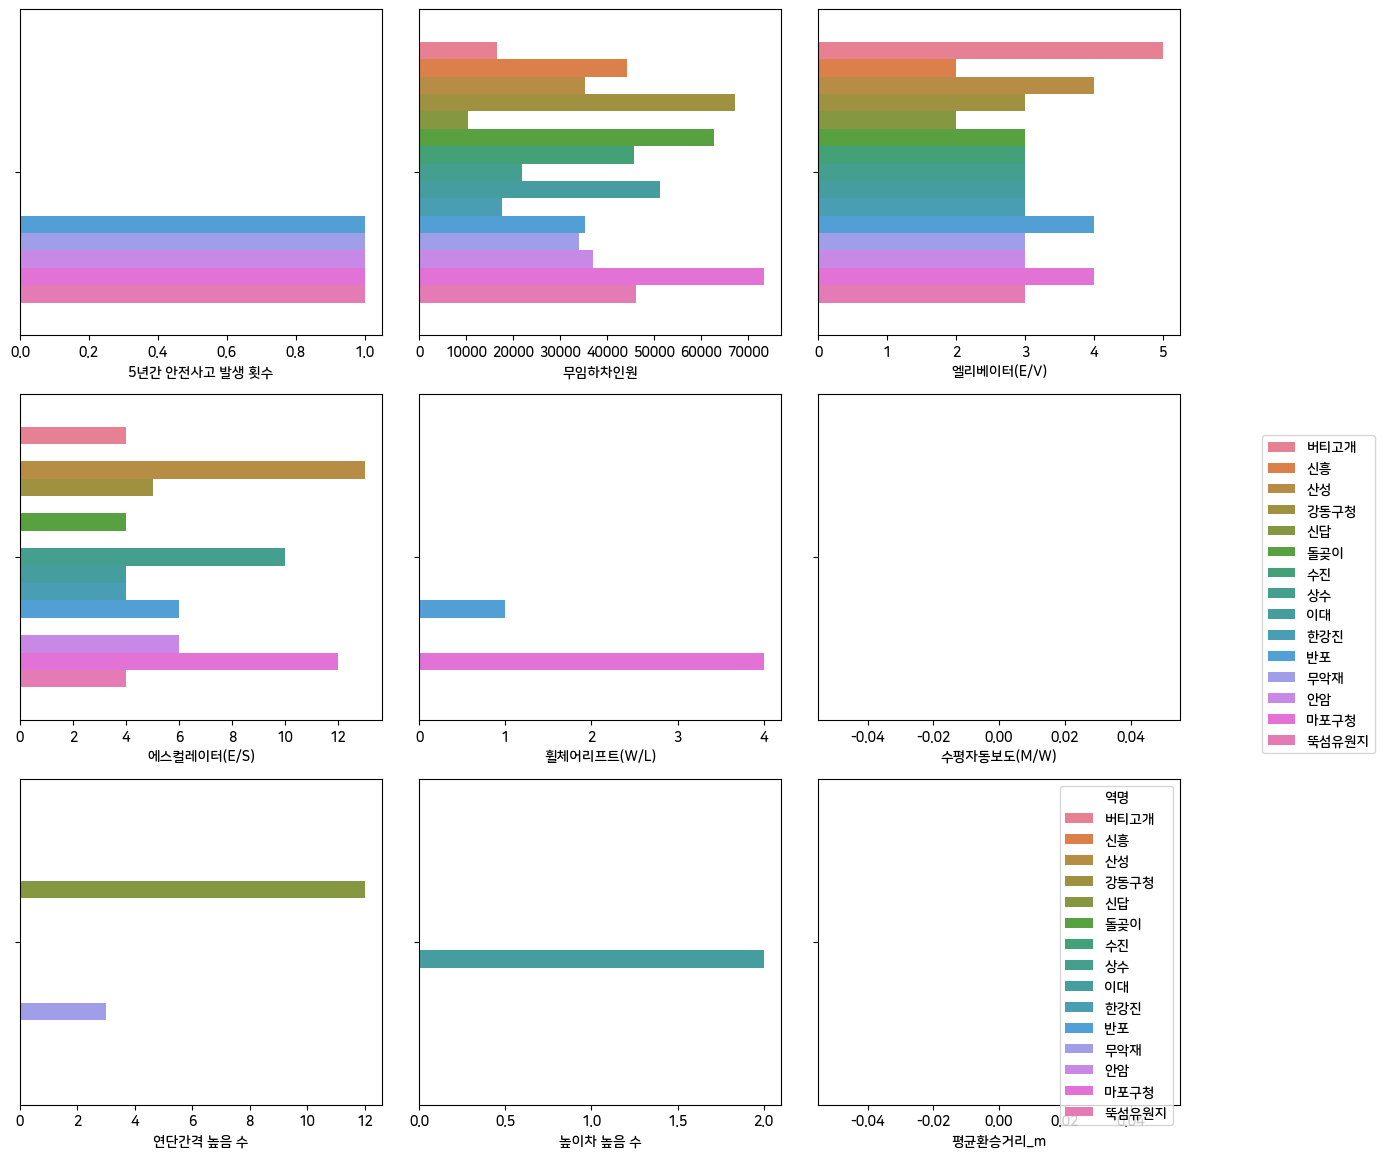

In [ ]:
# 안전사고 적은 역 시각화
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
sns.barplot(data = accidents_bottom_15, x = '5년간 안전사고 발생 횟수', hue = '역명', ax = axes[0,0],legend=False)
sns.barplot(data = accidents_bottom_15, x = '무임하차인원', hue = '역명', ax = axes[0,1], legend=False)
sns.barplot(data = accidents_bottom_15, x = '엘리베이터(E/V)', hue = '역명', ax = axes[0,2], legend=False)
sns.barplot(data = accidents_bottom_15, x = '에스컬레이터(E/S)', hue = '역명', ax = axes[1,0], legend=False)
sns.barplot(data = accidents_bottom_15, x = '휠체어리프트(W/L)', hue = '역명', ax = axes[1,1], legend=False)
sns.barplot(data = accidents_bottom_15, x = '수평자동보도(M/W)', hue = '역명', ax = axes[1,2], legend=False)
sns.barplot(data = accidents_bottom_15, x = '연단간격 높음 수', hue = '역명', ax = axes[2,0],legend=False)
sns.barplot(data = accidents_bottom_15, x = '높이차 높음 수', hue = '역명', ax = axes[2,1],legend=False)
sns.barplot(data = accidents_bottom_15, x = '평균환승거리_m', hue = '역명', ax = axes[2,2])

handles, labels = axes[2,2].get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

- 클러스터링

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   엘리베이터(E/V)  에스컬레이터(E/S)  연단간격 높음 수  높이차 높음 수  전통시장수(500m이내)        공원  \
0    0.218844     0.007127   0.089538  0.345721      -0.063490  0.454105   
1   -0.248255    -0.304322   0.572400  0.037107       0.268524  0.248819   

   노인여가복지시설      종교시설      의료시설  평균환승거리_m  
0 -0.190738  0.473534  0.593195 -0.042167  
1 -0.172911 -0.225672 -0.010918  0.549343  
[0.15406162 0.13089632]


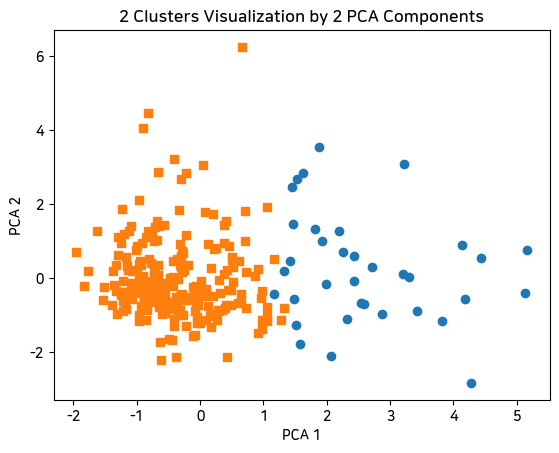

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 클러스터링에 사용할 변수들
clusters =['엘리베이터(E/V)', '에스컬레이터(E/S)', '연단간격 높음 수', '높이차 높음 수','전통시장수(500m이내)', '공원', '노인여가복지시설', '종교시설', '의료시설','평균환승거리_m']

# 독립변수 데이터 선택
X = raw[clusters]

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means 클러스터링 수행 (클러스터 개수는 3으로 설정, 필요시 변경 가능)
kmeans = KMeans(n_clusters=2, init='k-means++')
raw['Cluster'] = kmeans.fit_predict(X_scaled)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_scaled)
print(pd.DataFrame(pca.components_, columns=clusters))
print(pca.explained_variance_ratio_)
raw['pca_x'] = pca_transformed[:,0]
raw['pca_y'] = pca_transformed[:,1]
marker0_ind = raw[raw['Cluster']==0].index
marker1_ind = raw[raw['Cluster']==1].index
plt.scatter(x=raw.loc[marker0_ind,'pca_x'], y=raw.loc[marker0_ind,'pca_y'], marker='o')
plt.scatter(x=raw.loc[marker1_ind,'pca_x'], y=raw.loc[marker1_ind,'pca_y'], marker='s')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2 Clusters Visualization by 2 PCA Components')
plt.show()

- PCA1의 주요 변수: 전통시장 수, 종교시설, 의료시설 --> 접근성

- PCA2의 주요 변수: 에스컬레이터, 연단간격, 평균환승거리_m --> 안전성

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


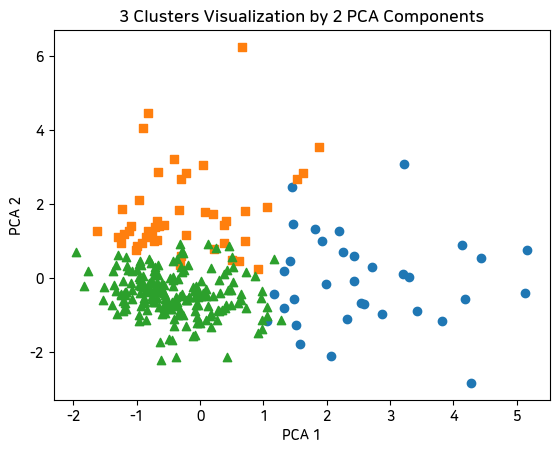

In [ ]:
# K-means 클러스터링 수행 (클러스터 개수는 3으로 설정, 필요시 변경 가능)
kmeans2 = KMeans(n_clusters=3, init='k-means++')
raw['Cluster2'] = kmeans2.fit_predict(X_scaled)

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_scaled)
raw['pca_x2'] = pca_transformed[:,0]
raw['pca_y2'] = pca_transformed[:,1]

marker0_ind = raw[raw['Cluster2']==0].index
marker1_ind = raw[raw['Cluster2']==1].index
marker2_ind = raw[raw['Cluster2']==2].index
plt.scatter(x=raw.loc[marker0_ind,'pca_x'], y=raw.loc[marker0_ind,'pca_y'], marker='o')
plt.scatter(x=raw.loc[marker1_ind,'pca_x'], y=raw.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x=raw.loc[marker2_ind,'pca_x'], y=raw.loc[marker2_ind,'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

- 지표만들어보기 : 위험성 지표
 1. 히스토그램으로 구해보기
  2. 유의한 요인에 회귀계수 값을 곱해서 적용해보기

In [ ]:
# raw 데이터 정규화 실시
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
numeric_columns = grouped.select_dtypes(include=['float64', 'int64']).columns
scaled = minmax.fit_transform(grouped[numeric_columns])
scaled = pd.DataFrame(scaled, columns = numeric_columns)
scaled['역명'] = grouped['역명']
scaled.head()

,호선,위도,경도,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W),5년간 안전사고 발생 횟수,연단간격 높음 수,높이차 높음 수,유임승차인원,유임하차인원,무임승차인원,무임하차인원,역코드,일요일-승차-06-07시간대,일요일-승차-06시간대이전,일요일-승차-07-08시간대,일요일-승차-08-09시간대,일요일-승차-09-10시간대,일요일-승차-10-11시간대,일요일-승차-11-12시간대,일요일-승차-12-13시간대,일요일-승차-13-14시간대,일요일-승차-14-15시간대,일요일-승차-15-16시간대,일요일-승차-16-17시간대,일요일-승차-17-18시간대,일요일-승차-18-19시간대,일요일-승차-19-20시간대,일요일-승차-20-21시간대,일요일-승차-21-22시간대,일요일-승차-22-23시간대,일요일-승차-23-24시간대,일요일-승차-24시간대이후,일요일-하차-06-07시간대,일요일-하차-06시간대이전,일요일-하차-07-08시간대,일요일-하차-08-09시간대,일요일-하차-09-10시간대,일요일-하차-10-11시간대,일요일-하차-11-12시간대,일요일-하차-12-13시간대,일요일-하차-13-14시간대,일요일-하차-14-15시간대,일요일-하차-15-16시간대,일요일-하차-16-17시간대,일요일-하차-17-18시간대,일요일-하차-18-19시간대,일요일-하차-19-20시간대,일요일-하차-20-21시간대,일요일-하차-21-22시간대,일요일-하차-22-23시간대,일요일-하차-23-24시간대,일요일-하차-24시간대이후,토요일-승차-06-07시간대,토요일-승차-06시간대이전,토요일-승차-07-08시간대,토요일-승차-08-09시간대,토요일-승차-09-10시간대,토요일-승차-10-11시간대,토요일-승차-11-12시간대,토요일-승차-12-13시간대,토요일-승차-13-14시간대,토요일-승차-14-15시간대,토요일-승차-15-16시간대,토요일-승차-16-17시간대,토요일-승차-17-18시간대,토요일-승차-18-19시간대,토요일-승차-19-20시간대,토요일-승차-20-21시간대,토요일-승차-21-22시간대,토요일-승차-22-23시간대,토요일-승차-23-24시간대,토요일-승차-24시간대이후,토요일-하차-06-07시간대,토요일-하차-06시간대이전,토요일-하차-07-08시간대,토요일-하차-08-09시간대,토요일-하차-09-10시간대,토요일-하차-10-11시간대,토요일-하차-11-12시간대,토요일-하차-12-13시간대,토요일-하차-13-14시간대,토요일-하차-14-15시간대,토요일-하차-15-16시간대,토요일-하차-16-17시간대,토요일-하차-17-18시간대,토요일-하차-18-19시간대,토요일-하차-19-20시간대,토요일-하차-20-21시간대,토요일-하차-21-22시간대,토요일-하차-22-23시간대,토요일-하차-23-24시간대,토요일-하차-24시간대이후,평일-승차-06-07시간대,평일-승차-06시간대이전,평일-승차-07-08시간대,평일-승차-08-09시간대,평일-승차-09-10시간대,평일-승차-10-11시간대,평일-승차-11-12시간대,평일-승차-12-13시간대,평일-승차-13-14시간대,평일-승차-14-15시간대,평일-승차-15-16시간대,평일-승차-16-17시간대,평일-승차-17-18시간대,평일-승차-18-19시간대,평일-승차-19-20시간대,평일-승차-20-21시간대,평일-승차-21-22시간대,평일-승차-22-23시간대,평일-승차-23-24시간대,평일-승차-24시간대이후,평일-하차-06-07시간대,평일-하차-06시간대이전,평일-하차-07-08시간대,평일-하차-08-09시간대,평일-하차-09-10시간대,평일-하차-10-11시간대,평일-하차-11-12시간대,평일-하차-12-13시간대,평일-하차-13-14시간대,평일-하차-14-15시간대,평일-하차-15-16시간대,평일-하차-16-17시간대,평일-하차-17-18시간대,평일-하차-18-19시간대,평일-하차-19-20시간대,평일-하차-20-21시간대,평일-하차-21-22시간대,평일-하차-22-23시간대,평일-하차-23-24시간대,평일-하차-24시간대이후,총승하차인원,전통시장수(500m이내),공원,행정시설,의료시설,복지시설,종교시설,환승가능여부,평균환승거리_m,평균환승소요시간(초),노인복지시설,경로당,승차노인비,하차노인비,노인여가복지시설,역명
0,0.833333,0.498817,0.501276,0.9,0.755556,0.000000,0.0,0.106383,0.081081,0.0000,0.126899,0.132373,0.301625,0.308593,0.576635,0.315436,0.738889,0.384615,0.253807,0.314286,0.394231,0.285171,0.198710,0.180894,0.163300,0.167763,0.161473,0.141372,0.155827,0.164557,0.181333,0.213675,0.270073,0.400,0.000000,0.214545,0.378049,0.202247,0.217666,0.193202,0.196841,0.155596,0.155712,0.170648,0.203647,0.260929,0.398340,0.430851,0.400602,0.385827,0.434524,0.444444,0.447059,0.605263,0.571429,0.424107,0.600000,0.570248,0.506098,0.534934,0.552102,0.478261,0.320619,0.265918,0.230422,0.201823,0.180285,0.166418,0.162162,0.154261,0.174157,0.165975,0.204380,0.181818,0.000000,0.305243,0.522936,0.391667,0.381295,0.307388,0.233755,0.178127,0.154721,0.164661,0.216447,0.296107,0.353078,0.357247,0.378619,0.345679,0.431111,0.320652,0.300813,0.278689,0.333333,0.328025,0.314554,0.407407,0.399151,0.509294,0.613712,0.559885,0.326025,0.293460,0.259485,0.253278,0.216057,0.202201,0.176572,0.161137,0.196046,0.212264,0.257511,0.303797,0.18750,0.442260,0.333333,0.427873,0.341060,0.270484,0.246744,0.211251,0.190999,0.207051,0.266768,0.385069,0.449878,0.397386,0.460630,0.383784,0.454936,0.511111,0.500000,0.389831,0.571429,0.293598,0.000000,0.125,0.285714,0.25,0.000000,0.0,0.666667,0.125899,0.125000,1.00,0.285714,0.714193,0.681043,0.705882,가락시장
1,0.500000,0.000618,0.000320,0.4,0.311111,0.363636,0.0,0.117021,0.081081,0.0000,0.416501,0.407579,0.188039,0.180574,0.497986,0.187919,0.216667,0.153846,0.076142,0.100000,0.098558,0.081749,0.069677,0.070122,0.074916,0.093750,0.115203,0.113306,0.104336,0.088608,0.088000,0.119658,0.072993,0.100,0.000000,0.112727,0.341463,0.093633,0.100946,0.080501,0.089915,0.077343,0.069640,0.093857,0.110436,0.122951,0.151452,0.122340,0.090361,0.090551,0.071429,0.044444,0.047059,0.078947,0.000000,0.241071,0.232653,0.219008,0.143293,0.141921,0.138940,0.136045,0.101031,0.100187,0.096386,0.108

In [ ]:
# 히스토그램으로 구간 나눠서 점수 정하기 - 위험성
scaled[['무임하차인원','연단간격 높음 수','평균환승거리_m']].describe()

,무임하차인원,연단간격 높음 수,평균환승거리_m
count,239.000000,239.000000,239.000000
mean,0.186210,0.058351,0.098146
std,0.143828,0.163218,0.202973
min,0.000000,0.000000,0.000000
25%,0.091984,0.000000,0.000000
50%,0.147314,0.000000,0.000000
75%,0.238193,0.000000,0.134892
max,1.000000,1.000000,1.000000


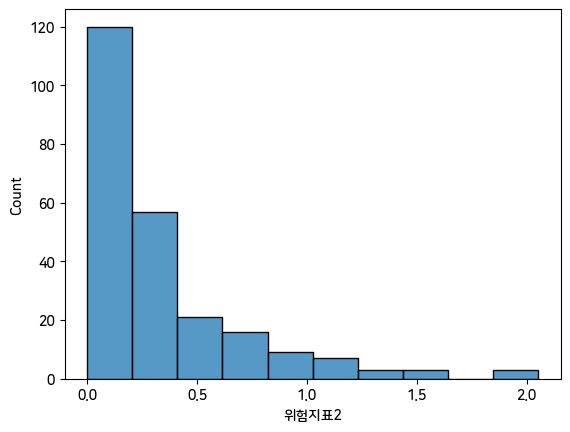

In [ ]:
scaled['위험지표2'] = scaled['무임하차인원'] + scaled['연단간격 높음 수'] + scaled['평균환승거리_m']

# 등급에 따라서 나눌 수 있다.
sns.histplot(scaled['위험지표2'], bins=10)
plt.show()

In [ ]:
# 유의한 변인에 회귀계수 곱하기 -> 최소 0, 최대 29점에 해당하는 안전지표 형성. 정규화를 통해
scaled['위험지표'] = (14.5 * scaled['연단간격 높음 수']) + (7.7 * scaled['평균환승거리_m'])
scaled[['역명','위험지표']].head()

,역명,위험지표
0,가락시장,2.145100
1,가산디지털단지,2.699057
2,강남,2.963669
3,강남구청,1.731115
4,강동,0.263129


- 지표만들기 : 접근성 지표

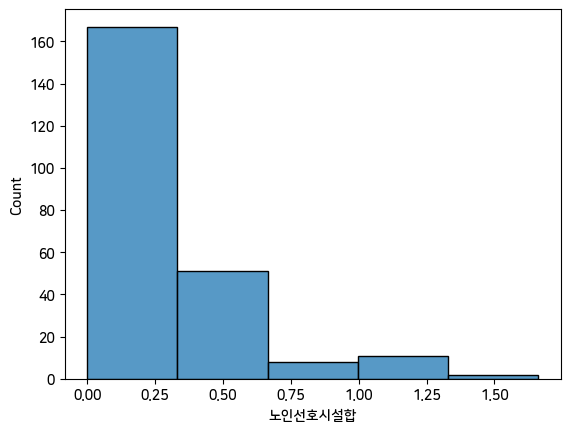

In [ ]:
# 히스토그램 기반
scaled['노인선호시설합'] = scaled['공원'] + scaled['의료시설'] + scaled['전통시장수(500m이내)']
sns.histplot(scaled['노인선호시설합'], bins=5)
plt.show()

In [ ]:
# 유의한 변인에 회귀계수를 곱해 접근성 지표 만들기
scaled['노인선호시설합2'] = (scaled['공원']*0.98) + (scaled['의료시설']*0.91) + (scaled['전통시장수(500m이내)']*2.38)
scaled['노인선호시설합2'].describe()
scaled['노인선호시설합2'].head()

,노인선호시설합2
0,0.350
1,0.000
2,0.000
3,0.350
4,0.795


### 3-3.기타 EDA : 태블로 보고서 대체

## 4.데이터 분석(지하철역별 안전성, 접근성 지표화)

In [ ]:
# 5년간 안전사고 발생 횟수와 안전 관련 변수들 간의 상관분석

import pandas as pd
import scipy.stats as stats

data = subway_eda_df2.copy()

# 독립변수와 종속변수 설정
independent_vars = ['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)',
                    '연단간격 높음 수', '높이차 높음 수', '평균환승거리_m']
dependent_var = '5년간 안전사고 발생 횟수'

# 상관계수 및 p-value 저장할 리스트 생성
corr_list = []

# 각 독립변수에 대해 상관계수 및 p-value 계산
for var in independent_vars:
    corr, p_value = stats.pearsonr(data[var], data[dependent_var])
    corr_list.append({'Variable': var, 'Correlation': corr, 'P-value': p_value})

# 리스트를 DataFrame으로 변환
corr_results = pd.DataFrame(corr_list)

# 결과 출력
print("상관계수와 P-value 결과:")
print(corr_results)

상관계수와 P-value 결과:
      Variable  Correlation       P-value
0   엘리베이터(E/V)     0.061463  3.125173e-01
1  에스컬레이터(E/S)     0.007532  9.015900e-01
2  휠체어리프트(W/L)     0.034252  5.738063e-01
3  수평자동보도(M/W)    -0.030430  6.173095e-01
4    연단간격 높음 수     0.313418  1.300247e-07
5     높이차 높음 수     0.100688  9.748968e-02
6     평균환승거리_m     0.316543  9.590165e-08


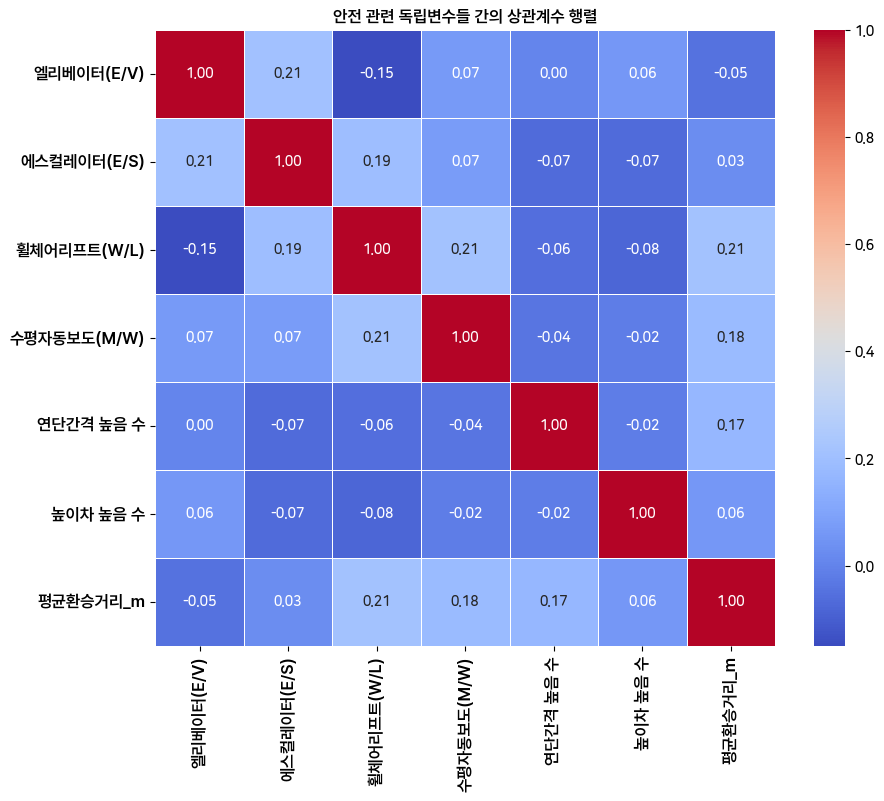


VIF (Variance Inflation Factor) 결과:
      Variable       VIF
0   엘리베이터(E/V)  3.053648
1  에스컬레이터(E/S)  2.898962
2  휠체어리프트(W/L)  1.315297
3  수평자동보도(M/W)  1.088726
4    연단간격 높음 수  1.160473
5     높이차 높음 수  1.081736
6     평균환승거리_m  1.529616


In [ ]:
# 독립변수들 간의 연관성을 파악하기 위해 상관관계 분석 및 다중공선성 여부 확인(VIF)
# VIF가 10 이상이면 다중공선성이 있다고 판단

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 경고 무시
warnings.filterwarnings("ignore")

# Pretendard 폰트 설정
font_path_pretendard = "/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf"  # Pretendard-SemiBold 폰트 경로
fontprop_pretendard = fm.FontProperties(fname=font_path_pretendard, size=12)

data = subway_eda_df2.copy()

# 독립 변수 설정
independent_vars = ['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)',
                    '연단간격 높음 수', '높이차 높음 수', '평균환승거리_m']

# 독립 변수들 간의 상관계수 행렬 계산
corr_matrix = data[independent_vars].corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# 폰트 적용
plt.title('안전 관련 독립변수들 간의 상관계수 행렬', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()

# VIF 계산 함수
def calculate_vif(df, independent_vars):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = independent_vars
    vif_data["VIF"] = [variance_inflation_factor(df[independent_vars].values, i) for i in range(len(independent_vars))]
    return vif_data

# 독립 변수의 VIF 계산
vif_results = calculate_vif(data, independent_vars)

# VIF 결과 출력
print("\nVIF (Variance Inflation Factor) 결과:")
print(vif_results)

In [ ]:
# 5년간 안전사고 발생 횟수(종속변수)와 안전 관련 변수(독립변수)들 간의 회귀분석

import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = data[independent_vars]
y = data[dependent_var]

# 상수항 추가 (회귀분석을 위해)
X = sm.add_constant(X)

# 회귀분석 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         5년간 안전사고 발생 횟수   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.775
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.06e-09
Time:                        07:34:32   Log-Likelihood:                -925.03
No. Observations:                 272   AIC:                             1866.
Df Residuals:                     264   BIC:                             1895.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.9262      1.416      2.773      

In [ ]:
# 무임하차인원과 노인 접근성 관련 변수들 상관분석

import pandas as pd
import scipy.stats as stats

# 데이터 로드
data = subway_eda_df2.copy()

# 독립변수와 종속변수 설정
independent_vars = ['전통시장수(500m이내)', '공원', '복지시설', '종교시설', '노인복지시설', '경로당', '의료시설']
dependent_var = '무임하차인원'

# 상관계수 및 p-value 저장할 리스트
corr_list = []

# 상관계수 및 p-value 계산
for var in independent_vars:
    corr, p_value = stats.pearsonr(data[var], data[dependent_var])
    corr_list.append({'Variable': var, 'Correlation': corr, 'P-value': p_value})

# 리스트를 DataFrame으로 변환
corr_results = pd.DataFrame(corr_list)

# 상관분석 결과 출력
print("상관계수와 P-value 결과:")
print(corr_results)

상관계수와 P-value 결과:
        Variable  Correlation       P-value
0  전통시장수(500m이내)     0.360629  8.917087e-10
1             공원     0.214821  3.592323e-04
2           복지시설     0.175283  3.731478e-03
3           종교시설     0.042099  4.893044e-01
4         노인복지시설     0.110956  6.767818e-02
5            경로당    -0.009385  8.775469e-01
6           의료시설     0.210624  4.704866e-04


In [ ]:
# 무임하차인원과 노인 접근성 관련 변수들 상관분석

import pandas as pd
import scipy.stats as stats

# 데이터 로드
data = subway_eda_df2.copy()

data['복지시설'] = data['노인복지시설'] + data['경로당']

# 독립변수와 종속변수 설정
independent_vars = ['전통시장수(500m이내)', '공원', '복지시설', '종교시설', '의료시설']
dependent_var = '무임하차인원'

# 상관계수 및 p-value 저장할 리스트
corr_list = []

# 상관계수 및 p-value 계산
for var in independent_vars:
    corr, p_value = stats.pearsonr(data[var], data[dependent_var])
    corr_list.append({'Variable': var, 'Correlation': corr, 'P-value': p_value})

# 리스트를 DataFrame으로 변환
corr_results = pd.DataFrame(corr_list)

# 상관분석 결과 출력
print("상관계수와 P-value 결과:")
print(corr_results)

상관계수와 P-value 결과:
        Variable  Correlation       P-value
0  전통시장수(500m이내)     0.360629  8.917087e-10
1             공원     0.214821  3.592323e-04
2           복지시설     0.077578  2.021408e-01
3           종교시설     0.042099  4.893044e-01
4           의료시설     0.210624  4.704866e-04


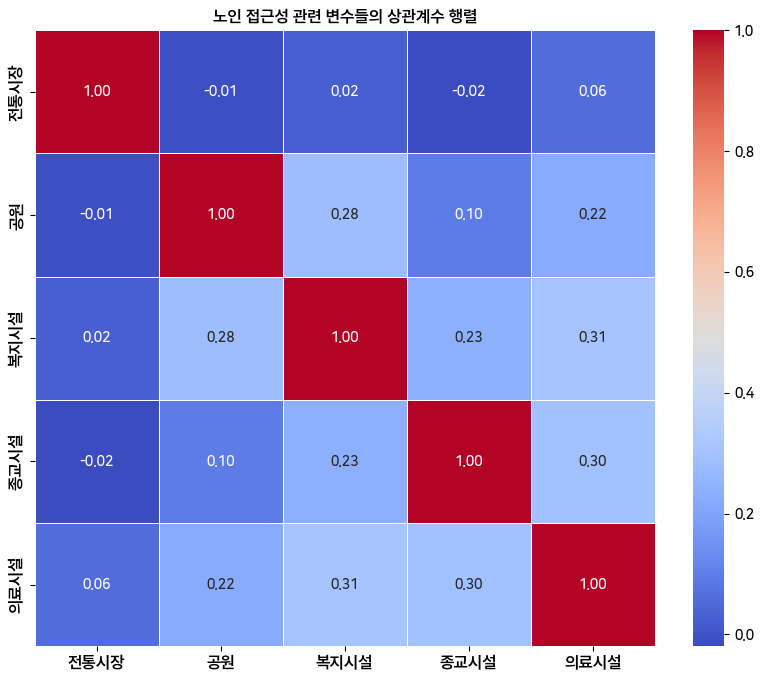


VIF (Variance Inflation Factor) 결과:
  Variable       VIF
0     전통시장  1.075433
1       공원  1.317178
2     복지시설  1.461040
3     종교시설  1.281720
4     의료시설  1.498462


In [ ]:
# 독립변수들 간의 연관성을 파악하기 위해 상관관계 분석 및 다중공선성 여부 확인(VIF)
# VIF가 10 이상이면 다중공선성이 있다고 판단

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 경고 무시
warnings.filterwarnings("ignore")

# Pretendard 폰트 설정
font_path_pretendard = "/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf"  # Pretendard-SemiBold 폰트 경로
fontprop_pretendard = fm.FontProperties(fname=font_path_pretendard, size=12)

# 데이터 로드
data = subway_eda_df2.copy()

data['전통시장'] = data['전통시장수(500m이내)']

# 독립 변수 설정
independent_vars = ['전통시장', '공원', '복지시설', '종교시설', '의료시설']

# 독립 변수들 간의 상관계수 행렬 계산
corr_matrix = data[independent_vars].corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# 폰트 적용
plt.title('노인 접근성 관련 변수들의 상관계수 행렬', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()

# VIF 계산 함수
def calculate_vif(df, independent_vars):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = independent_vars
    vif_data["VIF"] = [variance_inflation_factor(df[independent_vars].values, i) for i in range(len(independent_vars))]
    return vif_data

# 독립 변수의 VIF 계산
vif_results = calculate_vif(data, independent_vars)

# VIF 결과 출력
print("\nVIF (Variance Inflation Factor) 결과:")
print(vif_results)

In [ ]:
# 무임하차인원(종속변수)과 노인 접근성 관련 변수(독립변수)들 회귀분석

import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = data[independent_vars]
y = data[dependent_var]

# 상수항 추가 (회귀분석을 위해)
X = sm.add_constant(X)

# 회귀분석 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 회귀분석 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 무임하차인원   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     13.69
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           6.75e-12
Time:                        07:34:32   Log-Likelihood:                -3302.5
No. Observations:                 272   AIC:                             6617.
Df Residuals:                     266   BIC:                             6639.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.136e+04   3685.496     16.649      0.0

In [ ]:
# 무임하차인원과 안전 관련 변수들 간의 상관분석

import pandas as pd
import scipy.stats as stats

# 데이터 로드
data = subway_eda_df2.copy()

# 독립변수와 종속변수 설정
independent_vars = ['엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)',
                    '연단간격 높음 수', '높이차 높음 수', '평균환승거리_m']
dependent_var = '무임하차인원'

# 상관계수 및 p-value 저장할 리스트 생성
corr_list = []

# 각 독립변수에 대해 상관계수 및 p-value 계산
for var in independent_vars:
    corr, p_value = stats.pearsonr(data[var], data[dependent_var])
    corr_list.append({'Variable': var, 'Correlation': corr, 'P-value': p_value})

# 리스트를 DataFrame으로 변환
corr_results = pd.DataFrame(corr_list)

# 결과 출력
print("상관계수와 P-value 결과:")
print(corr_results)

상관계수와 P-value 결과:
      Variable  Correlation   P-value
0   엘리베이터(E/V)     0.048330  0.427269
1  에스컬레이터(E/S)    -0.043480  0.475151
2  휠체어리프트(W/L)    -0.015504  0.799086
3  수평자동보도(M/W)    -0.089225  0.142189
4    연단간격 높음 수     0.071219  0.241739
5     높이차 높음 수     0.140181  0.020739
6     평균환승거리_m     0.111056  0.067428


In [ ]:
# 성능을 높이기 위해 임의로 변수들을 정하고 가중치를 정해서 지하철역의 점수 채점
# 각 변수들과 무임하차인원 간의 회귀분석

import pandas as pd
import statsmodels.api as sm

# 파일 경로 설정
elderly_facility_data_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/역 주변 노인 선호 시설 (1) (1).csv'
market_data_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/서울_전통시장_지하철역_0.5km이내.csv'

# 데이터 로드
temp_df = subway_eda_df2.copy()
exclude_columns = ['공원', '행정시설', '의료시설', '복지시설', '종교시설']
safety_data = temp_df.drop(columns=exclude_columns)
elderly_facility_data = pd.read_csv(elderly_facility_data_path, encoding='utf-8-sig')
market_data = pd.read_csv(market_data_path, encoding='utf-8-sig')

# 데이터 병합 (역명과 호선을 기준으로 병합)
merged_data = pd.merge(safety_data, elderly_facility_data, on=['역명', '호선'], how='left')
merged_data = pd.merge(merged_data, market_data, on=['역명', '호선'], how='left')

# NaN 값을 0으로 채움
merged_data.fillna(0, inplace=True)

# 시장 근접성 (가까울수록 좋음)
merged_data['market_score'] = 1 - (merged_data['이동거리(km)'] / merged_data['이동거리(km)'].max())

# 시장 점수 추가
merged_data['시장_score'] = merged_data['시장'] / merged_data['시장'].max()

# 노인 친화 시설 종류별 점수 (긍정적인 영향)
facility_columns = ['공원', '의료시설', '복지시설']
for facility in facility_columns:
    merged_data[f'{facility}_score'] = merged_data[facility] / merged_data[facility].max()

# 최종 점수 계산: 안전 관련 변수들 및 추가된 엘리베이터, 에스컬레이터 등을 포함
merged_data['final_score'] = (
    merged_data['5년간 안전사고 발생 횟수'] * 0.1 +  # 안전사고 발생 횟수
    merged_data['연단간격 높음 수'] * 0.1 +         # 연단간격
    merged_data['높이차 높음 수'] * 0.1 +            # 높이차
    merged_data['엘리베이터(E/V)'] * 0.1 +          # 엘리베이터
    merged_data['에스컬레이터(E/S)'] * 0.1 +        # 에스컬레이터
    merged_data['휠체어리프트(W/L)'] * 0.1 +        # 휠체어리프트
    merged_data['수평자동보도(M/W)'] * 0.1 +        # 수평자동보도
    merged_data['시장_score'] * 0.2 +                # 시장 가중치
    merged_data['의료시설_score'] * 0.1 +            # 의료시설 가중치
    merged_data['공원_score'] * 0.05 +               # 공원 가중치
    merged_data['복지시설_score'] * 0.05             # 복지시설 가중치
)

# 상관관계 분석 (최종 점수와 무임하차인원 간의 상관관계)
correlation_matrix = merged_data[['final_score', '무임하차인원']].corr()
print("상관관계 분석 결과:")
print(correlation_matrix)

# 회귀분석 수행 (안전 관련 변수를 개별적으로 사용)
X = merged_data[['5년간 안전사고 발생 횟수', '연단간격 높음 수', '높이차 높음 수',
                 '엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)',
                 '시장_score', '의료시설_score', '공원_score', '복지시설_score']]
y = merged_data['무임하차인원']

# 상수항 추가 (회귀분석에서 절편 계산을 위해 필요)
X = sm.add_constant(X)

# 회귀분석 모델 생성 및 적합
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())


상관관계 분석 결과:
             final_score    무임하차인원
final_score     1.000000  0.416888
무임하차인원          0.416888  1.000000
                            OLS Regression Results                            
Dep. Variable:                 무임하차인원   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     472.5
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        07:34:33   Log-Likelihood:                -75989.
No. Observations:                6250   AIC:                         1.520e+05
Df Residuals:                    6238   BIC:                         1.521e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------

In [ ]:
# 랜덤 포레스트 회귀 모델과 의사결정 나무 모델을 앙상블 해서 무임하차인원 예측 모델 설계

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 독립 변수와 종속 변수 설정
X = merged_data[['엘리베이터(E/V)', '휠체어리프트(W/L)', '의료시설', '공원', '복지시설',
                 '5년간 안전사고 발생 횟수', '연단간격 높음 수', '높이차 높음 수']]
y = merged_data['무임하차인원']

# 데이터를 훈련 세트, 검증 세트, 테스트 세트로 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 훈련 데이터의 25%를 검증 세트로 사용

# 1. 랜덤 포레스트 회귀 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. 의사결정 나무 모델
dt_model = DecisionTreeRegressor(random_state=42)

# 3. 앙상블 모델 (VotingRegressor)
ensemble_model = VotingRegressor([('rf', rf_model), ('dt', dt_model)])
ensemble_model.fit(X_train, y_train)

# 검증 세트에서 예측
y_pred_val = ensemble_model.predict(X_val)

# 성능 평가: 평균 제곱 오차(MSE)와 R-squared (검증 세트)
print("검증 세트 성능:")
print(f"R-squared: {r2_score(y_val, y_pred_val)}")
print(f"Mean Squared Error: {mean_squared_error(y_val, y_pred_val)}")

# 최종 테스트 세트에서 성능 평가 (과적합 확인)
y_pred_test = ensemble_model.predict(X_test)

print("\n테스트 세트 성능:")
print(f"R-squared: {r2_score(y_test, y_pred_test)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_test)}")

# 양호한 성능

검증 세트 성능:
R-squared: 0.9357336502979287
Mean Squared Error: 234646280.8713457

테스트 세트 성능:
R-squared: 0.9333378226123814
Mean Squared Error: 276529692.663692


In [ ]:
# 접근성과 위험도에 대한 각 변수의 유효한 회귀계수를 점수 채점시 가중치로 사용
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 유효한 회귀계수를 가중치로 사용
accessibility_weights = {
    '전통시장수(500m이내)': 23630,
    '공원': 8852,
    '종교시설': 0,  # 유효하지 않음
    '복지시설': 0,  # 유효하지 않음
    '의료시설': 8204
}

danger_weights = {
    '엘리베이터(E/V)': 0,   # 유효하지 않음
    '에스컬레이터(E/S)': 0,  # 유효하지 않음
    '휠체어리프트(W/L)': 0,  # 유효하지 않음
    '수평자동보도(M/W)': 0,  # 유효하지 않음
    '연단간격 높음 수': 0.3886,
    '높이차 높음 수': 0,  # 유효하지 않음
    '평균환승거리_m': 0.0304
}

# 데이터 로드
data = subway_eda_df2.copy()

# 접근성 지표 계산
accessibility_score = pd.Series([0] * len(data))  # 초기화

for var, weight in accessibility_weights.items():
    if weight != 0:
        accessibility_score += data[var] * weight

# 접근성 지표 정규화 (0~10 범위)
scaler = MinMaxScaler(feature_range=(0, 10))
data['접근성 점수'] = scaler.fit_transform(accessibility_score.values.reshape(-1, 1))

# 위험성 지표 계산
danger_score = pd.Series([0] * len(data))  # 초기화

for var, weight in danger_weights.items():
    if weight != 0:
        danger_score += data[var] * weight

# 위험성 지표 정규화 (0~10 범위)
data['위험도 점수'] = scaler.fit_transform(danger_score.values.reshape(-1, 1))

# 결과를 저장할 CSV 파일 경로 설정
output_file_path = '지하철역별_데이터결합본_지표화ver.csv'
data.to_csv(output_file_path, encoding='utf-8-sig', index=False)

# 결과 출력
print(data[['호선', '역명', '접근성 점수', '위험도 점수']].describe())

               호선      접근성 점수      위험도 점수
count  272.000000  272.000000  272.000000
mean     4.606618    0.914106    1.023824
std      2.008201    1.259425    1.573069
min      1.000000    0.000000    0.000000
25%      3.000000    0.000000    0.000000
50%      5.000000    0.491205    0.000000
75%      6.000000    1.361065    1.506699
max      8.000000   10.000000   10.000000


In [ ]:
# 노인 친화도 점수 추가
# 접근성 점수에서 위험도 점수 빼기
data['노인 친화도 점수'] = data['접근성 점수'] - data['위험도 점수']

# MinMaxScaler를 이용해 0~10 범위로 스케일링
scaler = MinMaxScaler(feature_range=(0, 10))
data['노인 친화도 점수 (0~10)'] = scaler.fit_transform(data[['노인 친화도 점수']])

# CSV 파일로 저장
output_file_path = '지하철역별_데이터결합본_지표화ver.csv'
data.to_csv(output_file_path, index=False, encoding='utf-8-sig')

상관관계: 0.4124250530655976
p-value: 1.3549156041117364e-12


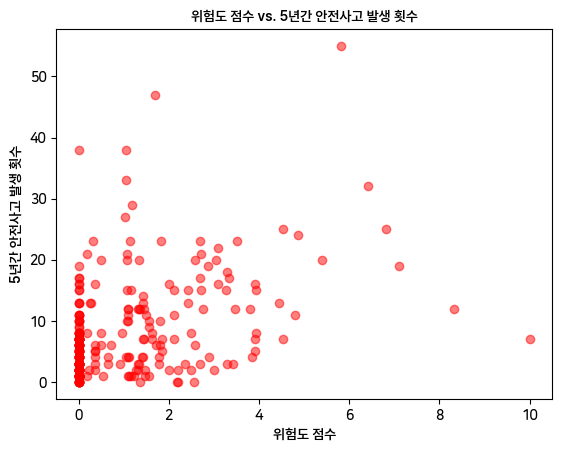

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# '위험도 점수'와 '5년간 안전사고 발생 횟수'의 상관관계 분석
danger_corr, danger_p_value = pearsonr(data['위험도 점수'], data['5년간 안전사고 발생 횟수'])

# 상관관계 및 p-value 출력
print(f"상관관계: {danger_corr}")
print(f"p-value: {danger_p_value}")

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'
font_prop = fm.FontProperties(fname=font_path)


# 산점도 시각화
plt.scatter(data['위험도 점수'], data['5년간 안전사고 발생 횟수'], color='red', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('위험도 점수 vs. 5년간 안전사고 발생 횟수', fontproperties=font_prop)
plt.xlabel('위험도 점수', fontproperties=font_prop)
plt.ylabel('5년간 안전사고 발생 횟수', fontproperties=font_prop)

# 그래프 출력
plt.show()

상관관계: 0.11994918168529528
p-value: 0.04812274297799899


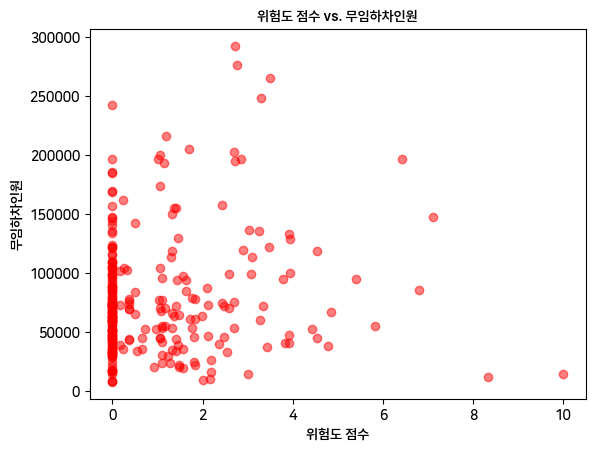

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# '위험도 점수'와 '5년간 안전사고 발생 횟수'의 상관관계 분석
danger_corr, danger_p_value = pearsonr(data['위험도 점수'], data['무임하차인원'])

# 상관관계 및 p-value 출력
print(f"상관관계: {danger_corr}")
print(f"p-value: {danger_p_value}")

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'
font_prop = fm.FontProperties(fname=font_path)


# 산점도 시각화
plt.scatter(data['위험도 점수'], data['무임하차인원'], color='red', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('위험도 점수 vs. 무임하차인원', fontproperties=font_prop)
plt.xlabel('위험도 점수', fontproperties=font_prop)
plt.ylabel('무임하차인원', fontproperties=font_prop)

# 그래프 출력
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = data['위험도 점수']  # 독립변수
y = data['5년간 안전사고 발생 횟수']  # 종속변수

# 독립변수에 상수항 추가 (절편 계산을 위해)
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 계수, 절편, 설명력(R²), 수정된 설명력(Adjusted R²) 출력
print(f"회귀 계수 (기울기): {model.params['위험도 점수']}")
print(f"절편 (y 절편): {model.params['const']}")
print(f"설명력 (R²): {model.rsquared}")
print(f"수정된 설명력 (Adjusted R²): {model.rsquared_adj}")

# 회귀 모델 요약 출력
print(model.summary())

회귀 계수 (기울기): 2.116178617941891
절편 (y 절편): 5.877523767491518
설명력 (R²): 0.17009442439616096
수정된 설명력 (Adjusted R²): 0.1670207000420726
                            OLS Regression Results                            
Dep. Variable:         5년간 안전사고 발생 횟수   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     55.34
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.35e-12
Time:                        07:34:35   Log-Likelihood:                -928.12
No. Observations:                 272   AIC:                             1860.
Df Residuals:                     270   BIC:                             1867.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]

상관관계: 0.44515618978753935
p-value: 1.2096297908283555e-14


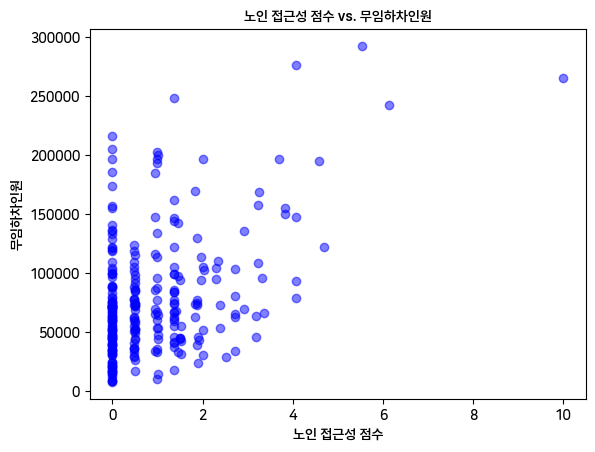

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# '접근성 점수'와 '무임하차인원'의 상관관계 분석
accessibility_corr, accessibility_p_value = pearsonr(data['접근성 점수'], data['무임하차인원'])

# 상관관계 및 p-value 출력
print(f"상관관계: {accessibility_corr}")
print(f"p-value: {accessibility_p_value}")

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'  # Pretendard 폰트 경로로 변경
font_prop = fm.FontProperties(fname=font_path)

# 산점도 시각화
plt.scatter(data['접근성 점수'], data['무임하차인원'], color='blue', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('노인 접근성 점수 vs. 무임하차인원', fontproperties=font_prop)
plt.xlabel('노인 접근성 점수', fontproperties=font_prop)
plt.ylabel('무임하차인원', fontproperties=font_prop)

# 그래프 출력
plt.show()

상관관계: 0.17739963209373844
p-value: 0.003329089646402451


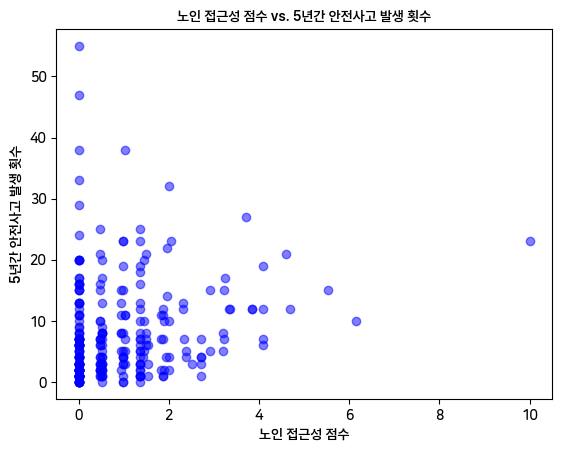

In [83]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# '접근성 점수'와 '무임하차인원'의 상관관계 분석
accessibility_corr, accessibility_p_value = pearsonr(data['접근성 점수'], data['5년간 안전사고 발생 횟수'])

# 상관관계 및 p-value 출력
print(f"상관관계: {accessibility_corr}")
print(f"p-value: {accessibility_p_value}")

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'  # Pretendard 폰트 경로로 변경
font_prop = fm.FontProperties(fname=font_path)

# 산점도 시각화
plt.scatter(data['접근성 점수'], data['5년간 안전사고 발생 횟수'], color='blue', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('노인 접근성 점수 vs. 5년간 안전사고 발생 횟수', fontproperties=font_prop)
plt.xlabel('노인 접근성 점수', fontproperties=font_prop)
plt.ylabel('5년간 안전사고 발생 횟수', fontproperties=font_prop)

# 그래프 출력
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 독립변수 (접근성 점수)와 종속변수 (무임하차인원) 설정
X = data['접근성 점수']  # 독립변수
y = data['무임하차인원']  # 종속변수

# 독립변수에 상수항 추가 (절편 계산을 위해)
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 계수, 절편, 설명력(R²), 수정된 설명력(Adjusted R²) 출력
print(f"회귀 계수 (접근성 점수): {model.params['접근성 점수']}")
print(f"절편 (y 절편): {model.params['const']}")
print(f"설명력 (R²): {model.rsquared}")
print(f"수정된 설명력 (Adjusted R²): {model.rsquared_adj}")

# 회귀 모델 요약 출력
print(model.summary())

회귀 계수 (접근성 점수): 18011.726515727947
절편 (y 절편): 62359.89557987855
설명력 (R²): 0.19816403330615995
수정된 설명력 (Adjusted R²): 0.19519427046655313
                            OLS Regression Results                            
Dep. Variable:                 무임하차인원   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     66.73
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.21e-14
Time:                        07:34:35   Log-Likelihood:                -3303.6
No. Observations:                 272   AIC:                             6611.
Df Residuals:                     270   BIC:                             6618.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0

노인 친화도 점수와 무임하차인원의 상관관계: 0.19565906377270942
p-value: 0.0011809722098201616


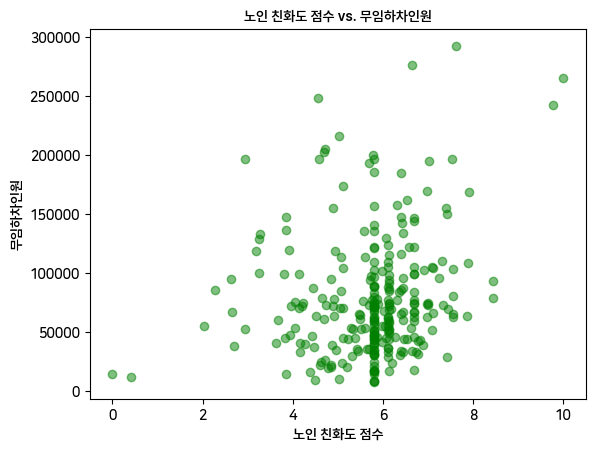

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'  # Pretendard 폰트 경로로 변경
font_prop = fm.FontProperties(fname=font_path)

# '노인 친화도 점수'와 '무임하차인원'의 상관관계 분석
danger_corr, danger_p_value = pearsonr(data['노인 친화도 점수 (0~10)'], data['무임하차인원'])

# 상관관계 및 p-value 출력
print(f"노인 친화도 점수와 무임하차인원의 상관관계: {danger_corr}")
print(f"p-value: {danger_p_value}")

# 산점도 시각화
plt.scatter(data['노인 친화도 점수 (0~10)'], data['무임하차인원'], color='green', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('노인 친화도 점수 vs. 무임하차인원', fontproperties=font_prop)
plt.xlabel('노인 친화도 점수', fontproperties=font_prop)
plt.ylabel('무임하차인원', fontproperties=font_prop)

# 그래프 출력
plt.show()

노인 친화도 점수와 5년간 안전사고 발생 횟수의 상관관계: -0.22374854799324234
p-value: 0.0001988767748136029


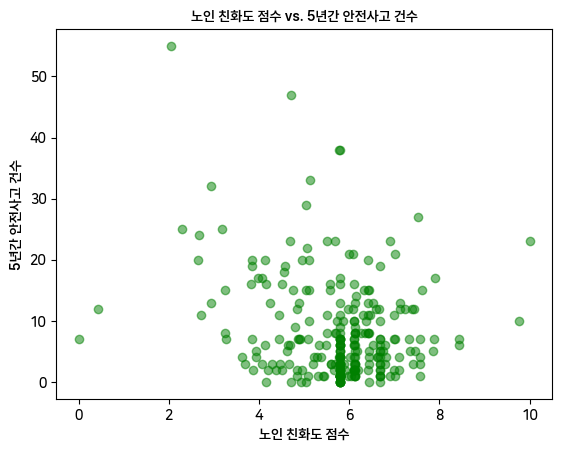

In [82]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Pretendard 폰트 경로 설정 (Pretendard 폰트가 시스템에 설치되어 있어야 함)
font_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf'  # Pretendard 폰트 경로로 변경
font_prop = fm.FontProperties(fname=font_path)

# '노인 친화도 점수'와 '무임하차인원'의 상관관계 분석
danger_corr, danger_p_value = pearsonr(data['노인 친화도 점수 (0~10)'], data['5년간 안전사고 발생 횟수'])

# 상관관계 및 p-value 출력
print(f"노인 친화도 점수와 5년간 안전사고 발생 횟수의 상관관계: {danger_corr}")
print(f"p-value: {danger_p_value}")

# 산점도 시각화
plt.scatter(data['노인 친화도 점수 (0~10)'], data['5년간 안전사고 발생 횟수'], color='green', alpha=0.5)

# 제목 및 축 레이블 설정
plt.title('노인 친화도 점수 vs. 5년간 안전사고 건수', fontproperties=font_prop)
plt.xlabel('노인 친화도 점수', fontproperties=font_prop)
plt.ylabel('5년간 안전사고 건수', fontproperties=font_prop)

# 그래프 출력
plt.show()

In [ ]:
# 대시보드 생성

import pandas as pd
import folium
from flask import Flask, render_template
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
from branca.colormap import linear

# 플라스크 애플리케이션 초기화
server = Flask(__name__)

# 지하철 데이터 로드
file_path = '/content/drive/MyDrive/6팀_초급프로젝트/Final_Data/지하철역별_데이터결합본_지표화ver.csv'
data = pd.read_csv(file_path, encoding='utf-8-sig')

# Pretendard 폰트 적용하는 CSS 스타일 추가
pretendard_font_url = "https://cdn.jsdelivr.net/gh/orioncactus/pretendard/dist/web/static/pretendard.css"

# 무임하차인원 정수 처리
data['무임하차인원'] = data['무임하차인원'].astype(int)

# 소수점 둘째 자리에서 반올림 처리 (접근성 점수, 위험도 점수, 노인 친화도 점수)
data['접근성 점수'] = data['접근성 점수'].round(2)
data['위험도 점수'] = data['위험도 점수'].round(2)
data['노인 친화도 점수 (0~10)'] = data['노인 친화도 점수 (0~10)'].round(2)

# Dash 애플리케이션 초기화 (Flask 서버와 함께)
app = Dash(__name__, server=server, suppress_callback_exceptions=True, external_stylesheets=[dbc.themes.BOOTSTRAP, pretendard_font_url])


# 위험도, 접근성, 노인 친화도 점수에 따른 색상 맵핑 (0~10 범위)
colormap_danger = linear.Reds_09.scale(0, 10)
colormap_accessibility = linear.Blues_09.scale(0, 10)
colormap_senior_friendly = linear.Greens_09.scale(0, 10)

# 지도 생성 함수
def create_map(filtered_data, score_type):
    m = folium.Map(location=[37.5665, 126.9780], zoom_start=13)

    # 점수 타입에 따라 컬러맵과 점수를 설정
    if score_type == '위험도':
        colormap = colormap_danger
        score_column = '위험도 점수'
        border_color = 'red'  # 테두리 색상: 빨강
    elif score_type == '접근성':
        colormap = colormap_accessibility
        score_column = '접근성 점수'
        border_color = 'blue'  # 테두리 색상: 파랑
    else:
        colormap = colormap_senior_friendly
        score_column = '노인 친화도 점수'
        border_color = 'green'  # 테두리 색상: 초록

    for i, row in filtered_data.iterrows():
        folium.Circle(
            location=[row['위도'], row['경도']],
            radius=row['무임하차인원'] * 0.001,  # 무임하차인원에 따른 버블 크기
            fill=True,
            fill_opacity=0.6,
            color=border_color,  # 테두리 색상 설정
            fill_color=colormap(row[score_column]),  # 내부 색상은 컬러맵에서 설정
            popup=f"{row['역명']} ({score_type.capitalize()} 점수: {row[score_column]}, 무임하차인원: {row['무임하차인원']})"
        ).add_to(m)

    colormap.add_to(m)

    return m



# 공통 레이아웃: 위험도, 접근성, 노인친화도 대시보드를 동일하게 처리
def common_layout(dash_id, dropdown_id_line, dropdown_id_station, table_id, title):
    return dbc.Container([
        html.H1(title, style={'text-align': 'center', 'margin-bottom': '20px', 'font-family': 'Pretendard', 'color': '#333'}),

        # 지도 섹션
        dbc.Row([dbc.Col(html.Div(id=dash_id), width=12)], style={'padding-bottom': '20px'}),

        # 필터링 섹션과 표 섹션
        dbc.Row([
            dbc.Col([
                html.Div([
                    html.H4("지하철 정보 필터링", style={'color': '#555', 'font-weight': 'bold', 'font-family': 'Pretendard'}),

                    html.Label("호선 선택", style={'margin-top': '10px', 'color': '#666', 'font-family': 'Pretendard'}),
                    dcc.Dropdown(
                        id=dropdown_id_line,
                        options=[{'label': i, 'value': i} for i in sorted(data['호선'].unique())],
                        multi=True,
                        placeholder="호선을 선택하세요",
                        style={'background-color': '#f9f9f9', 'font-family': 'Pretendard'}
                    ),

                    html.Label("역명 선택", style={'margin-top': '10px', 'color': '#666', 'font-family': 'Pretendard'}),
                    dcc.Dropdown(
                        id=dropdown_id_station,
                        options=[],
                        multi=True,
                        placeholder="역명을 선택하세요",
                        style={'background-color': '#f9f9f9', 'font-family': 'Pretendard'}
                    )
                ], style={'background-color': '#f1f1f1', 'padding': '20px', 'border-radius': '5px'})
            ], width=12)
        ], style={'padding-bottom': '20px'}),

        # 표 섹션
        dbc.Row([
            dbc.Col([
                html.H4("검색 결과", style={'color': '#333', 'margin-top': '0px','margin-bottom': '5px', 'font-family': 'Pretendard'}),
                dcc.Graph(id=table_id, style={'height': '600px'})  # 표 높이 설정
            ], width=12)
        ])
    ], fluid=True)

# 각 대시보드 레이아웃 함수
def danger_layout():
    return common_layout('map-container-danger', 'line-dropdown-danger', 'station-dropdown-danger', 'table-container-danger', "지하철 위험도 점수 대시보드 (버블 사이즈 = 무임하차인원)")

def accessibility_layout():
    return common_layout('map-container-accessibility', 'line-dropdown-accessibility', 'station-dropdown-accessibility', 'table-container-accessibility', "지하철 노인 접근성 점수 대시보드 (버블 사이즈 = 무임하차인원)")

def senior_friendly_layout():
    return common_layout('map-container-senior-friendly', 'line-dropdown-senior-friendly', 'station-dropdown-senior-friendly', 'table-container-senior-friendly', "지하철 노인 친화도 점수 대시보드 (버블 사이즈 = 무임하차인원)")

# Dash 애플리케이션 레이아웃 설정
app.layout = dbc.Container([
    dcc.Location(id='url', refresh=False),  # URL 변경 감지
    html.H1("지하철역 평가 지표 대시보드 선택", style={'text-align': 'center', 'margin-bottom': '20px', 'font-family': 'Pretendard', 'color': '#333'}),

    dbc.Row([
        dbc.Col(dbc.Button("위험도 점수 대시보드\n(색상: 위험도 점수)", href='/dash/danger', color="danger", n_clicks=0), width=4),
        dbc.Col(dbc.Button("노인 접근성 점수 대시보드\n(색상: 접근성 점수)", href='/dash/accessibility', color="primary", n_clicks=0), width=4),
        dbc.Col(dbc.Button("노인 친화도 점수 대시보드\n(색상: 노인 친화도 점수)", href='/dash/senior_friendly', color="success", n_clicks=0), width=4)
    ], style={'text-align': 'center', 'margin-top': '50px'}),

    html.Div(id='page-content')
])

# URL 경로에 따라 다른 레이아웃을 렌더링하는 콜백
@app.callback(
    Output('page-content', 'children'),
    [Input('url', 'pathname')]
)
def display_page(pathname):
    if pathname == '/dash/danger':
        return danger_layout()  # 변경된 위험도 점수 레이아웃
    elif pathname == '/dash/accessibility':
        return accessibility_layout()
    elif pathname == '/dash/senior_friendly':
        return senior_friendly_layout()
    else:
        return html.Div([html.H1("지하철 대시보드 선택", style={'text-align': 'center', 'font-family': 'Pretendard'})])

# 필터링 콜백 (예시: 위험도)
@app.callback(
    [Output('map-container-danger', 'children'),
     Output('table-container-danger', 'figure'),
     Output('station-dropdown-danger', 'options')],
    [Input('line-dropdown-danger', 'value'),
     Input('station-dropdown-danger', 'value')]
)
def update_danger_dashboard(selected_lines, selected_stations):
    # 필터링 로직
    filtered_data = data.copy()

    if selected_lines:
        filtered_data = filtered_data[filtered_data['호선'].isin(selected_lines)]
    if selected_stations:
        filtered_data = filtered_data[filtered_data['역명'].isin(selected_stations)]

    station_options = [{'label': station, 'value': station} for station in sorted(filtered_data['역명'].unique())]

    # 데이터 정렬
    filtered_data = filtered_data.sort_values(by='위험도 점수', ascending=False)  # 위험도 점수 기준 정렬

    # 지도 생성
    danger_map = create_map(filtered_data, '위험도')
    map_html = danger_map._repr_html_()

    # 표 생성
    table_figure = {
        'data': [{
            'type': 'table',
            'header': {'values': ['호선', '역명', '무임하차인원', '위험도 점수', '연단간격 높음 수', '평균환승거리_m']},
            'cells': {'values': [
                filtered_data['호선'], filtered_data['역명'],
                filtered_data['무임하차인원'], filtered_data['위험도 점수'],
                filtered_data['연단간격 높음 수'], filtered_data['평균환승거리_m']
            ]},
            'style': {'font-family': 'Pretendard'}
        }]
    }

    return html.Iframe(srcDoc=map_html, width='100%', height='800px'), table_figure, station_options

# 접근성 대시보드 지도와 표를 업데이트하는 콜백 함수
@app.callback(
    [Output('map-container-accessibility', 'children'),
     Output('table-container-accessibility', 'figure'),
     Output('station-dropdown-accessibility', 'options')],
    [Input('line-dropdown-accessibility', 'value'),
     Input('station-dropdown-accessibility', 'value')]
)
def update_accessibility_dashboard(selected_lines, selected_stations):
    # 필터링 로직
    filtered_data = data.copy()

    if selected_lines:
        filtered_data = filtered_data[filtered_data['호선'].isin(selected_lines)]
    if selected_stations:
        filtered_data = filtered_data[filtered_data['역명'].isin(selected_stations)]

    station_options = [{'label': station, 'value': station} for station in sorted(filtered_data['역명'].unique())]

    # 데이터 정렬
    filtered_data = filtered_data.sort_values(by='접근성 점수', ascending=False)

    # 지도 생성
    accessibility_map = create_map(filtered_data, '접근성')
    map_html = accessibility_map._repr_html_()

    # 표 생성
    table_figure = {
        'data': [{
            'type': 'table',
            'header': {'values': ['호선', '역명', '무임하차인원', '접근성 점수', '전통시장수(500m이내)', '공원', '의료시설']},
            'cells': {'values': [
                filtered_data['호선'], filtered_data['역명'],
                filtered_data['무임하차인원'], filtered_data['접근성 점수'],
                filtered_data['전통시장수(500m이내)'], filtered_data['공원'],
                filtered_data['의료시설']
            ]},
            'style': {'font-family': 'Pretendard'}
        }]
    }

    return html.Iframe(srcDoc=map_html, width='100%', height='800px'), table_figure, station_options

# 노인 친화도 대시보드 지도와 표를 업데이트하는 콜백 함수
@app.callback(
    [Output('map-container-senior-friendly', 'children'),
     Output('table-container-senior-friendly', 'figure'),
     Output('station-dropdown-senior-friendly', 'options')],
    [Input('line-dropdown-senior-friendly', 'value'),
     Input('station-dropdown-senior-friendly', 'value')]
)
def update_senior_friendly_dashboard(selected_lines, selected_stations):
    # 필터링 로직
    filtered_data = data.copy()

    if selected_lines:
        filtered_data = filtered_data[filtered_data['호선'].isin(selected_lines)]
    if selected_stations:
        filtered_data = filtered_data[filtered_data['역명'].isin(selected_stations)]

    station_options = [{'label': station, 'value': station} for station in sorted(filtered_data['역명'].unique())]

    # 데이터 정렬
    filtered_data = filtered_data.sort_values(by='노인 친화도 점수 (0~10)', ascending=False)

    # 지도 생성
    senior_friendly_map = create_map(filtered_data, '노인 친화도')
    map_html = senior_friendly_map._repr_html_()

    # 표 생성
    table_figure = {
        'data': [{
            'type': 'table',
            'header': {'values': ['호선', '역명', '무임하차인원', '노인 친화도 점수', '접근성 점수', '위험도 점수']},
            'cells': {'values': [
                filtered_data['호선'], filtered_data['역명'],
                filtered_data['무임하차인원'], filtered_data['노인 친화도 점수 (0~10)'],
                filtered_data['접근성 점수'], filtered_data['위험도 점수']
            ]},
            'style': {'font-family': 'Pretendard'}
        }]
    }

    return html.Iframe(srcDoc=map_html, width='100%', height='800px'), table_figure, station_options

# 애플리케이션 실행
if __name__ == '__main__':
    app.run_server(debug=True, port=8056)


## 5.번외(주제변경으로 인해 미포함된 데이터분석자료)

- 서울교통공사 적자와 경로 무임승차 간의 관계 분석

OLS 회귀 설명력 (R^2): 1.0
OLS 회귀 수정된 설명력 (Adjusted R^2): 1.0
OLS 회귀 교차 검증 평균 (Negative MSE): -1540656.869116777
OLS 회귀 교차 검증 표준편차: 997588.6438660237

각 변수의 OLS 회귀 계수:
          변수     OLS 회귀 계수
14       어린이  9.571224e-03
13     국가유공자  3.901404e-03
15       외국인  3.613433e-03
12        경로  2.590901e-04
10     영업외비용  5.795889e-05
0     운수사업수익  3.081950e-05
1     부대사업수익  1.501623e-05
9     수탁사업원가  1.064481e-05
3     수탁사업수익  1.064481e-05
8    지급수수료 등  8.104643e-06
2     기타사업수익  4.248723e-06
11     물가상승률 -2.016970e-07
7      감가상각비 -6.347645e-06
4      영업외수익 -1.135097e-05
6      복리후생비 -6.027469e-05
5   급여 및 평가급 -8.074984e-05
16       일반인 -2.713908e-04


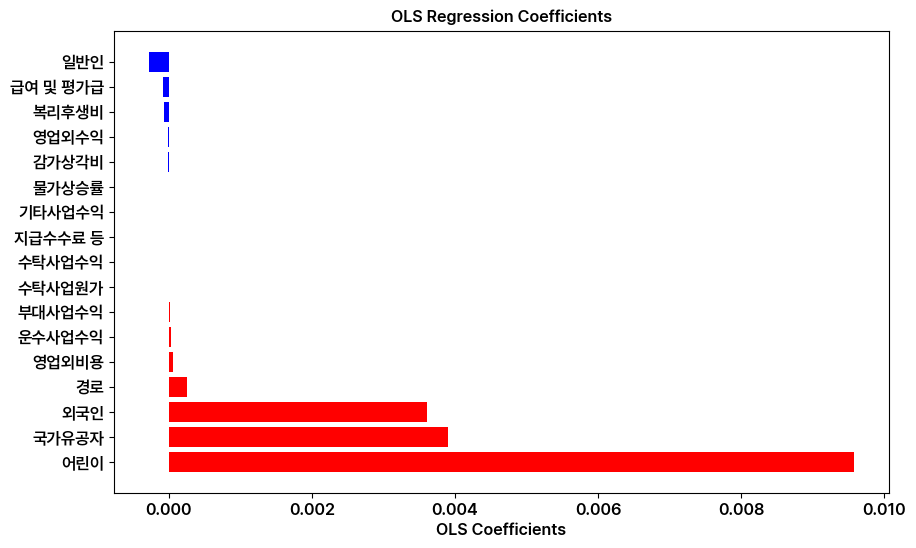

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Pretendard 폰트 설정
font_path_pretendard = "/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf"  # Pretendard-SemiBold 폰트 경로
fontprop_pretendard = fm.FontProperties(fname=font_path_pretendard, size=12)

# 1. 데이터 로드 및 준비
file_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/etc/이용량 지표(도시철도)_2018-2023.xlsx'
file_path_financial = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/etc/서울교통공사_2017-2023_손익(가공).xlsx'

# 각각의 시트를 데이터프레임으로 로드
df_usage = pd.read_excel(file_path, sheet_name='Sheet1')
df_financial = pd.read_excel(file_path_financial, sheet_name='Sheet1')

# 2. 데이터 전처리
usage_pivot = df_usage.pivot_table(index='년', columns='이용자유형', values='발생량', aggfunc='sum').reset_index()
df_financial = df_financial.set_index('구분').T.reset_index()
df_financial['년'] = df_financial['index'].str.extract(r'(\d+)년').astype(int)

# 두 데이터프레임을 병합
full_data = pd.merge(df_financial, usage_pivot, left_on='년', right_on='년')

# 물가상승률 데이터를 추가
inflation_rates = [1.5, 0.4, 0.5, 2.5, 5.1, 3.6]
full_data['물가상승률'] = inflation_rates

# 3. 영업 손익 파생 변수 생성
# 전체 수익
full_data['전체수익'] = (full_data['운수사업수익'] + full_data['부대사업수익'] + full_data['기타사업수익'] +
                      full_data['수탁사업수익'] + full_data['영업외수익'])

# 전체 비용
full_data['전체비용'] = (full_data['급여 및 평가급'] + full_data['복리후생비'] + full_data['감가상각비'] +
                      full_data['지급수수료 등'] + full_data['수탁사업원가'] + full_data['영업외비용'])

# 영업 손익 계산
full_data['영업손익'] = full_data['전체수익'] - full_data['전체비용']

# 4. 독립 변수(X) 및 종속 변수(y) 설정
X = full_data[['운수사업수익', '부대사업수익', '기타사업수익', '수탁사업수익', '영업외수익',
               '급여 및 평가급', '복리후생비', '감가상각비', '지급수수료 등', '수탁사업원가', '영업외비용',
               '물가상승률', '경로', '국가유공자', '어린이', '외국인', '일반인']]
y = full_data['영업손익']

# 5. OLS 회귀 모델 생성 및 학습
ols_model = LinearRegression()
ols_model.fit(X, y)

# 6. 회귀 계수 확인
ols_coefficients = ols_model.coef_

# 7. 모델의 설명력 평가 (R^2)
ols_r_squared = ols_model.score(X, y)

# 8. 수정된 설명력 계산 (Adjusted R^2)
n = X.shape[0]  # 데이터 포인트 수
p = X.shape[1]  # 독립 변수 수
ols_adj_r_squared = 1 - (1 - ols_r_squared) * (n - 1) / (n - p - 1)

# 9. 교차 검증으로 모델 유효성 평가
ols_cv_scores = cross_val_score(ols_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_mean = np.mean(ols_cv_scores)
ols_cv_std = np.std(ols_cv_scores)

# 10. 결과 요약 출력
print(f"OLS 회귀 설명력 (R^2): {ols_r_squared}")
print(f"OLS 회귀 수정된 설명력 (Adjusted R^2): {ols_adj_r_squared}")
print(f"OLS 회귀 교차 검증 평균 (Negative MSE): {ols_cv_mean}")
print(f"OLS 회귀 교차 검증 표준편차: {ols_cv_std}")

# 11. 변수 중요도 및 회귀 계수 출력
importance_summary = pd.DataFrame({
    '변수': X.columns,
    'OLS 회귀 계수': ols_coefficients
}).sort_values(by='OLS 회귀 계수', ascending=False)

# 각 변수의 OLS 회귀 계수 출력
print("\n각 변수의 OLS 회귀 계수:")
print(importance_summary)

# 변수 중요도 및 회귀 계수 출력 (회귀 계수를 기준으로 정렬)
importance_summary = pd.DataFrame({
    '변수': X.columns,
    'OLS 회귀 계수': ols_coefficients
}).sort_values(by='OLS 회귀 계수', ascending=False)

# 각 계수의 부호에 따라 색상을 설정
colors = ['red' if coef > 0 else 'blue' for coef in importance_summary['OLS 회귀 계수']]

# 변수 중요도 시각화 (양수는 빨강, 음수는 파랑)
plt.figure(figsize=(10, 6))
plt.barh(importance_summary['변수'], importance_summary['OLS 회귀 계수'], color=colors)
plt.xlabel('OLS Coefficients', fontproperties=fontprop_pretendard)  # X축 라벨: Pretendard
plt.title('OLS Regression Coefficients', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()


라쏘 회귀 설명력 (R^2): 0.9999999995628548
라쏘 회귀 교차 검증 평균 (Negative MSE): -1772004.242296936
라쏘 회귀 교차 검증 표준편차: 1168073.2461809707


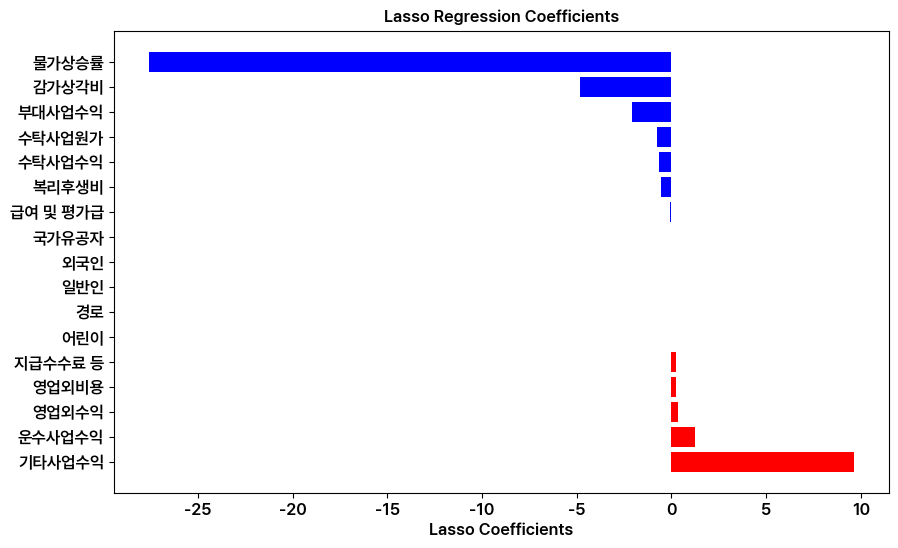

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Pretendard 폰트 설정
font_path_pretendard = "/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf"  # Pretendard-SemiBold 폰트 경로
fontprop_pretendard = fm.FontProperties(fname=font_path_pretendard, size=12)

# 1. 데이터 로드 및 준비
file_path = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/etc/이용량 지표(도시철도)_2018-2023.xlsx'
file_path_financial = '/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/etc/서울교통공사_2017-2023_손익(가공).xlsx'

# 각각의 시트를 데이터프레임으로 로드
df_usage = pd.read_excel(file_path, sheet_name='Sheet1')
df_financial = pd.read_excel(file_path_financial, sheet_name='Sheet1')

# 2. 데이터 전처리
usage_pivot = df_usage.pivot_table(index='년', columns='이용자유형', values='발생량', aggfunc='sum').reset_index()
df_financial = pd.DataFrame(df_financial.set_index('구분').T.reset_index())
df_financial['년'] = df_financial['index'].str.extract(r'(\d+)년').astype(int)

# 두 데이터프레임을 병합
full_data = pd.merge(df_financial, usage_pivot, left_on='년', right_on='년')

# 물가상승률 데이터를 추가
inflation_rates = [1.5, 0.4, 0.5, 2.5, 5.1, 3.6]
full_data['물가상승률'] = inflation_rates

# 3. 영업 손익 파생 변수 생성
# 전체 수익
full_data['전체수익'] = (full_data['운수사업수익'] + full_data['부대사업수익'] + full_data['기타사업수익'] +
                      full_data['수탁사업수익'] + full_data['영업외수익'])

# 전체 비용
full_data['전체비용'] = (full_data['급여 및 평가급'] + full_data['복리후생비'] + full_data['감가상각비'] +
                      full_data['지급수수료 등'] + full_data['수탁사업원가'] + full_data['영업외비용'])

# 영업 손익 계산
full_data['영업손익'] = full_data['전체수익'] - full_data['전체비용']

# 4. 독립 변수(X) 및 종속 변수(y) 설정
X = full_data[['운수사업수익', '부대사업수익', '기타사업수익', '수탁사업수익', '영업외수익',
               '급여 및 평가급', '복리후생비', '감가상각비', '지급수수료 등', '수탁사업원가', '영업외비용',
               '물가상승률', '경로', '국가유공자', '어린이', '외국인', '일반인']]
y = full_data['영업손익']

# 5. 라쏘 회귀 모델 생성 및 학습
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)

# 6. 회귀 계수 확인
lasso_coefficients = lasso_model.coef_

# 7. 모델의 설명력 평가 (R^2)
lasso_r_squared = lasso_model.score(X, y)

# 8. 교차 검증으로 모델 유효성 평가
lasso_cv_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_mean = np.mean(lasso_cv_scores)
lasso_cv_std = np.std(lasso_cv_scores)

# 9. 결과 요약 출력
print(f"라쏘 회귀 설명력 (R^2): {lasso_r_squared}")
print(f"라쏘 회귀 교차 검증 평균 (Negative MSE): {lasso_cv_mean}")
print(f"라쏘 회귀 교차 검증 표준편차: {lasso_cv_std}")

# 10. 변수 중요도 및 회귀 계수 출력 (회귀 계수를 기준으로 정렬)
importance_summary = pd.DataFrame({
    '변수': X.columns,
    '라쏘 회귀 계수': lasso_coefficients
}).sort_values(by='라쏘 회귀 계수', ascending=False)

# 각 계수의 부호에 따라 색상을 설정
colors = ['red' if coef > 0 else 'blue' for coef in importance_summary['라쏘 회귀 계수']]

# 11. 변수 중요도 시각화 (양수는 빨강, 음수는 파랑)
plt.figure(figsize=(10, 6))
plt.barh(importance_summary['변수'], importance_summary['라쏘 회귀 계수'], color=colors)
plt.xlabel('Lasso Coefficients', fontproperties=fontprop_pretendard)  # X축 라벨: Pretendard
plt.title('Lasso Regression Coefficients', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()

리지 회귀 설명력 (R^2): 1.0
리지 회귀 교차 검증 평균 (Negative MSE): -1540656.8693374838
리지 회귀 교차 검증 표준편차: 997588.643575409


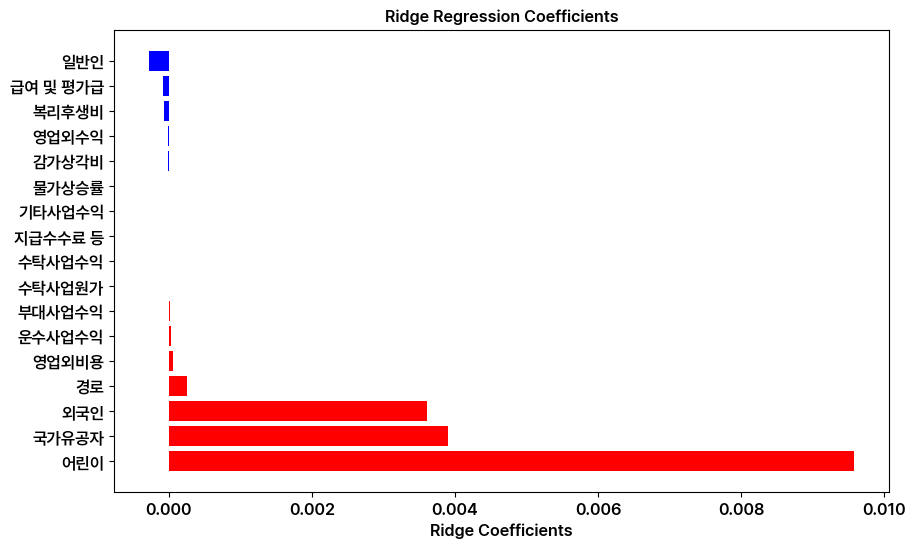

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Pretendard 폰트 설정
font_path_pretendard = "/content/drive/MyDrive/6팀_초급프로젝트/Processed_Data/Pretendard-SemiBold.otf"  # Pretendard-SemiBold 폰트 경로
fontprop_pretendard = fm.FontProperties(fname=font_path_pretendard, size=12)

# 데이터 준비
X = full_data[['운수사업수익', '부대사업수익', '기타사업수익', '수탁사업수익', '영업외수익',
               '급여 및 평가급', '복리후생비', '감가상각비', '지급수수료 등', '수탁사업원가', '영업외비용',
               '물가상승률', '경로', '국가유공자', '어린이', '외국인', '일반인']]
y = full_data['영업손익']

# 1. 리지 회귀 모델 생성 및 학습
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

# 2. 모델의 설명력 평가 (R^2)
ridge_r_squared = ridge_model.score(X, y)

# 3. 교차 검증으로 모델 유효성 평가
ridge_cv_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_cv_mean = np.mean(ridge_cv_scores)
ridge_cv_std = np.std(ridge_cv_scores)

# 4. 회귀 계수 출력
ridge_coefficients = ridge_model.coef_

# 5. 결과 출력
print(f"리지 회귀 설명력 (R^2): {ridge_r_squared}")
print(f"리지 회귀 교차 검증 평균 (Negative MSE): {ridge_cv_mean}")
print(f"리지 회귀 교차 검증 표준편차: {ridge_cv_std}")

# 변수 중요도 시각화 (리지 회귀 계수를 기준으로 정렬)
importance_summary_ridge = pd.DataFrame({
    '변수': X.columns,
    '리지 회귀 계수': ridge_coefficients
}).sort_values(by='리지 회귀 계수', ascending=False)

# 각 계수의 부호에 따라 색상을 설정 (양수는 빨강, 음수는 파랑)
colors = ['red' if coef > 0 else 'blue' for coef in importance_summary_ridge['리지 회귀 계수']]

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_summary_ridge['변수'], importance_summary_ridge['리지 회귀 계수'], color=colors)
plt.xlabel('Ridge Coefficients', fontproperties=fontprop_pretendard)
plt.title('Ridge Regression Coefficients', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()

엘라스틱넷 회귀 설명력 (R^2): 0.9999999978396974
엘라스틱넷 회귀 교차 검증 평균 (Negative MSE): -1058638.0094925212
엘라스틱넷 회귀 교차 검증 표준편차: 532875.0708297229


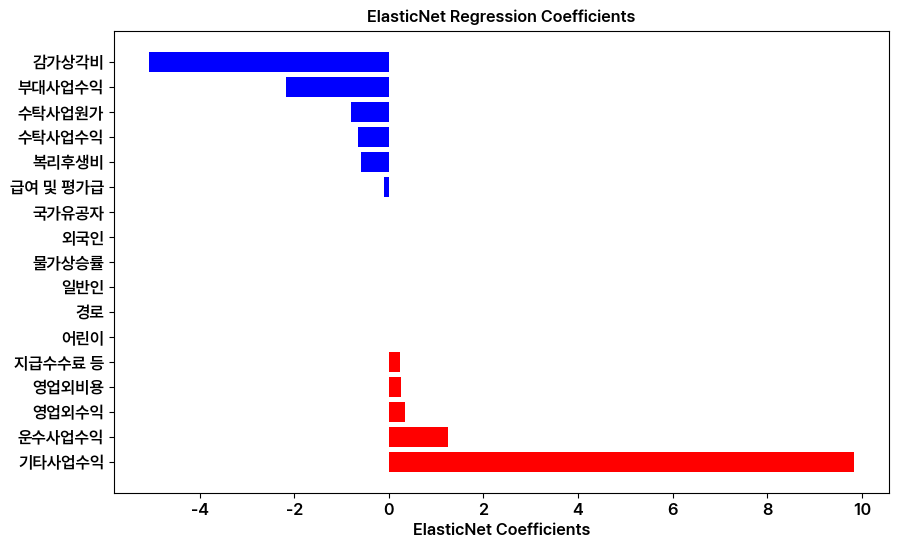

In [ ]:
from sklearn.linear_model import ElasticNet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 엘라스틱넷 회귀 모델 생성 및 학습
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elasticnet_model.fit(X, y)

# 2. 모델의 설명력 평가 (R^2)
elasticnet_r_squared = elasticnet_model.score(X, y)

# 3. 교차 검증으로 모델 유효성 평가
elasticnet_cv_scores = cross_val_score(elasticnet_model, X, y, cv=5, scoring='neg_mean_squared_error')
elasticnet_cv_mean = np.mean(elasticnet_cv_scores)
elasticnet_cv_std = np.std(elasticnet_cv_scores)

# 4. 회귀 계수 출력
elasticnet_coefficients = elasticnet_model.coef_

# 5. 결과 출력
print(f"엘라스틱넷 회귀 설명력 (R^2): {elasticnet_r_squared}")
print(f"엘라스틱넷 회귀 교차 검증 평균 (Negative MSE): {elasticnet_cv_mean}")
print(f"엘라스틱넷 회귀 교차 검증 표준편차: {elasticnet_cv_std}")

# 변수 중요도 시각화 (회귀 계수를 기준으로 정렬)
importance_summary_elasticnet = pd.DataFrame({
    '변수': X.columns,
    '엘라스틱넷 회귀 계수': elasticnet_coefficients
}).sort_values(by='엘라스틱넷 회귀 계수', ascending=False)

# 각 계수의 부호에 따라 색상을 설정 (양수는 빨강, 음수는 파랑)
colors = ['red' if coef > 0 else 'blue' for coef in importance_summary_elasticnet['엘라스틱넷 회귀 계수']]

# 6. 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_summary_elasticnet['변수'], importance_summary_elasticnet['엘라스틱넷 회귀 계수'], color=colors)
plt.xlabel('ElasticNet Coefficients', fontproperties=fontprop_pretendard)
plt.title('ElasticNet Regression Coefficients', fontproperties=fontprop_pretendard)
plt.xticks(fontproperties=fontprop_pretendard)
plt.yticks(fontproperties=fontprop_pretendard)
plt.show()